# Setup Training and Validation Datasets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.transforms import v2
import seaborn as sns

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from pickle import TRUE
USE_ENLARGED = True
SEGMENT = False

num_classes = 4 if USE_ENLARGED else 3
num_subclasses = 88 if USE_ENLARGED else 87

# Set the target number of images for each combination
TARGET_IMAGES_PER_SUBCLASS = 110
RELABLE_BAD_SUBCLASSES = True
GENERATE_IMAGES_TO_BALANCE_SUBCLASSES = False
REMOVE_BAD_IMAGES = True

BAD_IMAGES = set(["5910.jpg", "5350.jpg", "4295.jpg", "3023.jpg", "1748.jpg", "1231.jpg", "547.jpg", "235.jpg", "5588.jpg", "4200.jpg", "4565.jpg", "1922.jpg", "4565.jpg",
    "534.jpg", "589.jpg", "1013.jpg", "1231.jpg", "1274.jpg", "1501.jpg","1827.jpg", "1922.jpg", "2191.jpg", "2195.jpg", "2197.jpg", "2548.jpg","2575.jpg", "2578.jpg", "2690.jpg", "3049.jpg", "3099.jpg", "3100.jpg",
    "3292.jpg", "3481.jpg", "3702.jpg", "3743.jpg", "4099.jpg", "4565.jpg","4850.jpg", "4914.jpg", "5039.jpg", "5150.jpg", "5222.jpg", "5350.jpg","5557.jpg", "5726.jpg", "6037.jpg", "6262.jpg"])


In [ ]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

def segment_image(img, feature_extractor, model):
    image = Image.open(img)
    #image= img
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = model(**inputs)
    result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    # we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
    predicted_panoptic_map = result["segmentation"]
    color_segmentation_map = np.zeros((predicted_panoptic_map.shape[0], predicted_panoptic_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    ground_truth_color_seg = color_segmentation_map[..., ::-1]
    for label, color in enumerate(palette):
        color_segmentation_map[predicted_panoptic_map.cpu() - 1 == label, :] = color
    img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
    return Image.fromarray(img.astype(np.uint8))

if SEGMENT:
    # load MaskFormer fine-tuned on COCO panoptic segmentation
    model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-coco")
    model.to(device)
    feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-tiny-coco")

In [ ]:
from PIL import Image
import numpy as np
import random

import os
import shutil
import pandas as pd
from tqdm import tqdm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split


# Step 1: Extract images from the ZIP file
zip_path =  'drive/MyDrive/DL/extra_enlarged_train_shuffle.zip' if USE_ENLARGED else 'drive/MyDrive/DL/train_shuffle.zip'
extract_folder = 'images'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 2: Read CSV file
csv_path = 'drive/MyDrive/DL/extra_enlarged_train_data.csv' if USE_ENLARGED else 'drive/MyDrive/DL/train_data.csv'
df = pd.read_csv(csv_path)

if REMOVE_BAD_IMAGES:
  init_size = len(df)
  df = df[~df["image"].isin(BAD_IMAGES)]
  size_now = len(df)
  print("Removed {} bad images".format(init_size-size_now))

if RELABLE_BAD_SUBCLASSES:
    # Identify combinations with frequency less than 5 and relabel as 87
    combinations_frequencies = df.groupby(['superclass_index', 'subclass_index']).size().reset_index(name='count')
    threshold = 5
    combinations_to_relabel = combinations_frequencies[combinations_frequencies['count'] < threshold]
    df.loc[df.set_index(['superclass_index', 'subclass_index']).index.isin(combinations_to_relabel.set_index(['superclass_index', 'subclass_index']).index), 'subclass_index'] = 87
    combinations_frequencies = df.groupby(['superclass_index', 'subclass_index']).size().reset_index(name='count')

image_transform = v2.Compose([
    # Add your transformations here
    v2.RandomAffine(degrees=20),
    #v2.RandomGrayscale(),
    #v2.RandomInvert(.2),
])

if GENERATE_IMAGES_TO_BALANCE_SUBCLASSES:
    new_rows = []

    # Iterate over combinations_frequencies
    for index, row in tqdm(combinations_frequencies.iterrows(), total=len(combinations_frequencies), desc='Applying Transformations'):
        superclass = row['superclass_index']
        subclass = row['subclass_index']
        count = row['count']

        # Check if the count is less than the target_num
        if count < TARGET_IMAGES_PER_SUBCLASS:
            # Get images for the current combination
            image_files = list(df[(df['superclass_index'] == superclass) & (df['subclass_index'] == subclass)]["image"])
            #print("FILES:", superclass,subclass, count, image_files, )

            for i in range(TARGET_IMAGES_PER_SUBCLASS-count):
                image_file = random.choice(image_files)
                filename_without_extension = os.path.splitext(image_file)[0]

                # Load the image
                image_path = os.path.join(extract_folder, image_file)
                image = Image.open(image_path)

                # Apply random transformations
                transformed_image = image_transform(image)

                new_file_name = f'{filename_without_extension}_transformed_{i}_{image_file}'

                # Save the transformed image to the images folder
                transformed_image_path = os.path.join(extract_folder, new_file_name)
                transformed_image.save(transformed_image_path)

                # Update the DataFrame with the new image information
                new_row = {'image': new_file_name, 'superclass_index': superclass, 'subclass_index': subclass}
                new_rows.append(new_row)

    df = pd.concat([df, pd.DataFrame.from_records(new_rows)])


# Step 3: Split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Step 4: Create folder structure for training set
dataset_root = 'dataset'
train_root = os.path.join(dataset_root, 'train')
os.makedirs(train_root, exist_ok=True)

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc='Creating Training Folder Structure'):
    image_path = os.path.join(extract_folder, row['image']) if USE_ENLARGED else os.path.join(extract_folder, "train_shuffle", row['image'])
    superclass = str(row['superclass_index'])
    subclass = str(row['subclass_index'])

    # Create superclass folder if not exists
    superclass_folder = os.path.join(train_root, superclass)
    os.makedirs(superclass_folder, exist_ok=True)

    # Create subclass folder if not exists
    subclass_folder = os.path.join(superclass_folder, subclass)
    os.makedirs(subclass_folder, exist_ok=True)

    if SEGMENT:
        segmented_output_path = os.path.join(subclass_folder, row['image'])
        segmented_image = segment_image(image_path, feature_extractor, model)
        segmented_image.save(segmented_output_path)
    else:
        # Move the image to the subclass folder
        # try:
        shutil.move(image_path, subclass_folder)
        # except Exception as e:
        #   pass

# Step 5: Create folder structure for validation set
val_root = os.path.join(dataset_root, 'val')
os.makedirs(val_root, exist_ok=True)

for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc='Creating Validation Folder Structure'):
    image_path = os.path.join(extract_folder, row['image']) if USE_ENLARGED else os.path.join(extract_folder, "train_shuffle", row['image'])

    superclass = str(row['superclass_index'])
    subclass = str(row['subclass_index'])

    # Create superclass folder if not exists
    superclass_folder = os.path.join(val_root, superclass)
    os.makedirs(superclass_folder, exist_ok=True)

    # Create subclass folder if not exists
    subclass_folder = os.path.join(superclass_folder, subclass)
    os.makedirs(subclass_folder, exist_ok=True)

    if SEGMENT:
        segmented_output_path = os.path.join(subclass_folder, row['image'])
        segmented_image = segment_image(image_path, feature_extractor, model)
        segmented_image.save(segmented_output_path)
    else:
        # Move the image to the subclass folder
        # try:
        shutil.move(image_path, subclass_folder)
        # except Exception as e:
        #   pass

print("Folder structure creation complete.")

Removed 42 bad images


Creating Validation Folder Structure: 100%|██████████| 1026/1026 [00:00<00:00, 1504.40it/s]

Folder structure creation complete.


In [ ]:
# import os
# import shutil

# # Define the paths
# dataset_root = 'dataset'
# output_folder = 'images_segmented'

# # Create the output folder if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

# # Iterate through all files in the dataset folder (recursively)
# for root, dirs, files in os.walk(dataset_root):
#     for file in files:
#         # Get the full path of the current file
#         current_file_path = os.path.join(root, file)

#         # Create the destination path in the output folder
#         output_path = os.path.join(output_folder, file)

#         # Copy the current file to the destination path
#         shutil.copy(current_file_path, output_path)

# print("Copying files complete.")

In [ ]:
# zip_filename = "segmented.zip"
# with ZipFile(zip_filename, 'w') as zip_ref:
#     # Add all files in the output folder to the zip file
#     for root, dirs, files in os.walk(output_folder):
#         for file in files:
#             file_path = os.path.join(root, file)
#             zip_ref.write(file_path, os.path.relpath(file_path, output_folder))


In [ ]:
# Step 6: Extract images from the 'test_shuffle' folder inside the test ZIP file
test_zip_path = 'drive/MyDrive/DL/test_shuffle.zip'
test_extract_folder = 'test_images'
with ZipFile(test_zip_path, 'r') as zip_ref:
    # Extract only from the 'test_shuffle' folder inside the zip
    zip_ref.extractall(test_extract_folder)

# Step 7: Create folder structure for the test set
test_root = os.path.join(dataset_root, 'test')
os.makedirs(test_root, exist_ok=True)

# Move images directly to the test folder without the subfolder name
for test_image in tqdm(os.listdir(os.path.join(test_extract_folder, 'test_shuffle')), desc='Creating Test Folder Structure'):
    test_image_path = os.path.join(test_extract_folder, 'test_shuffle', test_image)

    # Create folder structure test_root/0/0 and move the image
    subclass_folder = os.path.join(test_root, '0', '0')
    os.makedirs(subclass_folder, exist_ok=True)
    shutil.move(test_image_path, os.path.join(subclass_folder, test_image))

Creating Test Folder Structure: 100%|██████████| 12377/12377 [00:01<00:00, 8661.21it/s]


## Random Shuffle - Experimental Idea - this didnt work bad idea


In [ ]:
# import os
# import random
# from shutil import move

# # Set the paths
# root_folder = 'dataset'
# train_folder = os.path.join(root_folder, 'train')
# subclass_folder_3_87 = os.path.join(train_folder, '3', '87')
# subclass_folder_1_87 = os.path.join(train_folder, '1', '87')
# subclass_folder_2_87 = os.path.join(train_folder, '2', '87')
# subclass_folder_0_87 = os.path.join(train_folder, '0', '87')


# # Create directories if they do not exist
# os.makedirs(subclass_folder_0_87, exist_ok=True)
# os.makedirs(subclass_folder_1_87, exist_ok=True)
# os.makedirs(subclass_folder_2_87, exist_ok=True)


# print("Directories 0/87, 1/87, and 2/87 created.")

# # Get a list of all image files in subclass_folder_3_87
# image_files = [f for f in os.listdir(subclass_folder_3_87) if os.path.isfile(os.path.join(subclass_folder_3_87, f))]

# # Calculate the number of images to move (1/3 of the total)
# num_images_to_move = int(len(image_files) / 3)

# # Randomly select num_images_to_move files
# random_images = random.sample(image_files, num_images_to_move)

# # Move each randomly selected file to either subclass_folder_1_87, subclass_folder_2_87, or subclass_folder_0_87
# for image in random_images:
#     destination_folder = random.choice([subclass_folder_1_87, subclass_folder_2_87, subclass_folder_0_87])
#     source_path = os.path.join(subclass_folder_3_87, image)
#     destination_path = os.path.join(destination_folder, image)
#     move(source_path, destination_path)

# print(f"{num_images_to_move} images moved from 3/87 to 1/87, 2/87, and 0/87.")

# Train Generalized

In [ ]:
#image folder but return both class and subclass label
class CustomImageFolder(datasets.ImageFolder):
  def __getitem__(self, index):
    image,_ = super().__getitem__(index)
    path, _ = self.samples[index]

    class_label = int(path.split(os.sep)[-3])  # Assuming the class label is the second-to-last directory
    subclass_label = int(path.split(os.sep)[-2])  # Assuming the subclass label is the last directory

    return image, (class_label, subclass_label)

In [ ]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]


In [ ]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation

class ColorPaletteTransform(object):
    def __init__(self, palette, model, feature_extractor):
        self.palette = palette
        self.model = model
        self.feature_extractor = feature_extractor

    def __call__(self, img):
        inputs = self.feature_extractor(images=img, return_tensors="pt")
        outputs = self.model(**inputs)
        result = self.feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[img.size[::-1]])[0]
        result = result["predicted_panoptic_map"]

        # Convert segmentation map to color using the defined palette
        color_segmentation_map = torch.zeros((predicted_panoptic_map.size(0), predicted_panoptic_map.size(1), 3), dtype=torch.uint8)

        for label, color in enumerate(self.palette):
            color_segmentation_map[predicted_panoptic_map - 1 == label, :] = torch.tensor(color)

        # Combine with the original image
        img_with_color = img * 0.5 + color_segmentation_map.to(img.dtype) * 0.5

        return img_with_color

  # load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-tiny-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-coco")
color_palette_transform = ColorPaletteTransform(color_palette(), model, feature_extractor)


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/feature_extraction_maskformer.py:28: FutureWarning: The class MaskFormerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MaskFormerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:410: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:417: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


config.json:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
def get_dataloaders(batch_size, num_workers=2, img_size=(224,224)):
  data_transforms = {
      'train': v2.Compose([
          v2.ToImage(),
          #v2.RandomResizedCrop(size=img_size, antialias=True, scale=(0.8,1)),  # Or Resize(antialias=True), scale=(0.4, 1.0)
          v2.Resize(size=img_size, antialias=True),  # Or Resize(antialias=True)
          v2.RandomHorizontalFlip(.33),
          #v2.RandomRotation(degrees=360),
          #v2.ColorJitter(),
          #color_palette_transform,
          v2.ToDtype(torch.float32, scale=True),
          v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]),
      'val': v2.Compose([
          v2.ToImage(),
          v2.Resize(size=img_size, antialias=True),  # Or Resize(antialias=True)
          #color_palette_transform,
          v2.ToDtype(torch.float32, scale=True),
          v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]),
      'test': v2.Compose([
          v2.ToImage(),
          v2.Resize(size=img_size, antialias=True),  # Or Resize(antialias=True)
          v2.ToDtype(torch.float32, scale=True),
          v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]),
  }

  data_dir = 'dataset'
  image_datasets = {x: CustomImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x == 'test' else True, num_workers=num_workers) for x in ['train', 'val']}
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  return dataloaders, dataset_sizes


In [ ]:
class CustomImageClassifier(nn.Module):
  def __init__(self, base_model, hidden_size, num_superclasses, num_subclasses, architecture = 'parallel', dropout = False):
    super(CustomImageClassifier, self).__init__()
    # print(dropout)
    # print(architecture)
    self.architecture = architecture
    self.dropout = dropout

    #Remove the existing classifier layer, If the model is ResNet, handle its sequential structure
    if isinstance(base_model, ResNetForImageClassification):
      base_model.classifier = nn.Sequential(*list(base_model.classifier.children())[:-1])
    else:
      base_model.classifier = nn.Identity()

    if self.architecture == 'parallel':
      self.classifier_subclass = nn.Linear(hidden_size, num_subclasses)
      self.classifier_superclass = nn.Linear(hidden_size, num_superclasses)
    elif self.architecture == 'sequential':
      self.classifier_subclass = nn.Linear(hidden_size + num_superclasses, num_subclasses)
      self.classifier_superclass = nn.Linear(hidden_size, num_superclasses)
    elif self.architecture == 'non-linear':
      self.classifier_subclass = nn.Sequential(
          nn.Linear(hidden_size, num_subclasses),
          nn.ReLU(),
          nn.Linear(num_subclasses, num_subclasses)
        )
      self.classifier_superclass = nn.Sequential(
          nn.Linear(hidden_size, num_superclasses),
          nn.ReLU(),
          nn.Linear(num_superclasses, num_superclasses)
          )
    # Store the base model
    self.base_model = base_model
    #this is specific to the convnext model not generalised, you could generalise dropout after every linear layer though.
    if self.dropout:
      self.base_model.convnextv2.encoder.stages[0].layers[0].pwconv2 = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(in_features=512, out_features=128, bias=True)
      )
      self.base_model.convnextv2.encoder.stages[1].layers[0].pwconv2 = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(in_features=1024, out_features=256, bias=True)
      )
      self.base_model.convnextv2.encoder.stages[2].layers[0].pwconv2 = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(in_features=2048, out_features=512, bias=True)
      )
      self.base_model.convnextv2.encoder.stages[3].layers[0].pwconv2 = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(in_features=4096, out_features=1024, bias=True)
      )




  def forward(self, pixel_values, labels=None, **kwargs):
    output = self.base_model(pixel_values=pixel_values, labels=labels, **kwargs)

    if self.architecture == 'parallel':
      # Apply the subclass and superclass classifiers
      logits_subclass = self.classifier_subclass(output.logits)
      logits_superclass = self.classifier_superclass(output.logits)
    elif self.architecture == 'sequential':
      logits_superclass = self.classifier_superclass(output.logits)
      # Concatenate the superclass logits with the original output
      combined_input = torch.cat((output.logits, logits_superclass), dim=1)
      logits_subclass = self.classifier_subclass(combined_input)
    elif self.architecture == 'non-linear':
      # Apply the subclass and superclass classifiers
      logits_subclass = self.classifier_subclass(output.logits)
      logits_superclass = self.classifier_superclass(output.logits)

    return {'logits_subclass': logits_subclass, 'logits_superclass': logits_superclass}


In [ ]:
class CustomResNet18(nn.Module):
    def __init__(self, num_features, num_channels=100):
        super(CustomResNet18, self).__init__()

        # Adjust the first layer to accept the specified number of channels
        self.conv1 = nn.Conv2d(num_channels, 3, kernel_size=7, stride=2, padding=3, bias=False)

        # Load the pre-trained ResNet-18 model
        resnet = resnet18(pretrained=True)

        # Use only the feature extraction layers (excluding the classifier)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Define a linear layer to reduce the number of features to the desired output
        self.fc = nn.Linear(512, num_features)

    def forward(self, masks_queries_logits):
        # Forward pass through the modified ResNet-18
        x = self.conv1(masks_queries_logits)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
# @title
class CustomImageClassifierWithSS(nn.Module):
  def __init__(self, base_model, ss_model, hidden_size,ss_num_features, num_superclasses, num_subclasses):
    super(CustomImageClassifierWithSS, self).__init__()

    #Remove the existing classifier layer, If the model is ResNet, handle its sequential structure
    if isinstance(base_model, ResNetForImageClassification):
      base_model.classifier = nn.Sequential(*list(base_model.classifier.children())[:-1])
    else:
      base_model.classifier = nn.Identity()

    # Add your custom classifiers
    self.classifier_subclass = nn.Linear(hidden_size+ss_num_features, num_subclasses)
    self.classifier_superclass = nn.Linear(hidden_size+ss_num_features, num_superclasses)

    # Store the base model
    self.base_model = base_model
    self.ss_model = ss_model
    self.ss_res18 = CustomResNet18(ss_num_features).to(device)

  def forward(self, pixel_values, labels=None, **kwargs):
    output = self.base_model(pixel_values=pixel_values, labels=labels, **kwargs)
    ss_output = self.ss_model(pixel_values)
    masks_queries_logits = ss_output['masks_queries_logits']
    resnet_output = self.ss_res18(masks_queries_logits)
    combined_outputs = torch.cat((output.logits, resnet_output), dim=1)

    # Apply the subclass and superclass classifiers
    logits_subclass = self.classifier_subclass(combined_outputs)
    logits_superclass = self.classifier_superclass(combined_outputs)

    return {'logits_subclass': logits_subclass, 'logits_superclass': logits_superclass}

In [ ]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification, ViTImageProcessor, ViTForImageClassification, AutoImageProcessor, ResNetForImageClassification,ConvNextV2ForImageClassification,BeitForImageClassification,AutoModelForImageClassification, MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
from torchvision.models import resnet18

def get_model(model_name, fine_tune, num_classes=num_classes, num_subclasses=num_subclasses, use_ss=False, ss_num_features=None, dropout=False, architecture='parallel'):

  if use_ss:
    ss_model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-coco")
    ss_model.to(device)

  if model_name == "vit":
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    model = CustomImageClassifier(model, model.config.hidden_size, num_classes, num_subclasses)
  elif model_name == "convnext":
    model = ConvNextForImageClassification.from_pretrained("facebook/convnext-base-224-22k")
    model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses)
  elif model_name == "convnextv2-tiny":
    model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-tiny-1k-224")
    model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses)
  elif model_name == "convnextv2":
    print(dropout)
    print(architecture)
    #now passes in dropout and nonlinear classifier architecture
    model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-base-22k-224")
    model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses, dropout=dropout, architecture=architecture)
  elif model_name == "convnextv2-22k-tiny":
    model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-tiny-22k-224")
    if use_ss:
      model = CustomImageClassifierWithSS(model, ss_model, model.classifier.in_features, ss_num_features, num_classes, num_subclasses)
    else:
      model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses)
  elif model_name == "resnet50":
    model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
    model = CustomImageClassifier(model, model.classifier[-1].in_features, num_classes, num_subclasses)
  elif model_name == "deit-tiny":
    model = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')
    model = CustomImageClassifier(model, model.config.hidden_size, num_classes, num_subclasses)
  elif model_name == "deit":
    model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224')
    model = CustomImageClassifier(model, model.config.hidden_size, num_classes, num_subclasses)
  elif model_name == "beit":
    model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
    model = CustomImageClassifier(model, model.config.hidden_size, num_classes, num_subclasses)
  elif model_name == "convnextv2-large":
    model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-large-22k-224")
    model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses, dropout=dropout, architecture=architecture)


  if fine_tune:
    # Freeze all layers except the new classifier head
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier_subclass.parameters():
        param.requires_grad = True
    for param in model.classifier_superclass.parameters():
        param.requires_grad = True
    if use_ss:
      for param in model.ss_res18.fc.parameters():
        param.requires_grad = True

  return model



In [ ]:
def train_model_v2(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, alpha, beta, wanb):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                epoch_since = time.time()
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects_subclass = 0
                running_corrects_superclass = 0

                # Iterate over data.
                for inputs, (super_labels, sub_labels) in dataloaders[phase]:
                    size = inputs.size(0)
                    inputs = inputs.to(device)
                    super_labels = super_labels.to(device)
                    sub_labels = sub_labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        outputs_subclass = outputs['logits_subclass']
                        outputs_superclass = outputs['logits_superclass']
                        _, preds_subclass = torch.max(outputs_subclass, 1)
                        _, preds_superclass = torch.max(outputs_superclass, 1)

                        loss_subclass = criterion(outputs_subclass, sub_labels)
                        loss_superclass = criterion(outputs_superclass, super_labels)

                        # Combine the subclass and superclass losses as needed
                        loss = alpha * loss_subclass + beta * loss_superclass

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * size
                    running_corrects_subclass += torch.sum(preds_subclass == sub_labels.data)
                    running_corrects_superclass += torch.sum(preds_superclass == super_labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc_subclass = running_corrects_subclass.double() / dataset_sizes[phase]
                epoch_acc_superclass = running_corrects_superclass.double() / dataset_sizes[phase]
                epoch_time_elapsed = time.time() - epoch_since

                print(f'{phase} Loss: {epoch_loss:.4f} Acc (Superclass): {epoch_acc_superclass:.4f} Acc (Subclass): {epoch_acc_subclass:.4f} Time: {epoch_time_elapsed % 60:.0f}s')

                # deep copy the model
                if phase == 'val' and epoch_acc_subclass + epoch_acc_superclass > best_acc:
                    best_acc = epoch_acc_subclass + epoch_acc_superclass
                    torch.save(model.state_dict(), best_model_params_path)

                if wanb:
                    if phase == 'val':
                        wandb.log({"loss": epoch_loss, "epoch": epoch, "epoch_acc_subclass": epoch_acc_subclass, "epoch_acc_superclass": epoch_acc_superclass})
                    if phase == 'train':
                        wandb.log({"train_loss": epoch_loss, "epoch": epoch, "train_epoch_acc_subclass": epoch_acc_subclass, "train_epoch_acc_superclass": epoch_acc_superclass})



        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def train(params, wanb=None, model=None):
  num_workers = params["num_workers"] if "num_workers" in params else 2
  num_classes = params["num_classes"] if "num_classes" in params else num_classes
  num_subclasses = params["num_subclasses"] if "num_subclasses" in params else num_subclasses
  learning_rate = params["learning_rate"] if "learning_rate" in params else 0.001
  momentum = params["momentum"] if "momentum" in params else 0.9
  step_size = params["step_size"] if "step_size" in params else 7
  gamma = params["gamma"] if "gamma" in params else 0.1
  alpha = params["alpha"] if "alpha" in params else 0.5
  beta = 1-alpha
  ss_num_features = params["ss_num_features"] if "ss_num_features" in params else None
  use_ss = ss_num_features is not None
  dropout = params["dropout"] if "dropout" in params else False
  architecture = params["architecture"] if "architecture" in params else 'parallel'

  dataloaders, dataset_sizes = get_dataloaders(params["batch_size"],num_workers=num_workers)

  if not model:
    model = get_model(params["model_name"], params["fine_tune"], num_classes=num_classes,num_subclasses=num_subclasses, use_ss=use_ss, ss_num_features=ss_num_features, dropout=dropout, architecture=architecture)
    model.to(device)

  if params["loss"] == "cross_entropy":
    criterion = nn.CrossEntropyLoss()
  if params["loss"] == "smoothed_cross_entropy":
    criterion = nn.CrossEntropyLoss(label_smoothing = 0.08)

  if params["optimizer"] == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
  elif params["optimizer"] == "adam":
    # Additional code for Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  elif params["optimizer"] == "adamw":
    # Additional code for Adam optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

  # Decay LR by a factor of 0.1 every 7 epochs
  if params["scheduler"] == "step_lr":
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  model = train_model_v2(model, criterion, optimizer, scheduler, params["num_epochs"], dataloaders, dataset_sizes, alpha, beta, wanb)
  return model



# Visualize Model - No Need to run

In [ ]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation

class ColorPaletteTransform(object):
    def __init__(self, palette, model, feature_extractor):
        self.palette = palette
        self.model = model.to(device)
        self.feature_extractor = feature_extractor

    def __call__(self, img):
        inputs = self.feature_extractor(images=img, return_tensors="pt")
        inputs.to(device)
        print("HERE")
        outputs = self.model(**inputs)
        print("HERE AS WELL")
        result = self.feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[img.size[::-1]])[0]
        result = result["predicted_panoptic_map"]

        # Convert segmentation map to color using the defined palette
        color_segmentation_map = torch.zeros((predicted_panoptic_map.size(0), predicted_panoptic_map.size(1), 3), dtype=torch.uint8).to(device)

        for label, color in enumerate(self.palette):
            color_segmentation_map[predicted_panoptic_map - 1 == label, :] = torch.tensor(color)

        # Combine with the original image
        img_with_color = img * 0.5 + color_segmentation_map.to(img.dtype) * 0.5

        return img_with_color

  # load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-tiny-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-coco")
color_palette_transform = ColorPaletteTransform(color_palette(), model, feature_extractor)

In [ ]:
from torchvision.transforms import v2

data_transforms = {
    'train': v2.Compose([
        v2.ToImage(),
        v2.RandomResizedCrop(size=(224, 224), antialias=True, scale=(.8,1)),  # Or Resize(antialias=True)
        #v2.RandomHorizontalFlip(),
        color_palette_transform,
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

RuntimeError: ignored

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs['logits_superclass'], 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model)

plt.ioff()
plt.show()

NameError: ignored

# Different Experiments

## Resnet50 as Feature Extractor

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"resnet50", "batch_size":32, "fine_tune":True}
train(params)


FileNotFoundError: ignored

## Fine Tune Resnet 50

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"resnet50", "batch_size":32, "fine_tune":False}
train(params)

FileNotFoundError: ignored

## ConvnextV2 Tiny As Feature Extractor

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2-tiny", "batch_size":32, "fine_tune":True}
train(params)

Epoch 0/9
----------


TypeError: ignored

## Convnext as feature Extractor

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnext", "batch_size":32, "fine_tune":True}
train(params)

## VIT As Feature Extractor

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"vit", "batch_size":32, "fine_tune":True}
train(params)

## Convnextv2 as feature extractor

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2", "batch_size":32, "fine_tune":True}
train(params)

## Beit as Feature Extractor

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"beit", "batch_size":32, "fine_tune":True}
train(params)

## Deit Tiny as Feature Extractor

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"deit-tiny", "batch_size":32, "fine_tune":True}
train(params)

## Deit as Feature Extractor

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"deit", "batch_size":32, "fine_tune":True}
train(params)

## Convnextv2 22k tiny as feature extractor


In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2-22k-tiny", "batch_size":32, "fine_tune":True}
train(params)

FileNotFoundError: ignored

## Convnextv2 22k As Feature Extractor Adam


In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2", "batch_size":32, "fine_tune":True}
train(params)

FileNotFoundError: ignored

## Convnextv2 22k Large As Feature Extractor Adam


In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2-large", "batch_size":32, "fine_tune":True}
train(params)

FileNotFoundError: ignored

# Hugging Face Style Training - Work in Progress


In [ ]:
! pip install accelerate -U


In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Specify your desired output directory
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,  # You may adjust these values based on your specific requirements
    weight_decay=0.01,
    logging_dir="./logs",
    learning_rate=1e-3,
)
model = get_model("resnet50", True)
print(model)
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=None,  # Use default collation if not specified
    train_dataset=image_datasets['train'],
    eval_dataset=image_datasets['val'],
    tokenizer=AutoImageProcessor.from_pretrained("microsoft/resnet-50"),
)

# Start training
trainer.train()

# Save the trained model
trainer.save_model("./output_model")

# Weights and Biases Sweep

In [ ]:
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
import wandb

wandb.login()

#key is b483dc6f7d8614fbb7c6d2b29793cb36d939ddb2

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.0001,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 16,
        'max': 256,
    },
    'step_size': {
        'values': [5,15,20],
    },
    'num_epochs': {
        'values':[10, 15, 20],
    },
    'alpha': {
        'values':[ .25, .5, .75]
    },
    'model_name':{
        'values': ['convnextv2-22k-tiny', 'deit-tiny']
    }
}

sweep_config['parameters'] = parameters_dict


In [ ]:
def train_wandb(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        params = dict(config)

        #parameters we are not searching for right now
        params['fine_tune'] = True
        params['loss'] = "cross_entropy"
        params['scheduler'] = 'step_lr'

        train(params, wandb)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="cs4995-deep-learning-project")



Create sweep with ID: x5ud11ch
Sweep URL: https://wandb.ai/cs4995-deep-learning-project/cs4995-deep-learning-project/sweeps/x5ud11ch


In [ ]:
wandb.agent(sweep_id, train_wandb, count=20)

wandb: Agent Starting Run: welieyld with config:
wandb: 	alpha: 0.75
wandb: 	batch_size: 208
wandb: 	learning_rate: 0.03319435826450327
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 15
wandb: 	optimizer: adam
wandb: 	step_size: 15


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Epoch 0/14
----------
train Loss: 2.8281 Acc (Superclass): 0.8235 Acc (Subclass): 0.3665 Time: 20s
val Loss: 2.2336 Acc (Superclass): 0.8831 Acc (Subclass): 0.4755 Time: 2s
Epoch 1/14
----------
train Loss: 1.7829 Acc (Superclass): 0.8763 Acc (Subclass): 0.5468 Time: 12s
val Loss: 1.7847 Acc (Superclass): 0.8752 Acc (Subclass): 0.5403 Time: 3s
Epoch 2/14
----------
train Loss: 1.5896 Acc (Superclass): 0.8675 Acc (Subclass): 0.5827 Time: 16s
val Loss: 1.8240 Acc (Superclass): 0.8673 Acc (Subclass): 0.5577 Time: 2s
Epoch 3/14
----------
train Loss: 1.5590 Acc (Superclass): 0.8798 Acc (Subclass): 0.5808 Time: 12s
val Loss: 1.7090 Acc (Superclass): 0.8531 Acc (Subclass): 0.5687 Time: 2s
Epoch 4/14
----------
train Loss: 1.5954 Acc (Superclass): 0.8780 Acc (Subclass): 0.5887 Time: 12s
val Loss: 1.9591 Acc (Superclass): 0.8578 Acc (Subclass): 0.5292 Time: 2s
Epoch 5/14
----------
train Loss: 1.5687 Acc (Superclass): 0.8699 Acc (Subclass): 0.5927 Time: 13s
val Loss: 2.2231 Acc (Superclass): 0

wandb: Agent Starting Run: fg9i3w4n with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.02613598757750987
wandb: 	model_name: convnextv2-22k-tiny
wandb: 	num_epochs: 20
wandb: 	optimizer: adam
wandb: 	step_size: 20


Epoch 0/19
----------
train Loss: 6.4432 Acc (Superclass): 0.8789 Acc (Subclass): 0.4547 Time: 34s
val Loss: 6.2578 Acc (Superclass): 0.9005 Acc (Subclass): 0.5561 Time: 4s
Epoch 1/19
----------
train Loss: 6.1118 Acc (Superclass): 0.9074 Acc (Subclass): 0.5917 Time: 34s
val Loss: 6.7075 Acc (Superclass): 0.9131 Acc (Subclass): 0.5845 Time: 4s
Epoch 2/19
----------
train Loss: 6.2798 Acc (Superclass): 0.9095 Acc (Subclass): 0.6172 Time: 34s
val Loss: 8.0852 Acc (Superclass): 0.9021 Acc (Subclass): 0.5750 Time: 4s
Epoch 3/19
----------
train Loss: 6.0967 Acc (Superclass): 0.9112 Acc (Subclass): 0.6523 Time: 34s
val Loss: 7.5772 Acc (Superclass): 0.9131 Acc (Subclass): 0.6145 Time: 4s
Epoch 4/19
----------
train Loss: 6.0450 Acc (Superclass): 0.9179 Acc (Subclass): 0.6632 Time: 34s
val Loss: 7.8104 Acc (Superclass): 0.9068 Acc (Subclass): 0.6209 Time: 4s
Epoch 5/19
----------
train Loss: 5.8976 Acc (Superclass): 0.9184 Acc (Subclass): 0.6840 Time: 34s
val Loss: 8.5310 Acc (Superclass): 0

wandb: Agent Starting Run: 2pm1xx7x with config:
wandb: 	alpha: 0.75
wandb: 	batch_size: 56
wandb: 	learning_rate: 0.01357836865494722
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: 	step_size: 5


Epoch 0/14
----------
train Loss: 2.2402 Acc (Superclass): 0.8170 Acc (Subclass): 0.3350 Time: 13s
val Loss: 1.5340 Acc (Superclass): 0.8863 Acc (Subclass): 0.4803 Time: 2s
Epoch 1/14
----------
train Loss: 1.3946 Acc (Superclass): 0.8724 Acc (Subclass): 0.5414 Time: 12s
val Loss: 1.4068 Acc (Superclass): 0.8499 Acc (Subclass): 0.5340 Time: 2s
Epoch 2/14
----------
train Loss: 1.2463 Acc (Superclass): 0.8838 Acc (Subclass): 0.5915 Time: 12s
val Loss: 1.2887 Acc (Superclass): 0.8705 Acc (Subclass): 0.5750 Time: 2s
Epoch 3/14
----------
train Loss: 1.1463 Acc (Superclass): 0.8815 Acc (Subclass): 0.6173 Time: 13s
val Loss: 1.2355 Acc (Superclass): 0.8657 Acc (Subclass): 0.5877 Time: 2s
Epoch 4/14
----------
train Loss: 1.0984 Acc (Superclass): 0.8912 Acc (Subclass): 0.6245 Time: 14s
val Loss: 1.2157 Acc (Superclass): 0.8957 Acc (Subclass): 0.5814 Time: 2s
Epoch 5/14
----------
train Loss: 1.0201 Acc (Superclass): 0.8914 Acc (Subclass): 0.6667 Time: 14s
val Loss: 1.1329 Acc (Superclass): 0

wandb: Agent Starting Run: tuxqp697 with config:
wandb: 	alpha: 0.25
wandb: 	batch_size: 240
wandb: 	learning_rate: 0.04146333202641795
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 20
wandb: 	optimizer: adam
wandb: 	step_size: 20


Epoch 0/19
----------
train Loss: 1.9563 Acc (Superclass): 0.7747 Acc (Subclass): 0.3433 Time: 13s
val Loss: 1.1927 Acc (Superclass): 0.8657 Acc (Subclass): 0.5166 Time: 2s
Epoch 1/19
----------
train Loss: 1.0093 Acc (Superclass): 0.8661 Acc (Subclass): 0.5470 Time: 13s
val Loss: 0.8820 Acc (Superclass): 0.8910 Acc (Subclass): 0.5450 Time: 2s
Epoch 2/19
----------
train Loss: 0.8160 Acc (Superclass): 0.8810 Acc (Subclass): 0.5744 Time: 14s
val Loss: 0.9073 Acc (Superclass): 0.8784 Acc (Subclass): 0.5355 Time: 2s
Epoch 3/19
----------
train Loss: 0.7343 Acc (Superclass): 0.8873 Acc (Subclass): 0.5991 Time: 14s
val Loss: 0.8916 Acc (Superclass): 0.8736 Acc (Subclass): 0.5355 Time: 2s
Epoch 4/19
----------
train Loss: 0.7821 Acc (Superclass): 0.8778 Acc (Subclass): 0.5878 Time: 12s
val Loss: 1.0028 Acc (Superclass): 0.8515 Acc (Subclass): 0.5087 Time: 2s
Epoch 5/19
----------
train Loss: 0.7778 Acc (Superclass): 0.8796 Acc (Subclass): 0.5927 Time: 11s
val Loss: 0.9773 Acc (Superclass): 0

wandb: Agent Starting Run: hosgnn0m with config:
wandb: 	alpha: 0.75
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0029848887013219087
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 10
wandb: 	optimizer: adam
wandb: 	step_size: 15


Epoch 0/9
----------
train Loss: 1.9643 Acc (Superclass): 0.8457 Acc (Subclass): 0.3953 Time: 14s
val Loss: 1.3715 Acc (Superclass): 0.8641 Acc (Subclass): 0.5434 Time: 2s
Epoch 1/9
----------
train Loss: 1.2850 Acc (Superclass): 0.8747 Acc (Subclass): 0.5790 Time: 14s
val Loss: 1.2674 Acc (Superclass): 0.8863 Acc (Subclass): 0.5608 Time: 2s
Epoch 2/9
----------
train Loss: 1.1586 Acc (Superclass): 0.8877 Acc (Subclass): 0.6122 Time: 14s
val Loss: 1.3292 Acc (Superclass): 0.8657 Acc (Subclass): 0.5608 Time: 2s
Epoch 3/9
----------
train Loss: 1.0900 Acc (Superclass): 0.8847 Acc (Subclass): 0.6279 Time: 14s
val Loss: 1.1197 Acc (Superclass): 0.9005 Acc (Subclass): 0.5956 Time: 2s
Epoch 4/9
----------
train Loss: 1.0749 Acc (Superclass): 0.8937 Acc (Subclass): 0.6295 Time: 14s
val Loss: 1.2144 Acc (Superclass): 0.8768 Acc (Subclass): 0.5924 Time: 2s
Epoch 5/9
----------
train Loss: 1.0441 Acc (Superclass): 0.8896 Acc (Subclass): 0.6495 Time: 13s
val Loss: 1.1985 Acc (Superclass): 0.8831 

wandb: Agent Starting Run: 5lavtw6f with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 24
wandb: 	learning_rate: 0.01996317225302236
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 10
wandb: 	optimizer: adam
wandb: 	step_size: 15


Epoch 0/9
----------
train Loss: 2.3155 Acc (Superclass): 0.8379 Acc (Subclass): 0.3820 Time: 14s
val Loss: 2.5289 Acc (Superclass): 0.8404 Acc (Subclass): 0.3886 Time: 2s
Epoch 1/9
----------
train Loss: 2.2033 Acc (Superclass): 0.8597 Acc (Subclass): 0.4850 Time: 15s
val Loss: 2.2985 Acc (Superclass): 0.8515 Acc (Subclass): 0.4645 Time: 2s
Epoch 2/9
----------
train Loss: 2.0994 Acc (Superclass): 0.8610 Acc (Subclass): 0.5286 Time: 14s
val Loss: 2.4618 Acc (Superclass): 0.8657 Acc (Subclass): 0.4803 Time: 2s
Epoch 3/9
----------
train Loss: 2.1612 Acc (Superclass): 0.8620 Acc (Subclass): 0.5282 Time: 14s
val Loss: 3.0471 Acc (Superclass): 0.7141 Acc (Subclass): 0.4518 Time: 2s
Epoch 4/9
----------
train Loss: 2.0730 Acc (Superclass): 0.8690 Acc (Subclass): 0.5614 Time: 15s
val Loss: 2.8168 Acc (Superclass): 0.8310 Acc (Subclass): 0.4834 Time: 2s
Epoch 5/9
----------
train Loss: 2.0914 Acc (Superclass): 0.8713 Acc (Subclass): 0.5715 Time: 14s
val Loss: 2.7965 Acc (Superclass): 0.8310 

wandb: Agent Starting Run: vp29r0xc with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 152
wandb: 	learning_rate: 0.05914874903772221
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 20
wandb: 	optimizer: sgd
wandb: 	step_size: 5


Epoch 0/19
----------
train Loss: 1.7615 Acc (Superclass): 0.8260 Acc (Subclass): 0.2877 Time: 12s
val Loss: 1.1420 Acc (Superclass): 0.8799 Acc (Subclass): 0.4992 Time: 2s
Epoch 1/19
----------
train Loss: 1.0069 Acc (Superclass): 0.8803 Acc (Subclass): 0.5474 Time: 12s
val Loss: 0.9760 Acc (Superclass): 0.8894 Acc (Subclass): 0.5608 Time: 2s
Epoch 2/19
----------
train Loss: 0.9288 Acc (Superclass): 0.8705 Acc (Subclass): 0.5940 Time: 11s
val Loss: 0.9887 Acc (Superclass): 0.8720 Acc (Subclass): 0.5498 Time: 2s
Epoch 3/19
----------
train Loss: 0.8687 Acc (Superclass): 0.8799 Acc (Subclass): 0.6149 Time: 11s
val Loss: 0.9378 Acc (Superclass): 0.8784 Acc (Subclass): 0.5829 Time: 2s
Epoch 4/19
----------
train Loss: 0.8300 Acc (Superclass): 0.8785 Acc (Subclass): 0.6375 Time: 12s
val Loss: 0.9344 Acc (Superclass): 0.8894 Acc (Subclass): 0.5687 Time: 2s
Epoch 5/19
----------
train Loss: 0.7691 Acc (Superclass): 0.8914 Acc (Subclass): 0.6602 Time: 13s
val Loss: 0.8633 Acc (Superclass): 0

wandb: Agent Starting Run: h3i4q91r with config:
wandb: 	alpha: 0.25
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.06843992830369316
wandb: 	model_name: convnextv2-22k-tiny
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: 	step_size: 15


Epoch 0/14
----------
train Loss: 0.9408 Acc (Superclass): 0.8857 Acc (Subclass): 0.4941 Time: 34s
val Loss: 0.9504 Acc (Superclass): 0.8689 Acc (Subclass): 0.6035 Time: 4s
Epoch 1/14
----------
train Loss: 0.6663 Acc (Superclass): 0.9111 Acc (Subclass): 0.6746 Time: 32s
val Loss: 0.5951 Acc (Superclass): 0.9210 Acc (Subclass): 0.6540 Time: 4s
Epoch 2/14
----------
train Loss: 0.6488 Acc (Superclass): 0.9112 Acc (Subclass): 0.7172 Time: 32s
val Loss: 0.7133 Acc (Superclass): 0.9226 Acc (Subclass): 0.6635 Time: 4s
Epoch 3/14
----------
train Loss: 0.5883 Acc (Superclass): 0.9186 Acc (Subclass): 0.7369 Time: 32s
val Loss: 0.6534 Acc (Superclass): 0.9052 Acc (Subclass): 0.6556 Time: 4s
Epoch 4/14
----------
train Loss: 0.5929 Acc (Superclass): 0.9133 Acc (Subclass): 0.7418 Time: 32s
val Loss: 0.6292 Acc (Superclass): 0.9321 Acc (Subclass): 0.6904 Time: 4s
Epoch 5/14
----------
train Loss: 0.5472 Acc (Superclass): 0.9232 Acc (Subclass): 0.7576 Time: 33s
val Loss: 0.7121 Acc (Superclass): 0

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mcawq7sm with config:
wandb: 	alpha: 0.75
wandb: 	batch_size: 40
wandb: 	learning_rate: 0.02596878944621541
wandb: 	model_name: convnextv2-22k-tiny
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: 	step_size: 15


Epoch 0/9
----------
train Loss: 1.5511 Acc (Superclass): 0.8998 Acc (Subclass): 0.5119 Time: 33s
val Loss: 1.1082 Acc (Superclass): 0.9289 Acc (Subclass): 0.6335 Time: 4s
Epoch 1/9
----------
train Loss: 1.0280 Acc (Superclass): 0.9265 Acc (Subclass): 0.6611 Time: 32s
val Loss: 1.1175 Acc (Superclass): 0.9400 Acc (Subclass): 0.6288 Time: 4s
Epoch 2/9
----------
train Loss: 0.9428 Acc (Superclass): 0.9267 Acc (Subclass): 0.6982 Time: 32s
val Loss: 1.1109 Acc (Superclass): 0.9210 Acc (Subclass): 0.6335 Time: 4s
Epoch 3/9
----------
train Loss: 0.8698 Acc (Superclass): 0.9302 Acc (Subclass): 0.7170 Time: 33s
val Loss: 1.0175 Acc (Superclass): 0.9415 Acc (Subclass): 0.6524 Time: 4s
Epoch 4/9
----------
train Loss: 0.8121 Acc (Superclass): 0.9271 Acc (Subclass): 0.7254 Time: 32s
val Loss: 1.0108 Acc (Superclass): 0.9163 Acc (Subclass): 0.6746 Time: 4s
Epoch 5/9
----------
train Loss: 0.8253 Acc (Superclass): 0.9316 Acc (Subclass): 0.7316 Time: 32s
val Loss: 1.1005 Acc (Superclass): 0.9052 

wandb: Agent Starting Run: v6eypuzg with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 24
wandb: 	learning_rate: 0.06969101296171154
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 20
wandb: 	optimizer: sgd
wandb: 	step_size: 5


Epoch 0/19
----------
train Loss: 2.2223 Acc (Superclass): 0.8251 Acc (Subclass): 0.3730 Time: 13s
val Loss: 3.5925 Acc (Superclass): 0.6856 Acc (Subclass): 0.3870 Time: 3s
Epoch 1/19
----------
train Loss: 2.6260 Acc (Superclass): 0.8295 Acc (Subclass): 0.5025 Time: 13s
val Loss: 2.9075 Acc (Superclass): 0.8167 Acc (Subclass): 0.4739 Time: 2s
Epoch 2/19
----------
train Loss: 2.2303 Acc (Superclass): 0.8634 Acc (Subclass): 0.5270 Time: 13s
val Loss: 3.0003 Acc (Superclass): 0.8199 Acc (Subclass): 0.4645 Time: 2s
Epoch 3/19
----------
train Loss: 2.4880 Acc (Superclass): 0.8443 Acc (Subclass): 0.5328 Time: 13s
val Loss: 2.9949 Acc (Superclass): 0.8231 Acc (Subclass): 0.4645 Time: 2s
Epoch 4/19
----------
train Loss: 2.2139 Acc (Superclass): 0.8608 Acc (Subclass): 0.5609 Time: 13s
val Loss: 2.3434 Acc (Superclass): 0.8373 Acc (Subclass): 0.5261 Time: 2s
Epoch 5/19
----------
train Loss: 1.3083 Acc (Superclass): 0.8824 Acc (Subclass): 0.6567 Time: 13s
val Loss: 1.4714 Acc (Superclass): 0

wandb: Agent Starting Run: 3u3xkzfq with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.04303444386849705
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 10
wandb: 	optimizer: adam
wandb: 	step_size: 20


Epoch 0/9
----------
train Loss: 3.0748 Acc (Superclass): 0.8267 Acc (Subclass): 0.3776 Time: 12s
val Loss: 2.8050 Acc (Superclass): 0.8468 Acc (Subclass): 0.4313 Time: 2s
Epoch 1/9
----------
train Loss: 2.5163 Acc (Superclass): 0.8617 Acc (Subclass): 0.4985 Time: 11s
val Loss: 2.9249 Acc (Superclass): 0.8404 Acc (Subclass): 0.4897 Time: 2s
Epoch 2/9
----------
train Loss: 2.6367 Acc (Superclass): 0.8550 Acc (Subclass): 0.5184 Time: 11s
val Loss: 3.1636 Acc (Superclass): 0.8341 Acc (Subclass): 0.4897 Time: 2s
Epoch 3/9
----------
train Loss: 2.5422 Acc (Superclass): 0.8712 Acc (Subclass): 0.5467 Time: 12s
val Loss: 2.8835 Acc (Superclass): 0.8689 Acc (Subclass): 0.5134 Time: 2s
Epoch 4/9
----------
train Loss: 2.5804 Acc (Superclass): 0.8638 Acc (Subclass): 0.5465 Time: 13s
val Loss: 3.2891 Acc (Superclass): 0.8799 Acc (Subclass): 0.4850 Time: 2s
Epoch 5/9
----------
train Loss: 2.6104 Acc (Superclass): 0.8625 Acc (Subclass): 0.5648 Time: 13s
val Loss: 2.9704 Acc (Superclass): 0.8626 

wandb: Agent Starting Run: hwdlkomr with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 40
wandb: 	learning_rate: 0.08888860555331567
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 15
wandb: 	optimizer: adam
wandb: 	step_size: 15


Epoch 0/14
----------
train Loss: 7.5519 Acc (Superclass): 0.8272 Acc (Subclass): 0.3545 Time: 13s
val Loss: 7.9638 Acc (Superclass): 0.8483 Acc (Subclass): 0.3918 Time: 2s
Epoch 1/14
----------
train Loss: 6.6633 Acc (Superclass): 0.8342 Acc (Subclass): 0.4864 Time: 13s
val Loss: 7.9076 Acc (Superclass): 0.8104 Acc (Subclass): 0.4850 Time: 2s
Epoch 2/14
----------
train Loss: 7.2192 Acc (Superclass): 0.8472 Acc (Subclass): 0.5004 Time: 13s
val Loss: 8.2302 Acc (Superclass): 0.8610 Acc (Subclass): 0.4455 Time: 2s
Epoch 3/14
----------
train Loss: 6.5355 Acc (Superclass): 0.8592 Acc (Subclass): 0.5423 Time: 12s
val Loss: 7.7187 Acc (Superclass): 0.8436 Acc (Subclass): 0.4976 Time: 2s
Epoch 4/14
----------
train Loss: 7.1357 Acc (Superclass): 0.8455 Acc (Subclass): 0.5416 Time: 12s
val Loss: 7.4470 Acc (Superclass): 0.8578 Acc (Subclass): 0.5545 Time: 2s
Epoch 5/14
----------
train Loss: 6.9911 Acc (Superclass): 0.8617 Acc (Subclass): 0.5477 Time: 11s
val Loss: 8.1966 Acc (Superclass): 0

wandb: Agent Starting Run: 1rr65lg9 with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.05534557890949355
wandb: 	model_name: convnextv2-22k-tiny
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: 	step_size: 5


Epoch 0/9
----------
train Loss: 1.1516 Acc (Superclass): 0.8989 Acc (Subclass): 0.5136 Time: 33s
val Loss: 0.9172 Acc (Superclass): 0.9021 Acc (Subclass): 0.6256 Time: 4s
Epoch 1/9
----------
train Loss: 0.7758 Acc (Superclass): 0.9137 Acc (Subclass): 0.6739 Time: 33s
val Loss: 0.8338 Acc (Superclass): 0.9100 Acc (Subclass): 0.6414 Time: 4s
Epoch 2/9
----------
train Loss: 0.7405 Acc (Superclass): 0.9072 Acc (Subclass): 0.6943 Time: 32s
val Loss: 0.7826 Acc (Superclass): 0.9179 Acc (Subclass): 0.6651 Time: 4s
Epoch 3/9
----------
train Loss: 0.6602 Acc (Superclass): 0.9218 Acc (Subclass): 0.7219 Time: 32s
val Loss: 0.8227 Acc (Superclass): 0.9084 Acc (Subclass): 0.6714 Time: 4s
Epoch 4/9
----------
train Loss: 0.6773 Acc (Superclass): 0.9179 Acc (Subclass): 0.7279 Time: 33s
val Loss: 0.9801 Acc (Superclass): 0.8831 Acc (Subclass): 0.6746 Time: 4s
Epoch 5/9
----------
train Loss: 0.5331 Acc (Superclass): 0.9344 Acc (Subclass): 0.7676 Time: 32s
val Loss: 0.6014 Acc (Superclass): 0.9368 

wandb: Agent Starting Run: ka0mb7dk with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.017979579694380392
wandb: 	model_name: convnextv2-22k-tiny
wandb: 	num_epochs: 20
wandb: 	optimizer: sgd
wandb: 	step_size: 5


Epoch 0/19
----------
train Loss: 1.1204 Acc (Superclass): 0.9051 Acc (Subclass): 0.5231 Time: 34s
val Loss: 0.9796 Acc (Superclass): 0.8973 Acc (Subclass): 0.6161 Time: 4s
Epoch 1/19
----------
train Loss: 0.8546 Acc (Superclass): 0.9086 Acc (Subclass): 0.6490 Time: 33s
val Loss: 0.8728 Acc (Superclass): 0.9273 Acc (Subclass): 0.6667 Time: 4s
Epoch 2/19
----------
train Loss: 0.7721 Acc (Superclass): 0.9155 Acc (Subclass): 0.6896 Time: 33s
val Loss: 0.9029 Acc (Superclass): 0.9115 Acc (Subclass): 0.6493 Time: 4s
Epoch 3/19
----------
train Loss: 0.7142 Acc (Superclass): 0.9200 Acc (Subclass): 0.7214 Time: 34s
val Loss: 0.9492 Acc (Superclass): 0.9052 Acc (Subclass): 0.6398 Time: 4s
Epoch 4/19
----------
train Loss: 0.7339 Acc (Superclass): 0.9174 Acc (Subclass): 0.7165 Time: 33s
val Loss: 0.9427 Acc (Superclass): 0.8989 Acc (Subclass): 0.6619 Time: 4s
Epoch 5/19
----------
train Loss: 0.5546 Acc (Superclass): 0.9367 Acc (Subclass): 0.7734 Time: 34s
val Loss: 0.8629 Acc (Superclass): 0

wandb: Agent Starting Run: rvnuqqxf with config:
wandb: 	alpha: 0.75
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.08667335462982052
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 20
wandb: 	optimizer: adam
wandb: 	step_size: 15


Epoch 0/19
----------
train Loss: 9.0576 Acc (Superclass): 0.8191 Acc (Subclass): 0.3480 Time: 13s
val Loss: 7.1913 Acc (Superclass): 0.8278 Acc (Subclass): 0.4566 Time: 2s
Epoch 1/19
----------
train Loss: 6.8458 Acc (Superclass): 0.8581 Acc (Subclass): 0.4871 Time: 12s
val Loss: 7.2520 Acc (Superclass): 0.8594 Acc (Subclass): 0.5008 Time: 2s
Epoch 2/19
----------
train Loss: 6.6154 Acc (Superclass): 0.8490 Acc (Subclass): 0.5166 Time: 11s
val Loss: 8.3581 Acc (Superclass): 0.8262 Acc (Subclass): 0.4945 Time: 2s
Epoch 3/19
----------
train Loss: 6.7310 Acc (Superclass): 0.8613 Acc (Subclass): 0.5354 Time: 11s
val Loss: 7.6069 Acc (Superclass): 0.8910 Acc (Subclass): 0.5434 Time: 2s
Epoch 4/19
----------
train Loss: 6.9757 Acc (Superclass): 0.8604 Acc (Subclass): 0.5518 Time: 12s
val Loss: 8.7552 Acc (Superclass): 0.8246 Acc (Subclass): 0.5103 Time: 2s
Epoch 5/19
----------
train Loss: 7.1770 Acc (Superclass): 0.8492 Acc (Subclass): 0.5556 Time: 13s
val Loss: 9.0354 Acc (Superclass): 0

wandb: Agent Starting Run: d0ng0pzl with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 232
wandb: 	learning_rate: 0.07996698732563563
wandb: 	model_name: convnextv2-22k-tiny
wandb: 	num_epochs: 20
wandb: 	optimizer: sgd
wandb: 	step_size: 20


Epoch 0/19
----------
train Loss: 1.4741 Acc (Superclass): 0.8782 Acc (Subclass): 0.3848 Time: 35s
val Loss: 0.8742 Acc (Superclass): 0.9052 Acc (Subclass): 0.6193 Time: 5s
Epoch 1/19
----------
train Loss: 0.7201 Acc (Superclass): 0.9278 Acc (Subclass): 0.6653 Time: 32s
val Loss: 0.7198 Acc (Superclass): 0.9210 Acc (Subclass): 0.6667 Time: 5s
Epoch 2/19
----------
train Loss: 0.6323 Acc (Superclass): 0.9279 Acc (Subclass): 0.7107 Time: 33s
val Loss: 0.6774 Acc (Superclass): 0.9352 Acc (Subclass): 0.6777 Time: 5s
Epoch 3/19
----------
train Loss: 0.5956 Acc (Superclass): 0.9306 Acc (Subclass): 0.7221 Time: 32s
val Loss: 0.7231 Acc (Superclass): 0.9194 Acc (Subclass): 0.6619 Time: 4s
Epoch 4/19
----------
train Loss: 0.5581 Acc (Superclass): 0.9286 Acc (Subclass): 0.7395 Time: 32s
val Loss: 0.7458 Acc (Superclass): 0.9052 Acc (Subclass): 0.6619 Time: 5s
Epoch 5/19
----------
train Loss: 0.5437 Acc (Superclass): 0.9318 Acc (Subclass): 0.7529 Time: 32s
val Loss: 0.6279 Acc (Superclass): 0

wandb: Agent Starting Run: c0ntnkp3 with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 80
wandb: 	learning_rate: 0.03465962633411048
wandb: 	model_name: convnextv2-22k-tiny
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: 	step_size: 20


Epoch 0/14
----------
train Loss: 1.2215 Acc (Superclass): 0.8951 Acc (Subclass): 0.4778 Time: 33s
val Loss: 0.8138 Acc (Superclass): 0.9226 Acc (Subclass): 0.6066 Time: 5s
Epoch 1/14
----------
train Loss: 0.7448 Acc (Superclass): 0.9116 Acc (Subclass): 0.6690 Time: 32s
val Loss: 0.7032 Acc (Superclass): 0.9415 Acc (Subclass): 0.6619 Time: 4s
Epoch 2/14
----------
train Loss: 0.6538 Acc (Superclass): 0.9263 Acc (Subclass): 0.7038 Time: 32s
val Loss: 0.7120 Acc (Superclass): 0.9115 Acc (Subclass): 0.6698 Time: 4s
Epoch 3/14
----------
train Loss: 0.5897 Acc (Superclass): 0.9306 Acc (Subclass): 0.7253 Time: 32s
val Loss: 0.6664 Acc (Superclass): 0.9336 Acc (Subclass): 0.7046 Time: 4s
Epoch 4/14
----------
train Loss: 0.5828 Acc (Superclass): 0.9253 Acc (Subclass): 0.7393 Time: 32s
val Loss: 0.6107 Acc (Superclass): 0.9273 Acc (Subclass): 0.7156 Time: 4s
Epoch 5/14
----------
train Loss: 0.5514 Acc (Superclass): 0.9251 Acc (Subclass): 0.7548 Time: 32s
val Loss: 0.6673 Acc (Superclass): 0

wandb: Agent Starting Run: pplrs87u with config:
wandb: 	alpha: 0.25
wandb: 	batch_size: 152
wandb: 	learning_rate: 0.09363895254367333
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: 	step_size: 15


Epoch 0/14
----------
train Loss: 1.4149 Acc (Superclass): 0.8142 Acc (Subclass): 0.2649 Time: 11s
val Loss: 0.9943 Acc (Superclass): 0.8720 Acc (Subclass): 0.4581 Time: 3s
Epoch 1/14
----------
train Loss: 0.8404 Acc (Superclass): 0.8622 Acc (Subclass): 0.5312 Time: 11s
val Loss: 0.7272 Acc (Superclass): 0.8878 Acc (Subclass): 0.5608 Time: 2s
Epoch 2/14
----------
train Loss: 0.8705 Acc (Superclass): 0.8480 Acc (Subclass): 0.5913 Time: 12s
val Loss: 0.7572 Acc (Superclass): 0.8799 Acc (Subclass): 0.5782 Time: 2s
Epoch 3/14
----------
train Loss: 0.7169 Acc (Superclass): 0.8717 Acc (Subclass): 0.6154 Time: 13s
val Loss: 0.8114 Acc (Superclass): 0.8515 Acc (Subclass): 0.5656 Time: 2s
Epoch 4/14
----------
train Loss: 0.7750 Acc (Superclass): 0.8608 Acc (Subclass): 0.6233 Time: 13s
val Loss: 0.6585 Acc (Superclass): 0.8815 Acc (Subclass): 0.5545 Time: 2s
Epoch 5/14
----------
train Loss: 0.6349 Acc (Superclass): 0.8724 Acc (Subclass): 0.6386 Time: 13s
val Loss: 0.6727 Acc (Superclass): 0

wandb: Agent Starting Run: a85beus2 with config:
wandb: 	alpha: 0.75
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.041529858217026774
wandb: 	model_name: convnextv2-22k-tiny
wandb: 	num_epochs: 20
wandb: 	optimizer: sgd
wandb: 	step_size: 20


Epoch 0/19
----------
train Loss: 1.8172 Acc (Superclass): 0.8989 Acc (Subclass): 0.5207 Time: 33s
val Loss: 1.8263 Acc (Superclass): 0.9131 Acc (Subclass): 0.5671 Time: 4s
Epoch 1/19
----------
train Loss: 1.5072 Acc (Superclass): 0.9167 Acc (Subclass): 0.6224 Time: 33s
val Loss: 1.7998 Acc (Superclass): 0.9210 Acc (Subclass): 0.5814 Time: 4s
Epoch 2/19
----------
train Loss: 1.3987 Acc (Superclass): 0.9253 Acc (Subclass): 0.6574 Time: 32s
val Loss: 1.9371 Acc (Superclass): 0.9415 Acc (Subclass): 0.5592 Time: 4s
Epoch 3/19
----------
train Loss: 1.3089 Acc (Superclass): 0.9209 Acc (Subclass): 0.6882 Time: 33s
val Loss: 1.6730 Acc (Superclass): 0.9242 Acc (Subclass): 0.6130 Time: 4s
Epoch 4/19
----------
train Loss: 1.3014 Acc (Superclass): 0.9302 Acc (Subclass): 0.6940 Time: 33s
val Loss: 1.7179 Acc (Superclass): 0.9131 Acc (Subclass): 0.6509 Time: 4s
Epoch 5/19
----------
train Loss: 1.1785 Acc (Superclass): 0.9307 Acc (Subclass): 0.7149 Time: 32s
val Loss: 1.4959 Acc (Superclass): 0

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vqsr6phz with config:
wandb: 	alpha: 0.25
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.09574180815699072
wandb: 	model_name: deit-tiny
wandb: 	num_epochs: 15
wandb: 	optimizer: adam
wandb: 	step_size: 20


Epoch 0/14
----------
train Loss: 7.7507 Acc (Superclass): 0.8300 Acc (Subclass): 0.3370 Time: 14s
val Loss: 7.0350 Acc (Superclass): 0.8689 Acc (Subclass): 0.4360 Time: 2s
Epoch 1/14
----------
train Loss: 7.2163 Acc (Superclass): 0.8522 Acc (Subclass): 0.4704 Time: 14s
val Loss: 7.9736 Acc (Superclass): 0.8673 Acc (Subclass): 0.4676 Time: 2s
Epoch 2/14
----------
train Loss: 7.5910 Acc (Superclass): 0.8527 Acc (Subclass): 0.4913 Time: 15s
val Loss: 9.0524 Acc (Superclass): 0.8878 Acc (Subclass): 0.4392 Time: 2s
Epoch 3/14
----------
train Loss: 7.7196 Acc (Superclass): 0.8629 Acc (Subclass): 0.5140 Time: 15s
val Loss: 7.9606 Acc (Superclass): 0.8578 Acc (Subclass): 0.4992 Time: 2s
Epoch 4/14
----------
train Loss: 7.7503 Acc (Superclass): 0.8587 Acc (Subclass): 0.5412 Time: 15s
val Loss: 8.7102 Acc (Superclass): 0.8436 Acc (Subclass): 0.4787 Time: 2s
Epoch 5/14
----------
train Loss: 8.0249 Acc (Superclass): 0.8450 Acc (Subclass): 0.5449 Time: 15s
val Loss: 9.3861 Acc (Superclass): 0

In [ ]:
sweep_config_2 = {
    'method': 'random'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config_2['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 64,
        'max': 256,
    },
    'step_size': {
        'values': [5,20],
    },
    'num_epochs': {
        'values':[10,20],
    },
    'alpha': {
        'values':[.5]
    },
    'model_name':{
        'values': ['convnextv2']
    }
}

sweep_config_2['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config_2, project="cs4995-deep-learning-project")


Create sweep with ID: qmfzwum4
Sweep URL: https://wandb.ai/cs4995-deep-learning-project/cs4995-deep-learning-project/sweeps/qmfzwum4


In [ ]:
wandb.agent(sweep_id, train_wandb, count=12)

wandb: Agent Starting Run: ipuhbw92 with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 96
wandb: 	learning_rate: 0.05478182565571645
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 10
wandb: 	optimizer: adam
wandb: 	step_size: 5


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/355M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 5.9620 Acc (Superclass): 0.9137 Acc (Subclass): 0.5335 Time: 21s
val Loss: 6.4168 Acc (Superclass): 0.9321 Acc (Subclass): 0.5577 Time: 10s
Epoch 1/9
----------
train Loss: 5.0484 Acc (Superclass): 0.9316 Acc (Subclass): 0.6491 Time: 20s
val Loss: 5.9331 Acc (Superclass): 0.9384 Acc (Subclass): 0.6177 Time: 9s
Epoch 2/9
----------
train Loss: 4.8561 Acc (Superclass): 0.9378 Acc (Subclass): 0.6804 Time: 20s
val Loss: 5.2434 Acc (Superclass): 0.9542 Acc (Subclass): 0.6603 Time: 9s
Epoch 3/9
----------
train Loss: 4.8051 Acc (Superclass): 0.9425 Acc (Subclass): 0.6952 Time: 20s
val Loss: 5.6592 Acc (Superclass): 0.9336 Acc (Subclass): 0.6540 Time: 9s
Epoch 4/9
----------
train Loss: 5.0746 Acc (Superclass): 0.9402 Acc (Subclass): 0.7022 Time: 20s
val Loss: 5.9884 Acc (Superclass): 0.9447 Acc (Subclass): 0.6682 Time: 9s
Epoch 5/9
----------
train Loss: 3.4558 Acc (Superclass): 0.9474 Acc (Subclass): 0.7715 Time: 20s
val Loss: 4.0360 Acc (Superclass): 0.9542

wandb: Agent Starting Run: ercrgf4s with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 80
wandb: 	learning_rate: 0.0038484656353717584
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 10
wandb: 	optimizer: adam
wandb: 	step_size: 5


Epoch 0/9
----------
train Loss: 0.9127 Acc (Superclass): 0.9299 Acc (Subclass): 0.5945 Time: 21s
val Loss: 0.6575 Acc (Superclass): 0.9447 Acc (Subclass): 0.6998 Time: 10s
Epoch 1/9
----------
train Loss: 0.6196 Acc (Superclass): 0.9469 Acc (Subclass): 0.7138 Time: 20s
val Loss: 0.7911 Acc (Superclass): 0.9336 Acc (Subclass): 0.6635 Time: 10s
Epoch 2/9
----------
train Loss: 0.5859 Acc (Superclass): 0.9480 Acc (Subclass): 0.7377 Time: 20s
val Loss: 0.6983 Acc (Superclass): 0.9447 Acc (Subclass): 0.6904 Time: 9s
Epoch 3/9
----------
train Loss: 0.5505 Acc (Superclass): 0.9469 Acc (Subclass): 0.7474 Time: 20s
val Loss: 0.7464 Acc (Superclass): 0.9368 Acc (Subclass): 0.6904 Time: 10s
Epoch 4/9
----------
train Loss: 0.5241 Acc (Superclass): 0.9510 Acc (Subclass): 0.7715 Time: 20s
val Loss: 0.7070 Acc (Superclass): 0.9384 Acc (Subclass): 0.6809 Time: 9s
Epoch 5/9
----------
train Loss: 0.4261 Acc (Superclass): 0.9554 Acc (Subclass): 0.8038 Time: 20s
val Loss: 0.6196 Acc (Superclass): 0.94

wandb: Agent Starting Run: 9bh27gls with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 136
wandb: 	learning_rate: 0.045173247416040306
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 20
wandb: 	optimizer: adam
wandb: 	step_size: 5


Epoch 0/19
----------
train Loss: 4.2824 Acc (Superclass): 0.9151 Acc (Subclass): 0.5400 Time: 23s
val Loss: 3.2454 Acc (Superclass): 0.9400 Acc (Subclass): 0.6524 Time: 10s
Epoch 1/19
----------
train Loss: 3.3978 Acc (Superclass): 0.9295 Acc (Subclass): 0.6644 Time: 21s
val Loss: 3.4004 Acc (Superclass): 0.9163 Acc (Subclass): 0.6667 Time: 10s
Epoch 2/19
----------
train Loss: 3.3078 Acc (Superclass): 0.9325 Acc (Subclass): 0.6840 Time: 20s
val Loss: 3.9857 Acc (Superclass): 0.9336 Acc (Subclass): 0.6524 Time: 10s
Epoch 3/19
----------
train Loss: 2.9669 Acc (Superclass): 0.9441 Acc (Subclass): 0.7145 Time: 20s
val Loss: 3.6918 Acc (Superclass): 0.9479 Acc (Subclass): 0.6746 Time: 10s
Epoch 4/19
----------
train Loss: 3.1165 Acc (Superclass): 0.9348 Acc (Subclass): 0.7184 Time: 21s
val Loss: 4.0219 Acc (Superclass): 0.9352 Acc (Subclass): 0.6793 Time: 10s
Epoch 5/19
----------
train Loss: 2.3770 Acc (Superclass): 0.9432 Acc (Subclass): 0.7683 Time: 20s
val Loss: 2.3926 Acc (Superclas

wandb: Agent Starting Run: kozgk2zd with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 232
wandb: 	learning_rate: 0.03828126050506968
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: 	step_size: 5


Epoch 0/9
----------
train Loss: 1.5857 Acc (Superclass): 0.8873 Acc (Subclass): 0.3575 Time: 21s
val Loss: 0.8562 Acc (Superclass): 0.9336 Acc (Subclass): 0.6051 Time: 11s
Epoch 1/9
----------
train Loss: 0.6930 Acc (Superclass): 0.9499 Acc (Subclass): 0.6873 Time: 19s
val Loss: 0.6678 Acc (Superclass): 0.9400 Acc (Subclass): 0.6825 Time: 10s
Epoch 2/9
----------
train Loss: 0.5913 Acc (Superclass): 0.9446 Acc (Subclass): 0.7261 Time: 19s
val Loss: 0.5726 Acc (Superclass): 0.9321 Acc (Subclass): 0.7362 Time: 10s
Epoch 3/9
----------
train Loss: 0.5503 Acc (Superclass): 0.9459 Acc (Subclass): 0.7406 Time: 19s
val Loss: 0.5964 Acc (Superclass): 0.9415 Acc (Subclass): 0.7330 Time: 10s
Epoch 4/9
----------
train Loss: 0.5127 Acc (Superclass): 0.9494 Acc (Subclass): 0.7590 Time: 19s
val Loss: 0.5707 Acc (Superclass): 0.9447 Acc (Subclass): 0.7330 Time: 10s
Epoch 5/9
----------
train Loss: 0.4969 Acc (Superclass): 0.9473 Acc (Subclass): 0.7694 Time: 18s
val Loss: 0.5510 Acc (Superclass): 0.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0e8k37se with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.08716427926503023
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 20
wandb: 	optimizer: adam
wandb: 	step_size: 5


Epoch 0/19
----------
train Loss: 7.7480 Acc (Superclass): 0.8900 Acc (Subclass): 0.5068 Time: 20s
val Loss: 6.1401 Acc (Superclass): 0.9431 Acc (Subclass): 0.6256 Time: 11s
Epoch 1/19
----------
train Loss: 5.6230 Acc (Superclass): 0.9473 Acc (Subclass): 0.6776 Time: 18s
val Loss: 5.8856 Acc (Superclass): 0.9210 Acc (Subclass): 0.6572 Time: 10s
Epoch 2/19
----------
train Loss: 5.0316 Acc (Superclass): 0.9383 Acc (Subclass): 0.6982 Time: 18s
val Loss: 5.7478 Acc (Superclass): 0.9321 Acc (Subclass): 0.6382 Time: 10s
Epoch 3/19
----------
train Loss: 4.4603 Acc (Superclass): 0.9406 Acc (Subclass): 0.7073 Time: 18s
val Loss: 5.7131 Acc (Superclass): 0.9368 Acc (Subclass): 0.6746 Time: 10s
Epoch 4/19
----------
train Loss: 4.7073 Acc (Superclass): 0.9385 Acc (Subclass): 0.7200 Time: 18s
val Loss: 5.5130 Acc (Superclass): 0.9415 Acc (Subclass): 0.6793 Time: 10s
Epoch 5/19
----------
train Loss: 3.5757 Acc (Superclass): 0.9471 Acc (Subclass): 0.7641 Time: 18s
val Loss: 4.3933 Acc (Superclas

wandb: Agent Starting Run: yo1uto8j with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 200
wandb: 	learning_rate: 0.06170518108039282
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 20
wandb: 	optimizer: sgd
wandb: 	step_size: 20


Epoch 0/19
----------
train Loss: 1.3220 Acc (Superclass): 0.9086 Acc (Subclass): 0.4452 Time: 21s
val Loss: 0.6866 Acc (Superclass): 0.9526 Acc (Subclass): 0.6746 Time: 10s
Epoch 1/19
----------
train Loss: 0.6122 Acc (Superclass): 0.9501 Acc (Subclass): 0.7014 Time: 18s
val Loss: 0.5741 Acc (Superclass): 0.9479 Acc (Subclass): 0.7188 Time: 10s
Epoch 2/19
----------
train Loss: 0.5649 Acc (Superclass): 0.9430 Acc (Subclass): 0.7339 Time: 19s
val Loss: 0.6184 Acc (Superclass): 0.9463 Acc (Subclass): 0.7046 Time: 10s
Epoch 3/19
----------
train Loss: 0.5025 Acc (Superclass): 0.9506 Acc (Subclass): 0.7599 Time: 19s
val Loss: 0.5585 Acc (Superclass): 0.9400 Acc (Subclass): 0.7457 Time: 10s
Epoch 4/19
----------
train Loss: 0.4857 Acc (Superclass): 0.9511 Acc (Subclass): 0.7732 Time: 18s
val Loss: 0.5433 Acc (Superclass): 0.9573 Acc (Subclass): 0.7488 Time: 10s
Epoch 5/19
----------
train Loss: 0.4577 Acc (Superclass): 0.9531 Acc (Subclass): 0.7831 Time: 18s
val Loss: 0.5249 Acc (Superclas

wandb: Agent Starting Run: ifti9l9t with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 104
wandb: 	learning_rate: 0.015245041094326148
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: 	step_size: 20


Epoch 0/9
----------
train Loss: 1.4156 Acc (Superclass): 0.9205 Acc (Subclass): 0.4162 Time: 19s
val Loss: 0.7717 Acc (Superclass): 0.9463 Acc (Subclass): 0.6398 Time: 10s
Epoch 1/9
----------
train Loss: 0.7004 Acc (Superclass): 0.9443 Acc (Subclass): 0.6859 Time: 18s
val Loss: 0.6132 Acc (Superclass): 0.9494 Acc (Subclass): 0.7172 Time: 9s
Epoch 2/9
----------
train Loss: 0.5987 Acc (Superclass): 0.9480 Acc (Subclass): 0.7244 Time: 18s
val Loss: 0.6129 Acc (Superclass): 0.9447 Acc (Subclass): 0.6904 Time: 9s
Epoch 3/9
----------
train Loss: 0.5706 Acc (Superclass): 0.9476 Acc (Subclass): 0.7383 Time: 18s
val Loss: 0.6005 Acc (Superclass): 0.9463 Acc (Subclass): 0.7188 Time: 9s
Epoch 4/9
----------
train Loss: 0.5223 Acc (Superclass): 0.9515 Acc (Subclass): 0.7502 Time: 18s
val Loss: 0.5672 Acc (Superclass): 0.9479 Acc (Subclass): 0.7235 Time: 10s
Epoch 5/9
----------
train Loss: 0.5053 Acc (Superclass): 0.9561 Acc (Subclass): 0.7599 Time: 18s
val Loss: 0.5337 Acc (Superclass): 0.955

wandb: Agent Starting Run: 96zdlhvp with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 168
wandb: 	learning_rate: 0.047120675257995626
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: 	step_size: 5


Epoch 0/9
----------
train Loss: 1.2884 Acc (Superclass): 0.9163 Acc (Subclass): 0.4549 Time: 22s
val Loss: 0.6920 Acc (Superclass): 0.9526 Acc (Subclass): 0.6619 Time: 10s
Epoch 1/9
----------
train Loss: 0.6156 Acc (Superclass): 0.9494 Acc (Subclass): 0.7098 Time: 18s
val Loss: 0.5960 Acc (Superclass): 0.9384 Acc (Subclass): 0.7172 Time: 10s
Epoch 2/9
----------
train Loss: 0.5363 Acc (Superclass): 0.9506 Acc (Subclass): 0.7462 Time: 19s
val Loss: 0.5891 Acc (Superclass): 0.9368 Acc (Subclass): 0.7188 Time: 10s
Epoch 3/9
----------
train Loss: 0.4968 Acc (Superclass): 0.9531 Acc (Subclass): 0.7534 Time: 19s
val Loss: 0.5786 Acc (Superclass): 0.9447 Acc (Subclass): 0.7267 Time: 10s
Epoch 4/9
----------
train Loss: 0.4771 Acc (Superclass): 0.9529 Acc (Subclass): 0.7748 Time: 18s
val Loss: 0.5279 Acc (Superclass): 0.9510 Acc (Subclass): 0.7362 Time: 10s
Epoch 5/9
----------
train Loss: 0.4608 Acc (Superclass): 0.9525 Acc (Subclass): 0.7838 Time: 18s
val Loss: 0.5088 Acc (Superclass): 0.

wandb: Agent Starting Run: wunmrf54 with config:
wandb: 	alpha: 0.5
wandb: 	batch_size: 232
wandb: 	learning_rate: 0.05356016488547695
wandb: 	model_name: convnextv2
wandb: 	num_epochs: 20
wandb: 	optimizer: sgd
wandb: 	step_size: 5


Epoch 0/19
----------
train Loss: 1.4458 Acc (Superclass): 0.9104 Acc (Subclass): 0.3943 Time: 22s
val Loss: 0.7356 Acc (Superclass): 0.9273 Acc (Subclass): 0.6825 Time: 11s
Epoch 1/19
----------


In [ ]:
sweep_config_3 = {
    'method': 'random'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config_3['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['sgd']
        },
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.05,
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 128,
        'max': 512,
    },
    'step_size': {
        'values': [10,20],
    },
    'num_epochs': {
        'values':[30],
    },
    'alpha': {
        'values':[.5]
    },
    'model_name':{
        'values': ['convnextv2']
    }
}

sweep_config_3['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config_3, project="cs4995-deep-learning-project")


Create sweep with ID: 1b1cwgjx
Sweep URL: https://wandb.ai/cs4995-deep-learning-project/cs4995-deep-learning-project/sweeps/1b1cwgjx


In [ ]:
wandb.agent(sweep_id, train_wandb, count=10)

NameError: ignored

# Generating Model for Final Predictions

## Base best performing models - Full and tiny version.

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":15,
          "model_name":"convnextv2", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88,
          "dropout":False, "architecture":"parallel"}
final_model_2 = train(params)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/355M [00:00<?, ?B/s]

Epoch 0/14
----------
train Loss: 2.9365 Acc (Superclass): 0.9116 Acc (Subclass): 0.7985 Time: 13s
val Loss: 2.3292 Acc (Superclass): 0.9211 Acc (Subclass): 0.8538 Time: 15s
Epoch 1/14
----------
train Loss: 1.6344 Acc (Superclass): 0.9414 Acc (Subclass): 0.8967 Time: 13s
val Loss: 3.0335 Acc (Superclass): 0.8996 Acc (Subclass): 0.8665 Time: 15s
Epoch 2/14
----------
train Loss: 1.2231 Acc (Superclass): 0.9462 Acc (Subclass): 0.9240 Time: 13s
val Loss: 3.1378 Acc (Superclass): 0.9288 Acc (Subclass): 0.8713 Time: 15s
Epoch 3/14
----------
train Loss: 1.0886 Acc (Superclass): 0.9500 Acc (Subclass): 0.9396 Time: 13s
val Loss: 2.8521 Acc (Superclass): 0.9435 Acc (Subclass): 0.8791 Time: 15s
Epoch 4/14
----------
train Loss: 0.9391 Acc (Superclass): 0.9533 Acc (Subclass): 0.9517 Time: 13s
val Loss: 2.8711 Acc (Superclass): 0.9298 Acc (Subclass): 0.8821 Time: 15s
Epoch 5/14
----------
train Loss: 0.8353 Acc (Superclass): 0.9568 Acc (Subclass): 0.9587 Time: 13s
val Loss: 2.9976 Acc (Superclas

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":10,
          "model_name":"convnextv2-22k-tiny", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88}
final_model = train(params)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/115M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 3.3455 Acc (Superclass): 0.9443 Acc (Subclass): 0.6940 Time: 16s
val Loss: 2.9121 Acc (Superclass): 0.9444 Acc (Subclass): 0.7648 Time: 7s
Epoch 1/9
----------
train Loss: 1.6865 Acc (Superclass): 0.9683 Acc (Subclass): 0.8433 Time: 3s
val Loss: 2.5549 Acc (Superclass): 0.9692 Acc (Subclass): 0.8041 Time: 8s
Epoch 2/9
----------
train Loss: 1.1482 Acc (Superclass): 0.9777 Acc (Subclass): 0.8906 Time: 4s
val Loss: 2.8668 Acc (Superclass): 0.9752 Acc (Subclass): 0.8135 Time: 8s
Epoch 3/9
----------
train Loss: 0.9354 Acc (Superclass): 0.9796 Acc (Subclass): 0.9095 Time: 3s
val Loss: 2.7433 Acc (Superclass): 0.9675 Acc (Subclass): 0.8315 Time: 8s
Epoch 4/9
----------
train Loss: 0.7609 Acc (Superclass): 0.9810 Acc (Subclass): 0.9285 Time: 3s
val Loss: 2.9228 Acc (Superclass): 0.9666 Acc (Subclass): 0.8315 Time: 8s
Epoch 5/9
----------
train Loss: 0.7174 Acc (Superclass): 0.9806 Acc (Subclass): 0.9331 Time: 3s
val Loss: 3.3764 Acc (Superclass): 0.9512 Acc (

In [ ]:
# final_model = final_model_2

## Generalisation Experiments


### AdamW weight decay exp

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adamw", "scheduler":"step_lr", "num_epochs":15,
          "model_name":"convnextv2", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88,
          "dropout":False, "architecture":"parallel"}
adamw_exp = train(params)


Epoch 0/14
----------
train Loss: 3.0250 Acc (Superclass): 0.9085 Acc (Subclass): 0.7917 Time: 18s
val Loss: 2.7614 Acc (Superclass): 0.9250 Acc (Subclass): 0.8353 Time: 17s
Epoch 1/14
----------
train Loss: 1.6791 Acc (Superclass): 0.9334 Acc (Subclass): 0.8953 Time: 18s
val Loss: 3.2537 Acc (Superclass): 0.9220 Acc (Subclass): 0.8635 Time: 17s
Epoch 2/14
----------
train Loss: 1.4110 Acc (Superclass): 0.9407 Acc (Subclass): 0.9199 Time: 17s
val Loss: 2.7942 Acc (Superclass): 0.9347 Acc (Subclass): 0.8635 Time: 16s
Epoch 3/14
----------
train Loss: 1.1563 Acc (Superclass): 0.9482 Acc (Subclass): 0.9337 Time: 16s
val Loss: 2.6684 Acc (Superclass): 0.9347 Acc (Subclass): 0.8830 Time: 16s
Epoch 4/14
----------
train Loss: 0.9978 Acc (Superclass): 0.9541 Acc (Subclass): 0.9396 Time: 18s
val Loss: 3.0014 Acc (Superclass): 0.9357 Acc (Subclass): 0.8655 Time: 17s
Epoch 5/14
----------
train Loss: 0.9151 Acc (Superclass): 0.9534 Acc (Subclass): 0.9455 Time: 17s
val Loss: 3.2641 Acc (Superclas

In [ ]:
torch.save(adamw_exp.state_dict(), 'drive/MyDrive/DL/convnext-adamw-extra-data-par')

### dropout model experiment

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":15,
          "model_name":"convnextv2", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88,
          "dropout":True, "architecture":"parallel"}
dropout_exp = train(params)

True
parallel
Epoch 0/14
----------
train Loss: 4.2638 Acc (Superclass): 0.8417 Acc (Subclass): 0.7146 Time: 25s
val Loss: 4.1289 Acc (Superclass): 0.8791 Acc (Subclass): 0.7661 Time: 17s
Epoch 1/14
----------
train Loss: 2.3658 Acc (Superclass): 0.8737 Acc (Subclass): 0.8467 Time: 22s
val Loss: 3.6073 Acc (Superclass): 0.8889 Acc (Subclass): 0.7904 Time: 17s
Epoch 2/14
----------
train Loss: 2.0294 Acc (Superclass): 0.8852 Acc (Subclass): 0.8744 Time: 22s
val Loss: 4.0559 Acc (Superclass): 0.8733 Acc (Subclass): 0.7992 Time: 16s
Epoch 3/14
----------
train Loss: 1.6618 Acc (Superclass): 0.8947 Acc (Subclass): 0.8993 Time: 22s
val Loss: 4.1398 Acc (Superclass): 0.8811 Acc (Subclass): 0.8158 Time: 16s
Epoch 4/14
----------
train Loss: 1.7048 Acc (Superclass): 0.8950 Acc (Subclass): 0.9085 Time: 22s
val Loss: 4.1160 Acc (Superclass): 0.8694 Acc (Subclass): 0.8314 Time: 16s
Epoch 5/14
----------
train Loss: 1.4810 Acc (Superclass): 0.9043 Acc (Subclass): 0.9213 Time: 22s
val Loss: 4.5238 

In [ ]:
torch.save(dropout_exp.state_dict(), 'drive/MyDrive/DL/convnext-dropout-extra-data-par')

### label smoothing experiment

In [ ]:
params = {"loss":"smoothed_cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":15,
          "model_name":"convnextv2", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88,
          "dropout":False, "architecture":"parallel"}
label_smoothing_exp = train(params)

Epoch 0/14
----------
train Loss: 6.7176 Acc (Superclass): 0.7891 Acc (Subclass): 0.6385 Time: 17s
val Loss: 7.4867 Acc (Superclass): 0.7300 Acc (Subclass): 0.6550 Time: 16s
Epoch 1/14
----------
train Loss: 6.3903 Acc (Superclass): 0.8041 Acc (Subclass): 0.7065 Time: 15s
val Loss: 7.0765 Acc (Superclass): 0.8255 Acc (Subclass): 0.6296 Time: 16s
Epoch 2/14
----------
train Loss: 6.5161 Acc (Superclass): 0.8050 Acc (Subclass): 0.7198 Time: 15s
val Loss: 7.2529 Acc (Superclass): 0.8314 Acc (Subclass): 0.6647 Time: 16s
Epoch 3/14
----------
train Loss: 6.6880 Acc (Superclass): 0.8042 Acc (Subclass): 0.7247 Time: 15s
val Loss: 7.4878 Acc (Superclass): 0.8363 Acc (Subclass): 0.7066 Time: 16s
Epoch 4/14
----------
train Loss: 6.5746 Acc (Superclass): 0.8071 Acc (Subclass): 0.7382 Time: 15s
val Loss: 7.2014 Acc (Superclass): 0.7982 Acc (Subclass): 0.6413 Time: 16s
Epoch 5/14
----------
train Loss: 6.5997 Acc (Superclass): 0.8007 Acc (Subclass): 0.7464 Time: 15s
val Loss: 7.5732 Acc (Superclas

In [ ]:
torch.save(label_smoothing_exp.state_dict(), 'drive/MyDrive/DL/convnext-smoothed-extra-data-par')

### non-linear classifier head experiment

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":15,
          "model_name":"convnextv2", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88,
          "dropout":False, "architecture":"non-linear"}
non_linear_exp = train(params)

False
non-linear
Epoch 0/14
----------
train Loss: 1.7117 Acc (Superclass): 0.8685 Acc (Subclass): 0.4314 Time: 22s
val Loss: 1.4484 Acc (Superclass): 0.8947 Acc (Subclass): 0.4444 Time: 16s
Epoch 1/14
----------


KeyboardInterrupt: ignored

In [ ]:
torch.save(non_linear_exp.state_dict(), 'drive/MyDrive/DL/convnext-non-linear-extra-data-par')

### adamw, dropout, label smoothing, non-linear head experiment

In [ ]:
# change optimizer to adamw, dropout to true, loss to smoothed_cross_entropy, architecture to non-linear

params = {"loss":"smoothed_cross_entropy", "optimizer":"adamw", "scheduler":"step_lr", "num_epochs":15,
          "model_name":"convnextv2", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88,
          "dropout":True, "architecture":"non-linear"}
everything_exp = train(params)

Epoch 0/14
----------
train Loss: 5.3269 Acc (Superclass): 0.8628 Acc (Subclass): 0.7338 Time: 14s
val Loss: 5.0136 Acc (Superclass): 0.8314 Acc (Subclass): 0.7700 Time: 16s
Epoch 1/14
----------
train Loss: 4.4460 Acc (Superclass): 0.8778 Acc (Subclass): 0.8146 Time: 14s
val Loss: 5.0665 Acc (Superclass): 0.8567 Acc (Subclass): 0.7632 Time: 16s
Epoch 2/14
----------
train Loss: 4.1879 Acc (Superclass): 0.8813 Acc (Subclass): 0.8417 Time: 14s
val Loss: 4.8008 Acc (Superclass): 0.8363 Acc (Subclass): 0.7495 Time: 16s
Epoch 3/14
----------
train Loss: 4.1367 Acc (Superclass): 0.8802 Acc (Subclass): 0.8448 Time: 14s
val Loss: 5.6268 Acc (Superclass): 0.8713 Acc (Subclass): 0.7807 Time: 16s
Epoch 4/14
----------
train Loss: 4.3691 Acc (Superclass): 0.8835 Acc (Subclass): 0.8432 Time: 15s
val Loss: 5.5305 Acc (Superclass): 0.8723 Acc (Subclass): 0.7865 Time: 16s
Epoch 5/14
----------
train Loss: 4.5795 Acc (Superclass): 0.8810 Acc (Subclass): 0.8539 Time: 14s
val Loss: 5.8948 Acc (Superclas

In [ ]:
torch.save(everything_exp.state_dict(), 'drive/MyDrive/DL/convnext-everything-extra-data-par')

### everything except smoothing

In [ ]:
# change optimizer to adamw, dropout to true, loss to smoothed_cross_entropy, architecture to non-linear

params = {"loss":"cross_entropy", "optimizer":"adamw", "scheduler":"step_lr", "num_epochs":15,
          "model_name":"convnextv2", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88,
          "dropout":True, "architecture":"non-linear"}
everythingnotsmoothed_exp = train(params)
torch.save(everythingnotsmoothed_exp.state_dict(), 'drive/MyDrive/DL/convnext-everythingnotsmoothed-extra-data-par')

True
non-linear
Epoch 0/14
----------
train Loss: 2.1230 Acc (Superclass): 0.7961 Acc (Subclass): 0.3741 Time: 23s
val Loss: 1.6889 Acc (Superclass): 0.8509 Acc (Subclass): 0.3821 Time: 17s
Epoch 1/14
----------
train Loss: 1.5910 Acc (Superclass): 0.8658 Acc (Subclass): 0.4122 Time: 28s
val Loss: 1.6905 Acc (Superclass): 0.8606 Acc (Subclass): 0.3899 Time: 17s
Epoch 2/14
----------
train Loss: 1.5766 Acc (Superclass): 0.8618 Acc (Subclass): 0.4084 Time: 28s
val Loss: 1.6426 Acc (Superclass): 0.8791 Acc (Subclass): 0.3928 Time: 17s
Epoch 3/14
----------
train Loss: 1.5384 Acc (Superclass): 0.8838 Acc (Subclass): 0.4138 Time: 28s
val Loss: 1.6644 Acc (Superclass): 0.8519 Acc (Subclass): 0.3928 Time: 17s
Epoch 4/14
----------
train Loss: 1.5336 Acc (Superclass): 0.8788 Acc (Subclass): 0.4176 Time: 28s
val Loss: 1.6170 Acc (Superclass): 0.8509 Acc (Subclass): 0.3889 Time: 17s
Epoch 5/14
----------
train Loss: 1.5634 Acc (Superclass): 0.8700 Acc (Subclass): 0.4134 Time: 28s
val Loss: 1.692

## Try ss model

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":10,
          "model_name":"convnextv2-22k-tiny", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88, "ss_num_features":256}
final_model = train(params)

Epoch 0/9
----------
train Loss: 77.5515 Acc (Superclass): 0.7079 Acc (Subclass): 0.3463 Time: 52s
val Loss: 155.4945 Acc (Superclass): 0.7143 Acc (Subclass): 0.2137 Time: 18s
Epoch 1/9
----------
train Loss: 29.6529 Acc (Superclass): 0.8537 Acc (Subclass): 0.5451 Time: 55s
val Loss: 28.3899 Acc (Superclass): 0.9628 Acc (Subclass): 0.6146 Time: 16s
Epoch 2/9
----------
train Loss: 16.6084 Acc (Superclass): 0.8996 Acc (Subclass): 0.6216 Time: 55s
val Loss: 33.8390 Acc (Superclass): 0.9748 Acc (Subclass): 0.5186 Time: 16s
Epoch 3/9
----------
train Loss: 18.6771 Acc (Superclass): 0.8674 Acc (Subclass): 0.6203 Time: 55s
val Loss: 34.4865 Acc (Superclass): 0.9640 Acc (Subclass): 0.5438 Time: 16s
Epoch 4/9
----------
train Loss: 30.4570 Acc (Superclass): 0.8753 Acc (Subclass): 0.5650 Time: 55s
val Loss: 53.3518 Acc (Superclass): 0.8836 Acc (Subclass): 0.5210 Time: 16s
Epoch 5/9
----------
train Loss: 20.2677 Acc (Superclass): 0.8858 Acc (Subclass): 0.6378 Time: 55s
val Loss: 43.2023 Acc (Su

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":10,
          "model_name":"convnextv2-22k-tiny", "batch_size":96, "fine_tune":True, "learning_rate":0.005478, "num_classes":4, "num_subclasses":88, "ss_num_features":256, "model":final_model}
final_model = train(params)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 1.2830 Acc (Superclass): 0.8389 Acc (Subclass): 0.5603 Time: 54s
val Loss: 0.9871 Acc (Superclass): 0.9616 Acc (Subclass): 0.6627 Time: 16s
Epoch 1/9
----------
train Loss: 0.9913 Acc (Superclass): 0.9003 Acc (Subclass): 0.6614 Time: 55s
val Loss: 0.8714 Acc (Superclass): 0.9700 Acc (Subclass): 0.7287 Time: 16s
Epoch 2/9
----------
train Loss: 0.8702 Acc (Superclass): 0.8997 Acc (Subclass): 0.7005 Time: 55s
val Loss: 0.9616 Acc (Superclass): 0.9652 Acc (Subclass): 0.7191 Time: 16s
Epoch 3/9
----------
train Loss: 0.8843 Acc (Superclass): 0.8947 Acc (Subclass): 0.7035 Time: 55s
val Loss: 0.9828 Acc (Superclass): 0.9640 Acc (Subclass): 0.7311 Time: 16s
Epoch 4/9
----------


## Try alpha 1 model - essentially train just on subclass


In [ ]:
params = {"loss":"cross_entropy", "optimizer":"adam", "scheduler":"step_lr", "num_epochs":10,
          "model_name":"convnextv2-22k-tiny", "batch_size":96, "fine_tune":True, "learning_rate":0.05478, "num_classes":4, "num_subclasses":88, "alpha":1}
final_model = train(params)

Epoch 0/9
----------
train Loss: 9.5375 Acc (Superclass): 0.2680 Acc (Subclass): 0.5565 Time: 42s
val Loss: 5.1815 Acc (Superclass): 0.2641 Acc (Subclass): 0.7455 Time: 5s
Epoch 1/9
----------
train Loss: 8.7843 Acc (Superclass): 0.2734 Acc (Subclass): 0.6587 Time: 43s
val Loss: 4.9587 Acc (Superclass): 0.2641 Acc (Subclass): 0.7983 Time: 5s
Epoch 2/9
----------
train Loss: 8.1991 Acc (Superclass): 0.2720 Acc (Subclass): 0.6945 Time: 43s
val Loss: 4.8732 Acc (Superclass): 0.2641 Acc (Subclass): 0.8079 Time: 6s
Epoch 3/9
----------
train Loss: 8.7488 Acc (Superclass): 0.2700 Acc (Subclass): 0.7031 Time: 43s
val Loss: 5.9350 Acc (Superclass): 0.2641 Acc (Subclass): 0.7827 Time: 6s
Epoch 4/9
----------
train Loss: 8.4027 Acc (Superclass): 0.2748 Acc (Subclass): 0.7164 Time: 43s
val Loss: 6.3512 Acc (Superclass): 0.2641 Acc (Subclass): 0.7983 Time: 6s
Epoch 5/9
----------
train Loss: 7.6824 Acc (Superclass): 0.2662 Acc (Subclass): 0.7338 Time: 43s
val Loss: 4.9478 Acc (Superclass): 0.2641 

## Save the outputs of the recently trained model

In [ ]:
torch.save(final_model_2.state_dict(), 'drive/MyDrive/DL/convnext-extra-data-par')

In [ ]:
final_model = final_model_2

# 1) Use the recently trained model

In [ ]:
final_model.load_state_dict(torch.load('drive/MyDrive/DL/model/convnext-extra-data-par'))
# You can also just skip above assuming final_model contains the model you just trained

<All keys matched successfully>

# 2) Or use the previously-saved model (change the names accordingly)

In [ ]:
final_model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-tiny-22k-224") # change the model name
final_model = CustomImageClassifier(final_model, final_model.classifier.in_features, num_classes, num_subclasses, architecture = 'parallel') # change the architecture
final_model.load_state_dict(torch.load('drive/MyDrive/DL/tiny-extra-enlarged.zip')) # change the name of the file
final_model.to(device)

In [ ]:

final_model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-base-22k-224")
#change the options and such
final_model = CustomImageClassifier(final_model, final_model.classifier.in_features, num_classes, num_subclasses, dropout=False, architecture="parallel")
final_model.load_state_dict(torch.load('drive/MyDrive/DL/convnext-adamw-extra-data-par'))
final_model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/355M [00:00<?, ?B/s]

CustomImageClassifier(
  (classifier_subclass): Linear(in_features=1024, out_features=88, bias=True)
  (classifier_superclass): Linear(in_features=1024, out_features=4, bias=True)
  (base_model): ConvNextV2ForImageClassification(
    (convnextv2): ConvNextV2Model(
      (embeddings): ConvNextV2Embeddings(
        (patch_embeddings): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (layernorm): ConvNextV2LayerNorm()
      )
      (encoder): ConvNextV2Encoder(
        (stages): ModuleList(
          (0): ConvNextV2Stage(
            (downsampling_layer): Identity()
            (layers): Sequential(
              (0): ConvNextV2Layer(
                (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
                (layernorm): ConvNextV2LayerNorm()
                (pwconv1): Linear(in_features=128, out_features=512, bias=True)
                (act): GELUActivation()
                (grn): ConvNextV2GRN()
                (pwconv2): Linear(i

# Make Predictions and Generate CSVs

In [ ]:
# Assuming CustomImageFolder is a subclass of torchvision.datasets.ImageFolder
class CustomTestImageFolder(datasets.ImageFolder):
    # Override __getitem__ to return both image and filename
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)

        # Return image and filename
        return image, os.path.basename(path)


In [ ]:
  data_dir = 'dataset'
  test_dataset = CustomTestImageFolder(os.path.join(data_dir, 'test'),v2.Compose([
          v2.ToImage(),
          v2.Resize(size=(224,224), antialias=True),  # Or Resize(antialias=True)
          v2.ToDtype(torch.float32, scale=True),
          v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]))
  dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=2)


In [ ]:
import torch.nn.functional as F

# Create empty lists to store predictions
superclass_predictions_list = []
subclass_predictions_list = []
labels_list = []

#changed from 0.997 to 0.1 for the smoothed model, testing it out
confidence_threshold_subclass = 0.99 # our model currently is incorrectly 'too' certain about subclasses, so the threshold should be very high

def temperature_scaled_softmax(logits, temperature=300):
    # Scale the logits by the temperature
    scaled_logits = logits / temperature
    return F.softmax(scaled_logits, dim=1)

with torch.no_grad():
  for i, (inputs, labels) in enumerate(dataloader):
    inputs = inputs.to(device)

    outputs = final_model(inputs)

    _, superclass_preds = torch.max(outputs['logits_superclass'], 1)

    relu_subclass_logits = F.relu(outputs['logits_subclass'])

    # subclass probabilities and predictions
    subclass_probs = temperature_scaled_softmax(relu_subclass_logits, temperature = 10)
    subclass_preds = torch.max(subclass_probs, 1)[1]

    # identify low-confidence predictions
    max_probs = torch.max(subclass_probs, 1)[0]

    if i % 50:
      print(max_probs)

    subclass_preds[max_probs < confidence_threshold_subclass] = 87  # mark as 'novel' if not confident

    # _, subclass_preds = torch.max(outputs['logits_subclass'], 1)
    # if i % 1000:
    #    print(outputs['logits_subclass'])

    subclass_preds[superclass_preds == 3] = 87  # force subclass predictions to 87 where superclass is 3

    superclass_predictions_list.extend(superclass_preds.cpu().numpy())
    subclass_predictions_list.extend(subclass_preds.cpu().numpy())
    labels_list.extend(labels)


tensor([1.0000, 0.7321, 0.9914, 1.0000, 1.0000, 0.3387, 0.7341, 0.5243, 0.9999,
        0.5777, 0.9675, 0.4663, 0.6356, 0.5287, 0.9940, 0.9919, 0.9994, 0.9810,
        0.8981, 0.9303, 0.5160, 0.7901, 0.4655, 0.4623, 0.9932, 0.9986, 0.6598,
        0.6032, 1.0000, 0.7116, 0.9977, 1.0000], device='cuda:0')
tensor([0.4623, 0.9649, 0.9732, 0.9996, 0.4441, 0.7998, 1.0000, 1.0000, 0.5287,
        0.9465, 0.5797, 1.0000, 0.9969, 1.0000, 1.0000, 0.9995, 0.9994, 0.9970,
        0.7876, 0.9999, 1.0000, 0.9984, 0.9634, 0.5635, 0.8941, 0.9995, 0.6409,
        0.9356, 0.9984, 0.7482, 0.9997, 0.8615], device='cuda:0')
tensor([0.9866, 1.0000, 0.9848, 0.8147, 0.5148, 0.5357, 1.0000, 0.9774, 0.7246,
        0.5299, 0.8352, 0.9986, 0.5813, 0.9963, 0.9230, 0.9997, 0.9512, 1.0000,
        0.7874, 0.5097, 1.0000, 0.9230, 0.9993, 0.6071, 0.8538, 1.0000, 0.9999,
        0.9982, 0.9885, 1.0000, 0.8650, 0.7426], device='cuda:0')
tensor([0.9875, 0.9995, 0.7504, 0.9999, 0.9965, 0.9976, 0.5239, 1.0000, 0.9999,
  

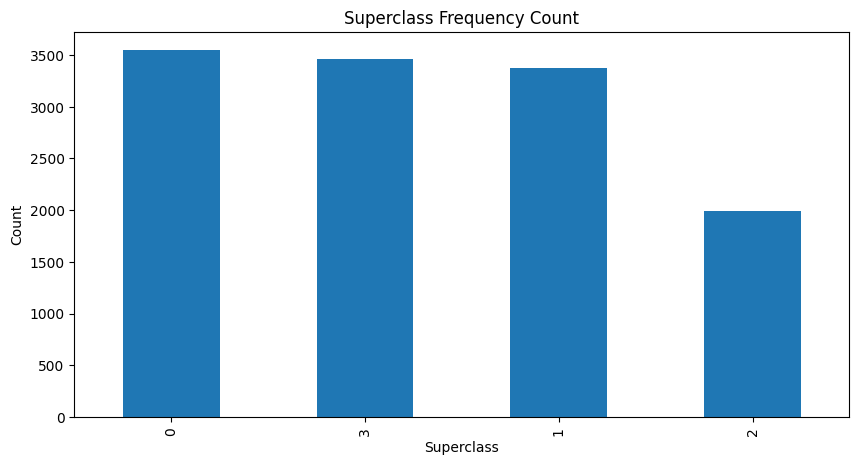

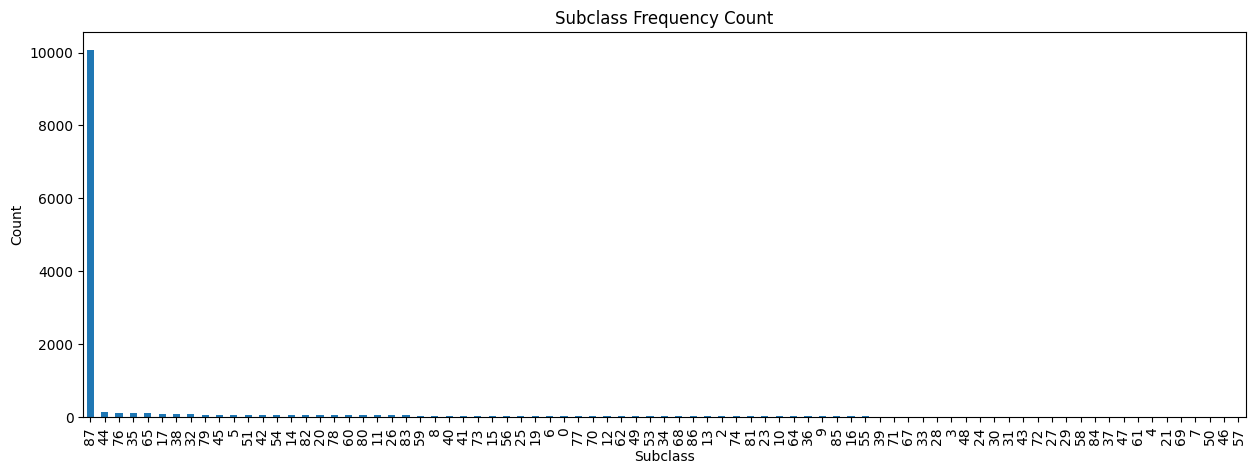

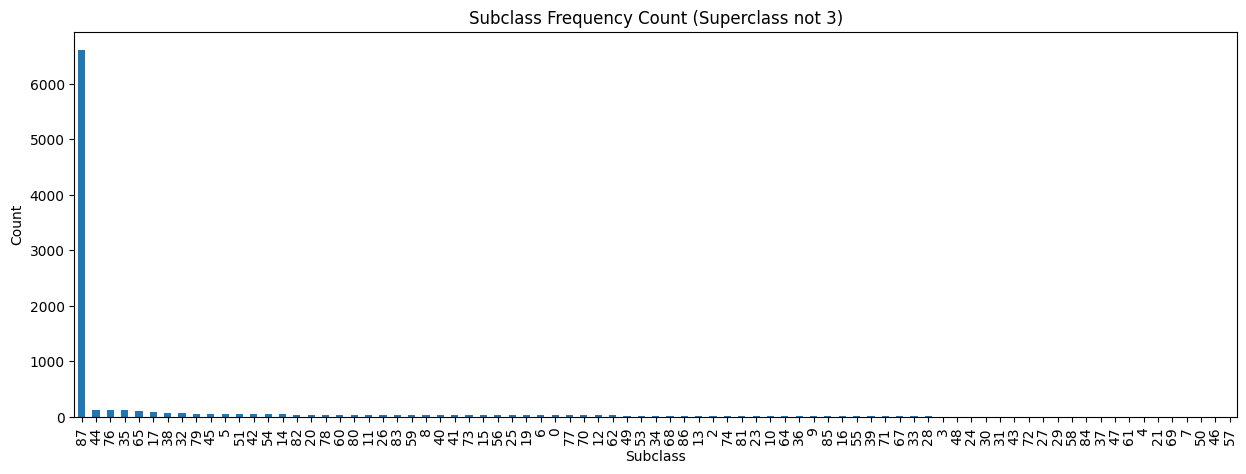

In [ ]:
# Create a DataFrame for superclass predictions
superclass_df = pd.DataFrame({'ID': labels_list, 'Target': superclass_predictions_list})

# Create a DataFrame for subclass predictions
subclass_df = pd.DataFrame({'ID': labels_list, 'Target': subclass_predictions_list})


# Save DataFrames to CSV files
superclass_df.to_csv('superclass_predictions.csv', index=False)
subclass_df.to_csv('subclass_predictions.csv', index=False)

# Assuming you have created superclass_df and subclass_df

# Display frequency count chart for superclass_df
superclass_counts = superclass_df['Target'].value_counts()
plt.figure(figsize=(10, 5))  # Adjust the width (10) and height (5) as needed
superclass_counts.plot(kind='bar', title='Superclass Frequency Count')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

# Display frequency count chart for subclass_df
subclass_counts = subclass_df['Target'].value_counts()
plt.figure(figsize=(15, 5))  # Adjust the width (10) and height (5) as needed
subclass_counts.plot(kind='bar', title='Subclass Frequency Count')
plt.xlabel('Subclass')
plt.ylabel('Count')
plt.show()

# Display frequency count chart for subclass_df only when superclass prediction was not 3
subclass_counts_filtered = subclass_df[subclass_df['ID'].isin(superclass_df[superclass_df['Target'] != 3]['ID'])]['Target'].value_counts()
plt.figure(figsize=(15, 5))  # Adjust the width (15) and height (5) as needed
subclass_counts_filtered.plot(kind='bar', title='Subclass Frequency Count (Superclass not 3)')
plt.xlabel('Subclass')
plt.ylabel('Count')
plt.show()

# Experimental stuff

In [ ]:
! ls dataset/val/0/11

2955.jpg  3071.jpg  3133.jpg  354.jpg  4935.jpg


In [ ]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

# load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-tiny-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-coco")

model.to(device)



image = Image.open('dataset/val/0/11/3133.jpg')
inputs = feature_extractor(images=image, return_tensors="pt")
inputs.to(device)



outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits


# you can pass them to feature_extractor for postprocessing
result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
predicted_panoptic_map = result["segmentation"]


`label_ids_to_fuse` unset. No instance will be fused.


In [ ]:
print(predicted_panoptic_map.shape)


torch.Size([32, 32])


In [ ]:
print(image.size)

(32, 32)


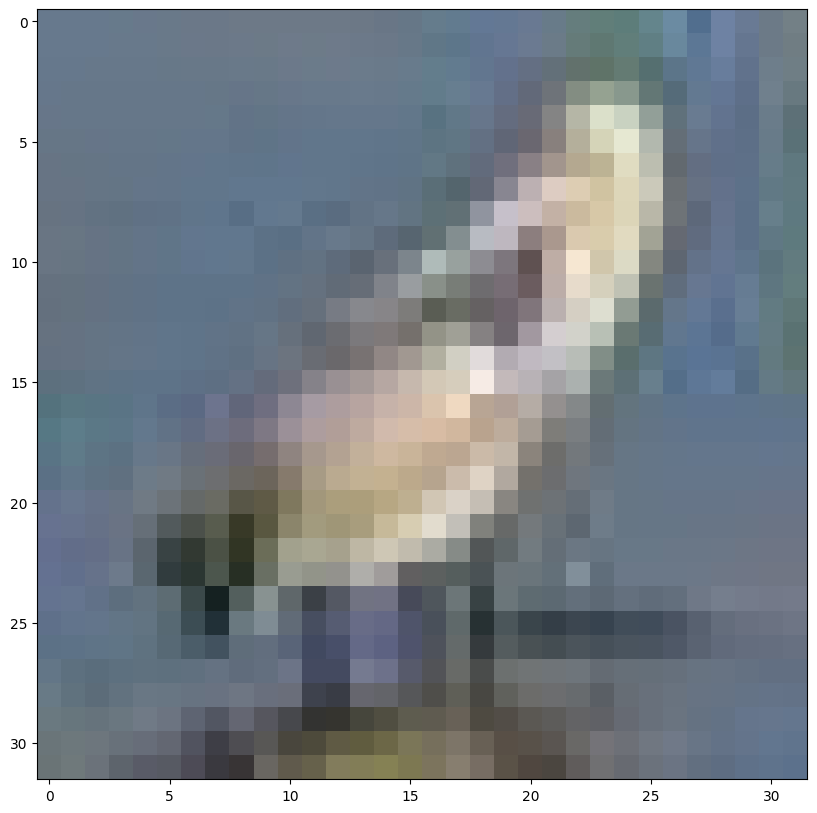

In [ ]:

plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

In [ ]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

palette = color_palette()


In [ ]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

def segment_image(img, feature_extractor, model):
    #image = Image.open(img)
    image= img
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = model(**inputs)
    result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    # we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
    predicted_panoptic_map = result["segmentation"]
    color_segmentation_map = np.zeros((predicted_panoptic_map.shape[0], predicted_panoptic_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    ground_truth_color_seg = color_segmentation_map[..., ::-1]
    for label, color in enumerate(palette):
        color_segmentation_map[predicted_panoptic_map.cpu() - 1 == label, :] = color
    img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
    return Image.fromarray(img.astype(np.uint8))



# load MaskFormer fine-tuned on COCO panoptic segmentation
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-coco")
model.to(device)
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-tiny-coco")

`label_ids_to_fuse` unset. No instance will be fused.


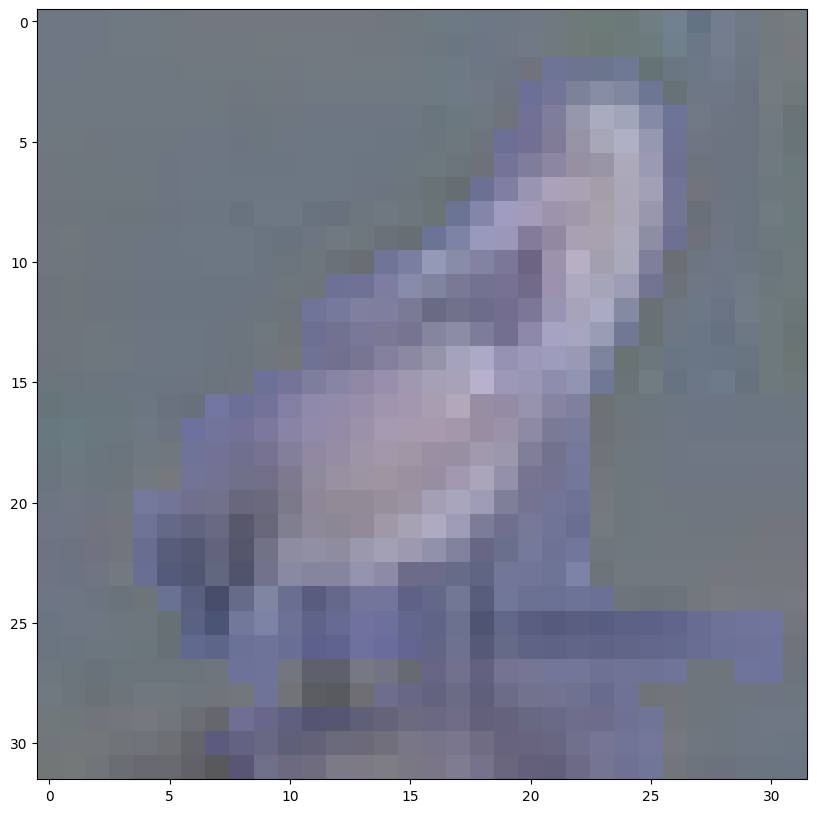

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img = segment_image(image, feature_extractor, model)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
print(masks_queries_logits.shape)

torch.Size([1, 100, 200, 200])


In [ ]:
print(outputs.keys())

odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])


In [ ]:
outputs['masks_queries_logits'].shape

torch.Size([1, 100, 200, 200])

In [ ]:
for row in masks_queries_logits.tolist():
  print(row)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-base-22k-224")
model.classifier.in_features

1024

In [ ]:
num_features = 32

batch_size, num_queries, height, width = masks_queries_logits.size()

conv_layer = nn.Conv2d(num_queries, num_features, kernel_size=3, stride=1, padding=1)


conv_output = conv_layer(masks_queries_logits.cpu())


In [ ]:
conv_output.shape

torch.Size([1, 32, 200, 200])

In [ ]:
    resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [ ]:
resnet(masks_queries_logits)

ValueError: ignored

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class CustomResNet18(nn.Module):
    def __init__(self, num_features, num_channels=100):
        super(CustomResNet18, self).__init__()

        # Adjust the first layer to accept the specified number of channels
        self.conv1 = nn.Conv2d(num_channels, 3, kernel_size=7, stride=2, padding=3, bias=False)

        # Load the pre-trained ResNet-18 model
        resnet = resnet18(pretrained=True)

        # Use only the feature extraction layers (excluding the classifier)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Define a linear layer to reduce the number of features to the desired output
        self.fc = nn.Linear(512, num_features)

    def forward(self, masks_queries_logits):
        # Forward pass through the modified ResNet-18
        x = self.conv1(masks_queries_logits)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Example usage:
num_channels = 100  # Assuming masks_queries_logits are single-channel masks
num_features = 256  # Change this to the desired number of features
resnet_model = CustomResNet18(num_features)

# Forward pass
output_features = resnet_model(masks_queries_logits.cpu())

# Print the output shape
print("Output Features Shape:", output_features.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output Features Shape: torch.Size([1, 256])


In [ ]:
def count_files_in_subdirectories(root_folder):
    subdirectories = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]
    counts = {}

    for subdir in subdirectories:
        subdir_path = os.path.join(root_folder, subdir)
        file_count = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
        counts[subdir] = file_count

    return counts

# Specify the paths to the train and val directories
train_path = 'dataset/train'
val_path = 'dataset/val'

# Count files in subdirectories for train and val
train_counts = count_files_in_subdirectories(train_path)
val_counts = count_files_in_subdirectories(val_path)

In [ ]:
print(val_counts)

{'1': 0, '0': 0, '3': 0, '2': 0}


# Try Mapping Frequencies of classes

In [ ]:
# Step 2: Read CSV file
csv_path = 'drive/MyDrive/DL/enlarged_train_data.csv' if USE_ENLARGED else 'drive/MyDrive/DL/train_data.csv'
df = pd.read_csv(csv_path)

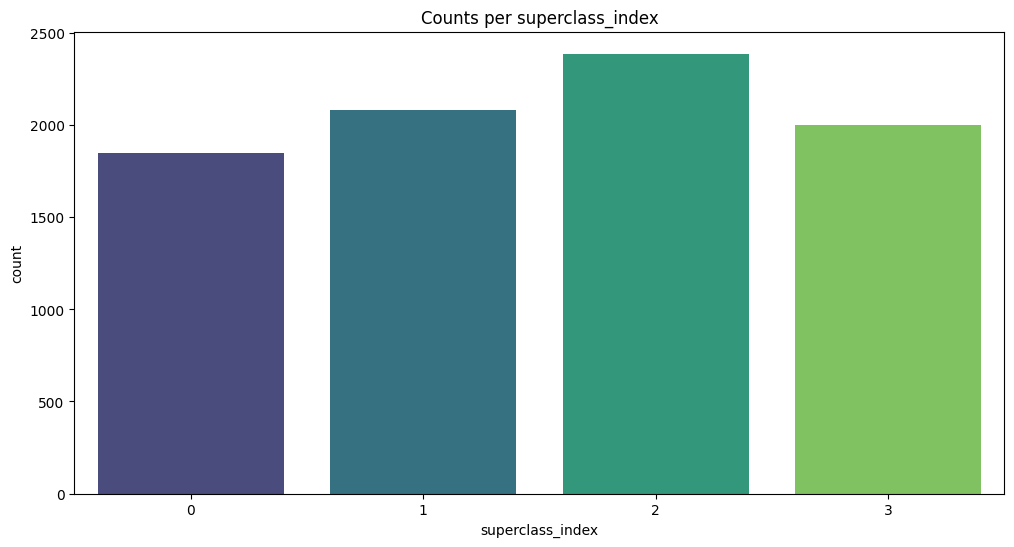

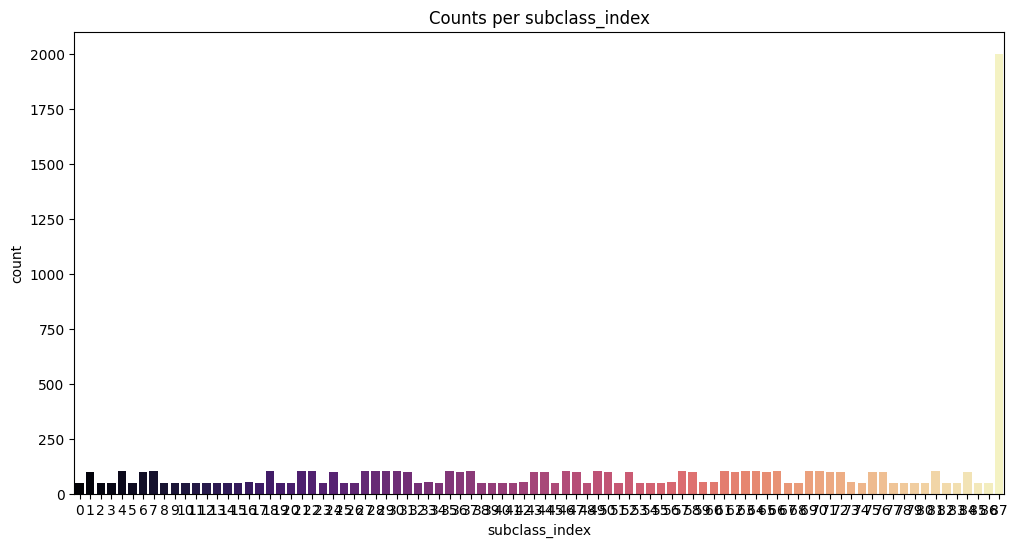

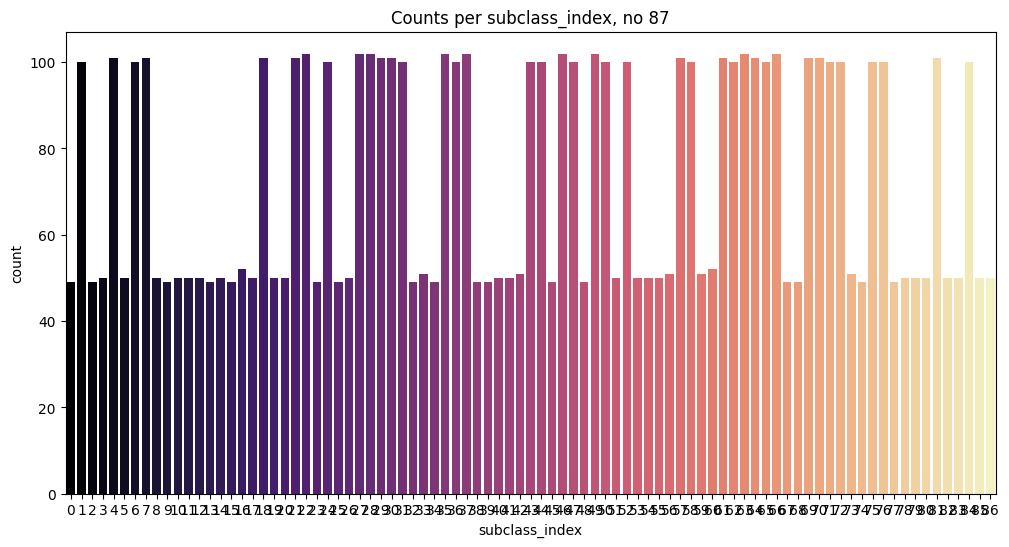

In [ ]:

# Plot counts per superclass_index
plt.figure(figsize=(12, 6))
sns.countplot(x='superclass_index', data=df, palette='viridis')
plt.title('Counts per superclass_index')
plt.show()

# Plot counts per subclass_index
plt.figure(figsize=(12, 6))
sns.countplot(x='subclass_index', data=df, palette='magma')
plt.title('Counts per subclass_index')
plt.show()

df_filtered = df[df['subclass_index'] != 87]

# Plot counts per subclass_index
plt.figure(figsize=(12, 6))
sns.countplot(x='subclass_index', data=df_filtered, palette='magma')
plt.title('Counts per subclass_index, no 87')
plt.show()

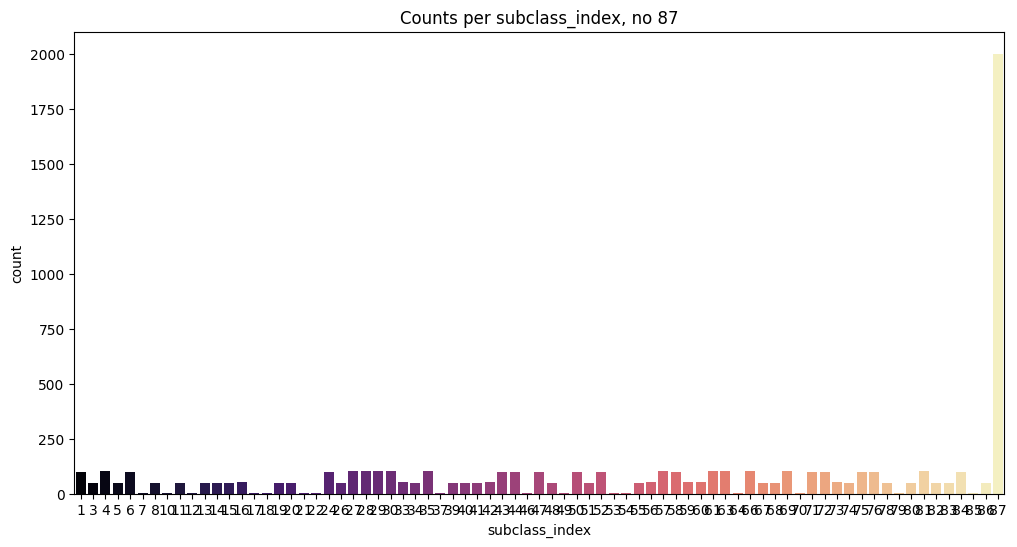

In [ ]:
df_filtered = df[(df['subclass_index'] != 87) & df['superclass_index'] == 0 ]

# Plot counts per subclass_index
plt.figure(figsize=(12, 6))
sns.countplot(x='subclass_index', data=df_filtered, palette='magma')
plt.title('Counts per subclass_index, no 87')
plt.show()

50      17
100     14
1       12
49       8
101      7
102      5
51       5
2        4
52       2
2001     1
Name: subclass_index, dtype: int64


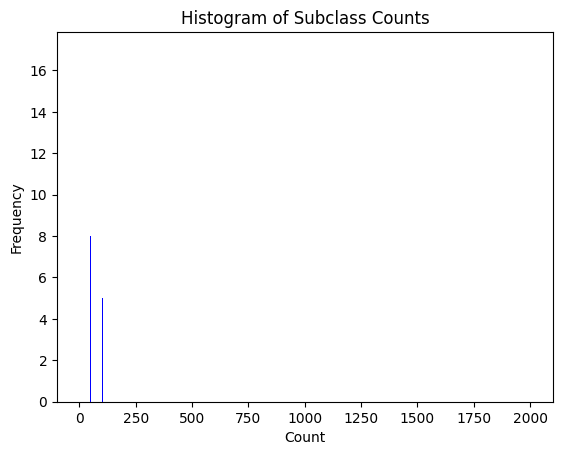

In [ ]:
count_frequencies = df_filtered['subclass_index'].value_counts()

count_frequencies = count_frequencies.value_counts()

print(count_frequencies)

# Get max and min subclass counts

# Generate histogram
plt.bar(count_frequencies.index, count_frequencies.values, color='blue')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Subclass Counts')
plt.show()

In [ ]:
df_filtered = df[(df['subclass_index'] != 87) & (df['superclass_index'] ==0) ]
count_frequencies = df_filtered['subclass_index'].value_counts()
filtered_counts = count_frequencies[count_frequencies > 5]
print(filtered_counts)

75    100
28    100
24    100
4     100
84    100
30    100
6     100
27    100
51     50
86     50
82     50
56     50
26     50
5      50
14     50
11     50
73     50
42     50
80     50
8      50
59     50
40     50
16     50
78     50
60     50
19     50
20     50
41     50
83     50
Name: subclass_index, dtype: int64


In [ ]:
import os
import random
from shutil import copyfile
from tqdm import tqdm

image_transform = v2.Compose([
    # Add your transformations here
    v2.RandomAffine(degrees=360),
    v2.RandomGrayscale(),
    v2.RandomInvert(.2),
])

def balance_dataset(dataset_root, target_num_images):
    balanced_root = dataset_root + '_balanced'

    for split in ['train', 'val']:
        split_root = os.path.join(dataset_root, split)
        balanced_split_root = os.path.join(balanced_root, split)

        # Create the balanced split directory
        os.makedirs(balanced_split_root, exist_ok=True)

        # Iterate through superclass folders
        for superclass_folder in os.listdir(split_root):
            superclass_path = os.path.join(split_root, superclass_folder)
            balanced_superclass_path = os.path.join(balanced_split_root, superclass_folder)

            # Create the balanced superclass directory
            os.makedirs(balanced_superclass_path, exist_ok=True)

            # Iterate through subclass folders
            for subclass_folder in os.listdir(superclass_path):
                subclass_path = os.path.join(superclass_path, subclass_folder)
                balanced_subclass_path = os.path.join(balanced_superclass_path, subclass_folder)

                # Create the balanced subclass directory
                os.makedirs(balanced_subclass_path, exist_ok=True)

                # Count the number of images in the subclass
                num_images = len(os.listdir(subclass_path))

                # Copy original images to balanced folder
                for image_file in os.listdir(subclass_path):
                    image_path = os.path.join(subclass_path, image_file)
                    copyfile(image_path, os.path.join(balanced_subclass_path, image_file))

                # Generate new images if needed
                if num_images < target_num_images:
                    images_to_generate = target_num_images - num_images

                    # Randomly choose images from the original set for transformation
                    images_to_transform = random.choices(os.listdir(subclass_path), k=images_to_generate)

                    for image_file in tqdm(images_to_transform, desc=f'Balancing {split}/{superclass_folder}/{subclass_folder}'):
                        original_path = os.path.join(subclass_path, image_file)
                        transformed_path = os.path.join(balanced_subclass_path, f'{image_file.split(".")[0]}_transformed.jpg')

                        img = Image.open(original_path)

                        # Apply transformations
                        transformed_img = image_transform(img)

                        # Perform the image transformation
                        # Save the transformed image
                        new_image_file = f"{os.path.splitext(image_file)[0]}_transformed.jpg"
                        new_image_path = os.path.join(balanced_root, split, superclass_folder, subclass_folder, new_image_file)

                        # Save the transformed image
                        transformed_img.save(new_image_path)

balance_dataset(dataset_root, 120)

In [ ]:
def get_directory_file_counts(directory, recursive=True):
    file_counts = Counter()

    for root, dirs, files in os.walk(directory):
        if not dirs:
            # If there are no subdirectories, count the files in the current directory
            file_counts[root] += len(files)
        elif not recursive:
            # If not recursive, do not enter subdirectories
            dirs.clear()

    return file_counts

# Example usage:
directory_path = 'dataset_balanced/train'
file_counts = get_directory_file_counts(directory_path)

# Print or use the counts as needed
for path, count in file_counts.items():
    print(f"{path}: {count} files")

In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

# Step 1: Extract images from the ZIP file
zip_path =  'drive/MyDrive/DL/enlarged_train_shuffle.zip' if USE_ENLARGED else 'drive/MyDrive/DL/train_shuffle.zip'
extract_folder = 'images'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 2: Read CSV file
csv_path = 'drive/MyDrive/DL/enlarged_train_data.csv' if USE_ENLARGED else 'drive/MyDrive/DL/train_data.csv'
df = pd.read_csv(csv_path)
# Identify combinations with frequency less than 5 and relabel as 87
combinations_frequencies = df.groupby(['superclass_index', 'subclass_index']).size().reset_index(name='count')
threshold = 5
combinations_to_relabel = combinations_frequencies[combinations_frequencies['count'] < threshold]
df.loc[df.set_index(['superclass_index', 'subclass_index']).index.isin(combinations_to_relabel.set_index(['superclass_index', 'subclass_index']).index), 'subclass_index'] = 87








# Step 3: Split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Step 4: Create folder structure for training set
dataset_root = 'dataset'
train_root = os.path.join(dataset_root, 'train')
os.makedirs(train_root, exist_ok=True)

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc='Creating Training Folder Structure'):
    image_path = os.path.join(extract_folder, row['image']) if USE_ENLARGED else os.path.join(extract_folder, "train_shuffle", row['image'])
    superclass = str(row['superclass_index'])
    subclass = str(row['subclass_index'])

    # Create superclass folder if not exists
    superclass_folder = os.path.join(train_root, superclass)
    os.makedirs(superclass_folder, exist_ok=True)

    # Create subclass folder if not exists
    subclass_folder = os.path.join(superclass_folder, subclass)
    os.makedirs(subclass_folder, exist_ok=True)

    if SEGMENT:
        segmented_output_path = os.path.join(subclass_folder, row['image'])
        segmented_image = segment_image(image_path, feature_extractor, model)
        segmented_image.save(segmented_output_path)
    else:
        # Move the image to the subclass folder
        # try:
        shutil.move(image_path, subclass_folder)
        # except Exception as e:
        #   pass

# Step 5: Create folder structure for validation set
val_root = os.path.join(dataset_root, 'val')
os.makedirs(val_root, exist_ok=True)

for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc='Creating Validation Folder Structure'):
    image_path = os.path.join(extract_folder, row['image']) if USE_ENLARGED else os.path.join(extract_folder, "train_shuffle", row['image'])

    superclass = str(row['superclass_index'])
    subclass = str(row['subclass_index'])

    # Create superclass folder if not exists
    superclass_folder = os.path.join(val_root, superclass)
    os.makedirs(superclass_folder, exist_ok=True)

    # Create subclass folder if not exists
    subclass_folder = os.path.join(superclass_folder, subclass)
    os.makedirs(subclass_folder, exist_ok=True)

    if SEGMENT:
        segmented_output_path = os.path.join(subclass_folder, row['image'])
        segmented_image = segment_image(image_path, feature_extractor, model)
        segmented_image.save(segmented_output_path)
    else:
        # Move the image to the subclass folder
        # try:
        shutil.move(image_path, subclass_folder)
        # except Exception as e:
        #   pass

print("Folder structure creation complete.")

In [ ]:
import pandas as pd

# Step 2: Read CSV file
csv_path = 'drive/MyDrive/DL/enlarged_train_data.csv' if USE_ENLARGED else 'drive/MyDrive/DL/train_data.csv'
df = pd.read_csv(csv_path)

# Step 3: Calculate frequencies by class and subclass combinations
combinations_frequencies = df.groupby(['superclass_index', 'subclass_index']).size().reset_index(name='count')

# Step 4: Identify combinations with frequency less than 5 and relabel as (0, 87)
threshold = 5
combinations_to_relabel = combinations_frequencies[combinations_frequencies['count'] < threshold]
df.loc[df.set_index(['superclass_index', 'subclass_index']).index.isin(combinations_to_relabel.set_index(['superclass_index', 'subclass_index']).index), 'subclass_index'] = 87

# Print the updated DataFrame
print(df)


         image  superclass_index  subclass_index
0        0.jpg                 1              37
1        1.jpg                 0              42
2        2.jpg                 1              62
3        3.jpg                 1              31
4        4.jpg                 0               4
...        ...               ...             ...
8318  8318.jpg                 3              87
8319  8319.jpg                 3              87
8320  8320.jpg                 3              87
8321  8321.jpg                 3              87
8322  8322.jpg                 3              87

[8323 rows x 3 columns]


In [ ]:
combinations_frequencies = df.groupby(['superclass_index', 'subclass_index']).size().reset_index(name='count')
combinations_frequencies

superclass_index  subclass_index  count
0                  0               4    100
1                  0               5     50
2                  0               6    100
3                  0               8     50
4                  0              11     50
..               ...             ...    ...
84                 2              74     49
85                 2              76    100
86                 2              81    101
87                 2              87     34
88                 3              87   2001

[89 rows x 3 columns]

from matplotlib import pyplot as plt
combinations_frequencies['superclass_index'].plot(kind='hist', bins=20, title='superclass_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combinations_frequencies['subclass_index'].plot(kind='hist', bins=20, title='subclass_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combinations_frequencies['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combinations_frequencies.plot(kind='scatter', x='superclass_index', y='subclass_index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combinations_frequencies.plot(kind='scatter', x='subclass_index', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['superclass_index']
  ys = series['subclass_index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = combinations_frequencies.sort_values('superclass_index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('superclass_index')
_ = plt.ylabel('subclass_index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['superclass_index']
  ys = series['count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = combinations_frequencies.sort_values('superclass_index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('superclass_index')
_ = plt.ylabel('count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['superclass_index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'superclass_index'}, axis=1)
              .sort_values('superclass_index', ascending=True))
  xs = counted['superclass_index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = combinations_frequencies.sort_values('superclass_index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('superclass_index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
combinations_frequencies['superclass_index'].plot(kind='line', figsize=(8, 4), title='superclass_index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
combinations_frequencies['subclass_index'].plot(kind='line', figsize=(8, 4), title='subclass_index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
combinations_frequencies['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Specify the path to the folder you want to delete
folder_path = 'images'

# Delete the folder and its contents
shutil.rmtree(folder_path)

In [ ]:
from PIL import Image
import numpy as np
import random

import os
import shutil
import pandas as pd
from tqdm import tqdm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

# Step 1: Extract images from the ZIP file
zip_path =  'drive/MyDrive/DL/enlarged_train_shuffle.zip' if USE_ENLARGED else 'drive/MyDrive/DL/train_shuffle.zip'
extract_folder = 'images'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 2: Read CSV file
csv_path = 'drive/MyDrive/DL/enlarged_train_data.csv' if USE_ENLARGED else 'drive/MyDrive/DL/train_data.csv'
df = pd.read_csv(csv_path)
# Identify combinations with frequency less than 5 and relabel as 87
combinations_frequencies = df.groupby(['superclass_index', 'subclass_index']).size().reset_index(name='count')
threshold = 5
combinations_to_relabel = combinations_frequencies[combinations_frequencies['count'] < threshold]
df.loc[df.set_index(['superclass_index', 'subclass_index']).index.isin(combinations_to_relabel.set_index(['superclass_index', 'subclass_index']).index), 'subclass_index'] = 87
combinations_frequencies = df.groupby(['superclass_index', 'subclass_index']).size().reset_index(name='count')

image_transform = v2.Compose([
    # Add your transformations here
    v2.RandomAffine(degrees=360),
    v2.RandomGrayscale(),
    v2.RandomInvert(.2),
])

# Set the target number of images for each combination
target_num = 110

new_rows = []

# Iterate over combinations_frequencies
for index, row in tqdm(combinations_frequencies.iterrows(), total=len(combinations_frequencies), desc='Applying Transformations'):
    superclass = row['superclass_index']
    subclass = row['subclass_index']
    count = row['count']

    # Check if the count is less than the target_num
    if count < target_num:
        # Get images for the current combination
        image_files = list(df[(df['superclass_index'] == superclass) & (df['subclass_index'] == subclass)]["image"])
        #print("FILES:", superclass,subclass, count, image_files, )

        for i in range(target_num-count):
            image_file = random.choice(image_files)
            # Load the image
            image_path = os.path.join(extract_folder, image_file)
            image = Image.open(image_path)

            # Apply random transformations
            transformed_image = image_transform(image)

            new_file_name = f'transformed_{i}_{image_file}'

            # Save the transformed image to the images folder
            transformed_image_path = os.path.join(extract_folder, new_file_name)
            transformed_image.save(transformed_image_path)

            # Update the DataFrame with the new image information
            new_row = {'image': new_file_name, 'superclass_index': superclass, 'subclass_index': subclass}
            new_rows.append(new_row)

df = pd.concat([df, pd.DataFrame.from_records(new_rows)])

# Print the updated DataFrame
df

Applying Transformations: 100%|██████████| 89/89 [00:02<00:00, 38.73it/s]


image  superclass_index  subclass_index
0                       0.jpg                 1              37
1                       1.jpg                 0              42
2                       2.jpg                 1              62
3                       3.jpg                 1              31
4                       4.jpg                 0               4
...                       ...               ...             ...
3353  transformed_71_1922.jpg                 2              87
3354  transformed_72_5726.jpg                 2              87
3355  transformed_73_3743.jpg                 2              87
3356  transformed_74_3099.jpg                 2              87
3357  transformed_75_3743.jpg                 2              87

[11681 rows x 3 columns]

from matplotlib import pyplot as plt
df['superclass_index'].plot(kind='hist', bins=20, title='superclass_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['subclass_index'].plot(kind='hist', bins=20, title='subclass_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='superclass_index', y='subclass_index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['superclass_index'].plot(kind='line', figsize=(8, 4), title='superclass_index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['subclass_index'].plot(kind='line', figsize=(8, 4), title='subclass_index')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
combinations_frequencies = df.groupby(['superclass_index', 'subclass_index']).size().reset_index(name='count')
combinations_frequencies

superclass_index  subclass_index  count
0                  0               4    110
1                  0               5    110
2                  0               6    110
3                  0               8    110
4                  0              11    110
..               ...             ...    ...
84                 2              74    110
85                 2              76    110
86                 2              81    110
87                 2              87    110
88                 3              87   2001

[89 rows x 3 columns]

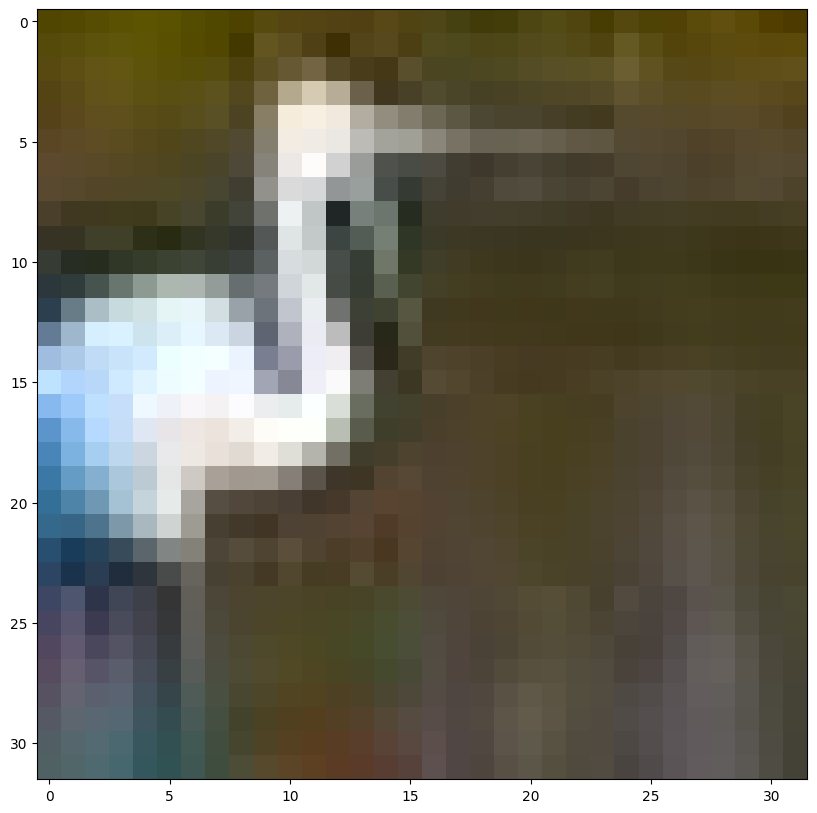

In [ ]:
image = Image.open('dataset/test/0/0/10111.jpg')

plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

In [ ]:
image = Image.open('dataset/train/2/52/1655_transformed_2_1655.jpg')

plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

FileNotFoundError: ignored

# Try Cleaning Data

In [ ]:
# Step 1: Extract images from the ZIP file
zip_path =  'drive/MyDrive/DL/enlarged_train_shuffle.zip' if USE_ENLARGED else 'drive/MyDrive/DL/train_shuffle.zip'
extract_folder = 'images'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 2: Read CSV file
csv_path = 'drive/MyDrive/DL/enlarged_train_data.csv' if USE_ENLARGED else 'drive/MyDrive/DL/train_data.csv'
df = pd.read_csv(csv_path)

In [ ]:
transform = v2.Compose([
  v2.ToImage(),
  #v2.Resize(size=(224,224), antialias=True),  # Or Resize(antialias=True)
  v2.RandomHorizontalFlip(.33),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
def print_images(subclass, df, path = "images/", label="image", target="subclass_index"):
  temp = df[df[target] == subclass]
  for image_path in temp[label]:
    image = Image.open(f'{path}{image_path}')
    transformed = transform(image)
    transformed_image_np = transformed.numpy().transpose(1, 2, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image {}'.format(image_path))

    # Transformed image
    axes[1].imshow(transformed_image_np)
    axes[1].set_title('Transformed Image {}'.format(image_path))

    # Display the images
    plt.show()

In [ ]:
print_images(44, df)

NameError: ignored

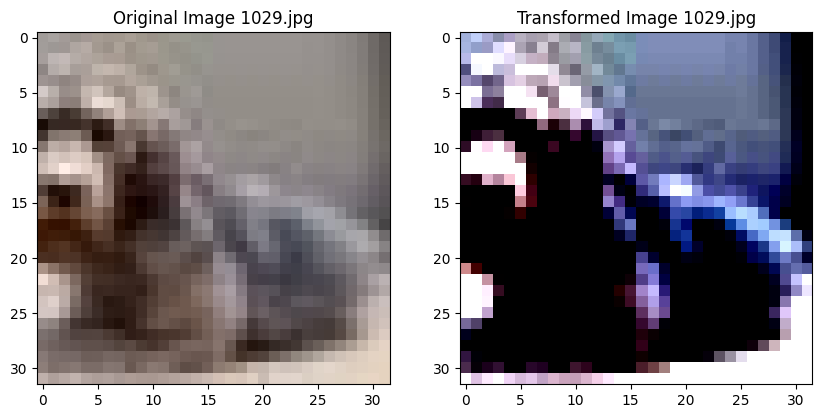

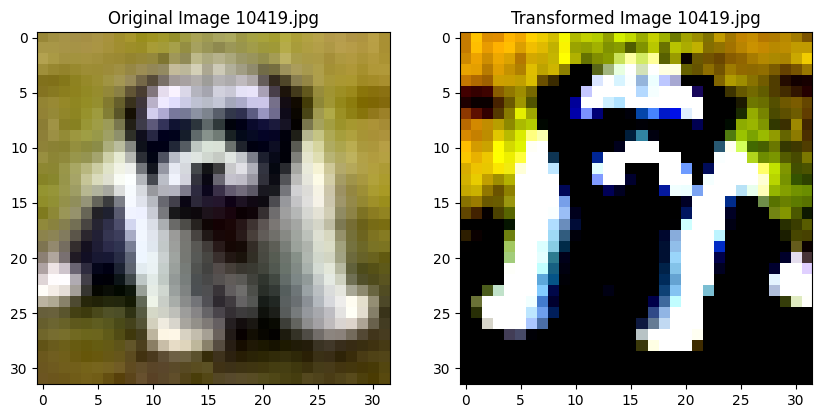

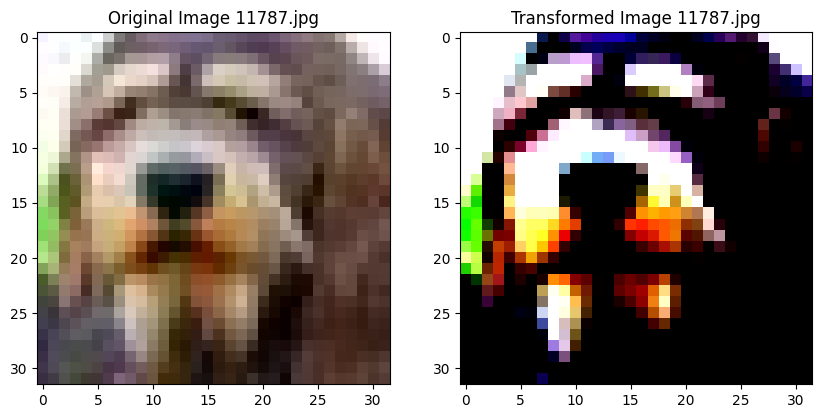

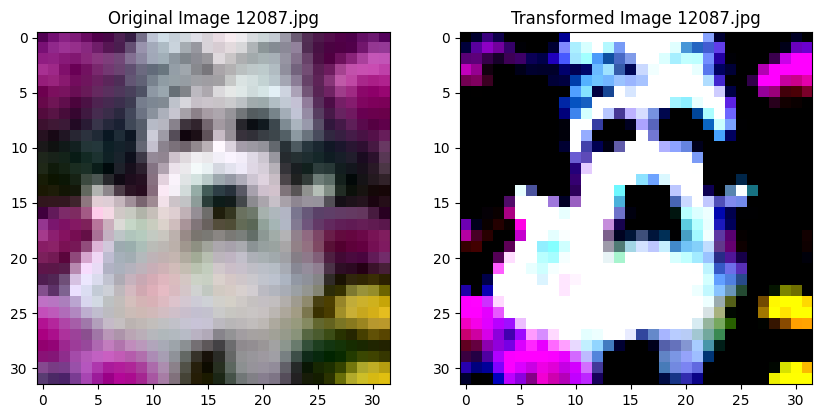

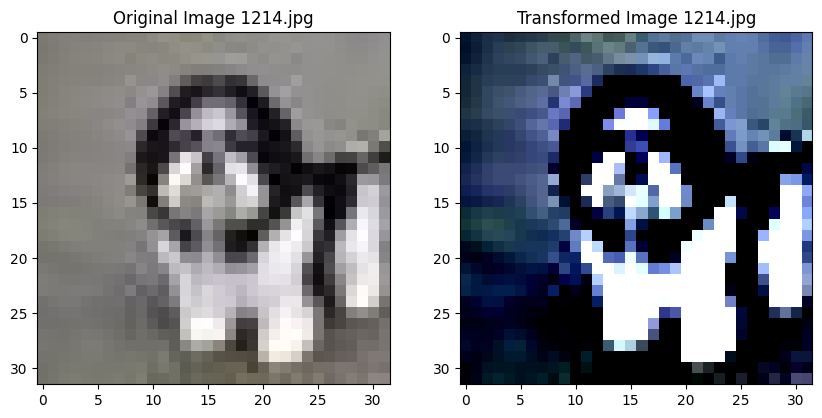

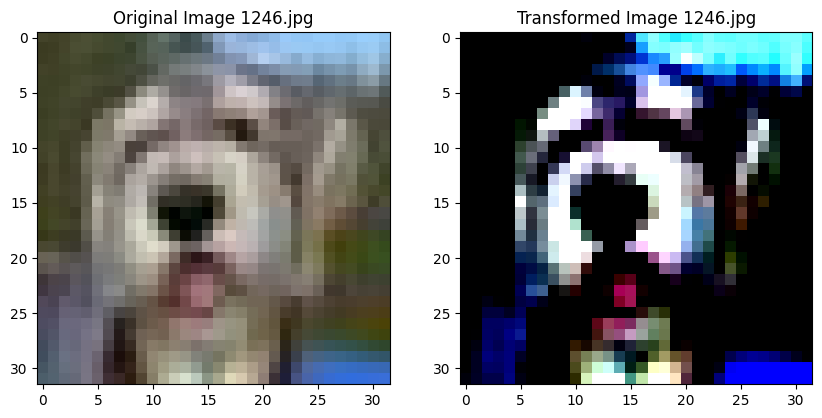

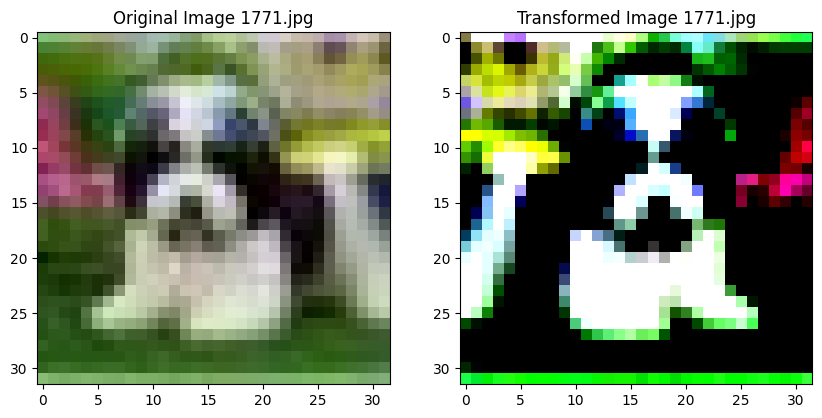

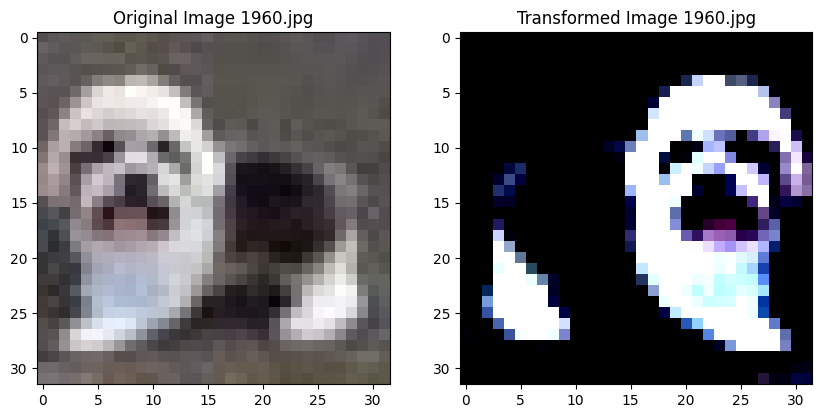

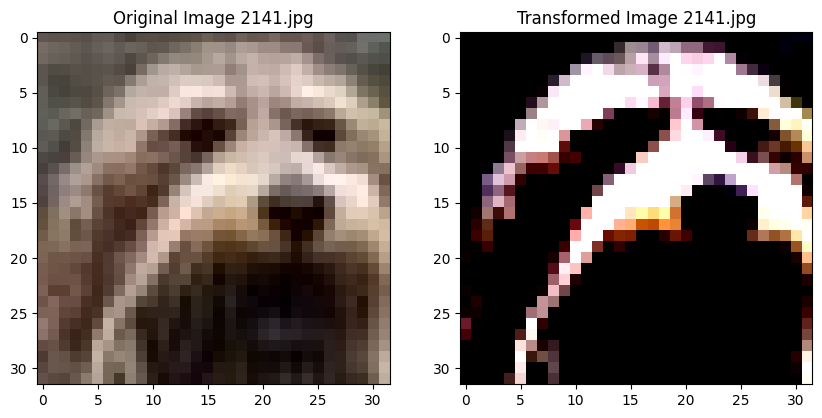

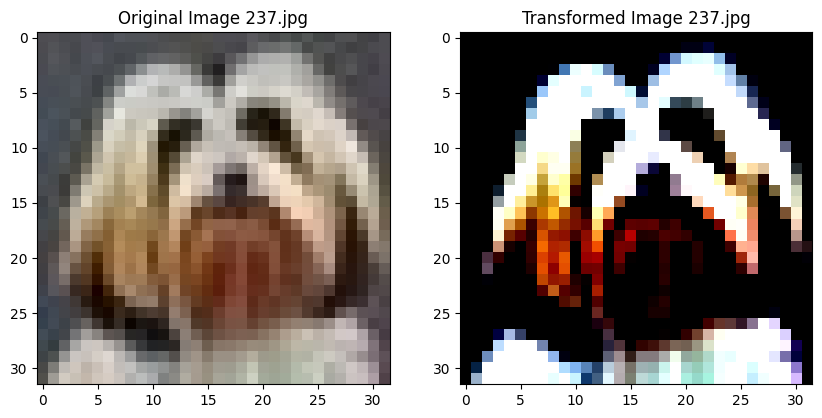

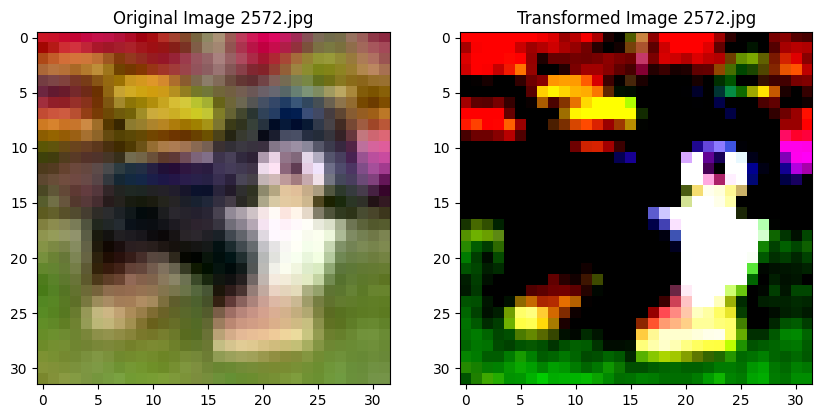

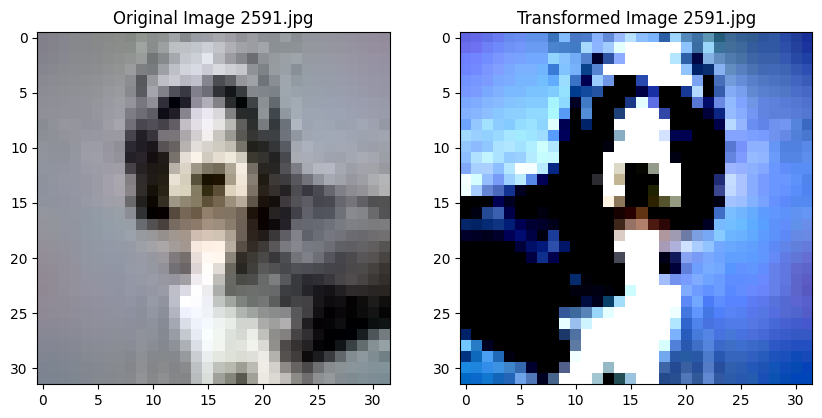

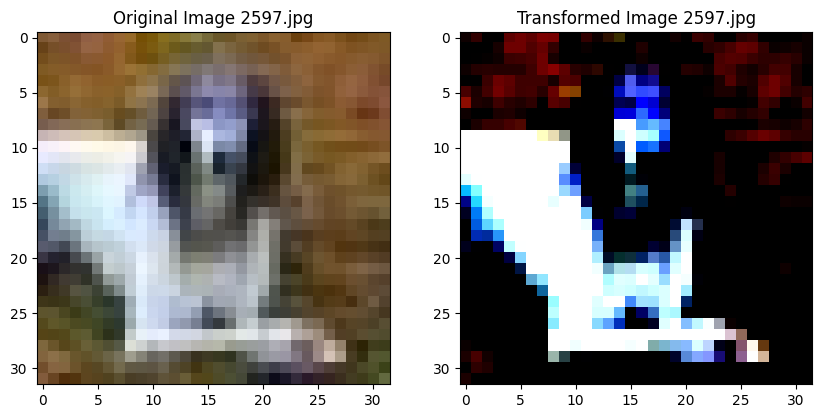

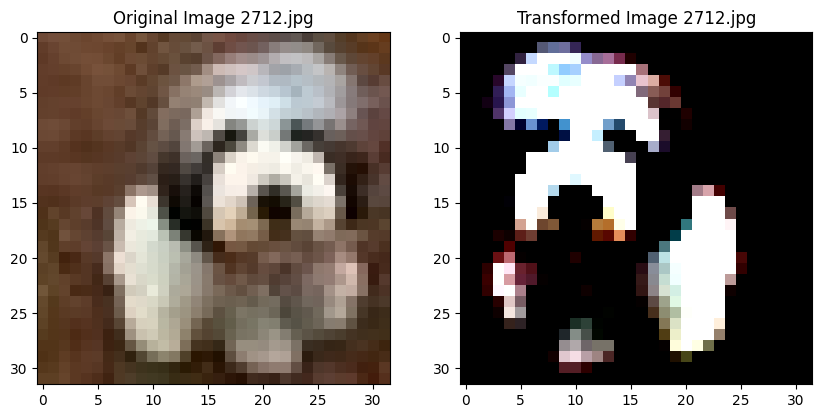

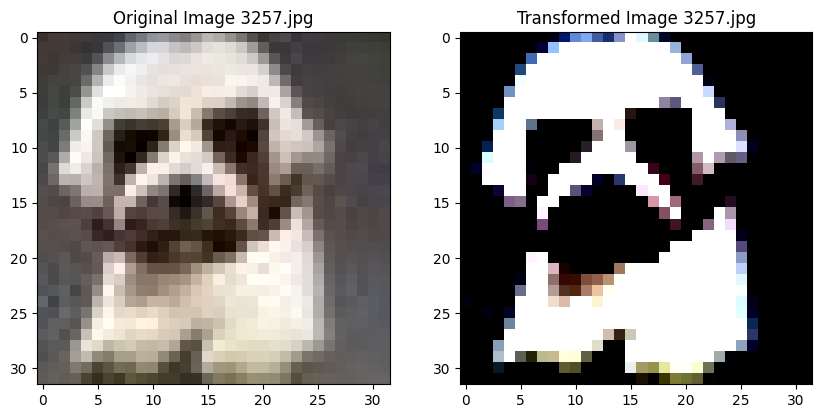

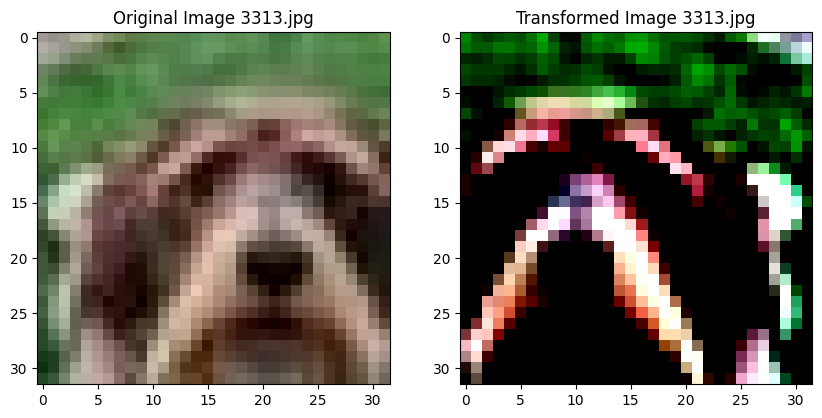

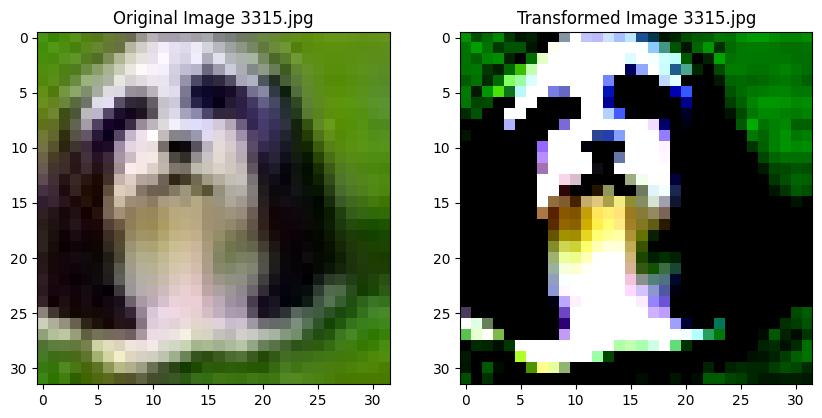

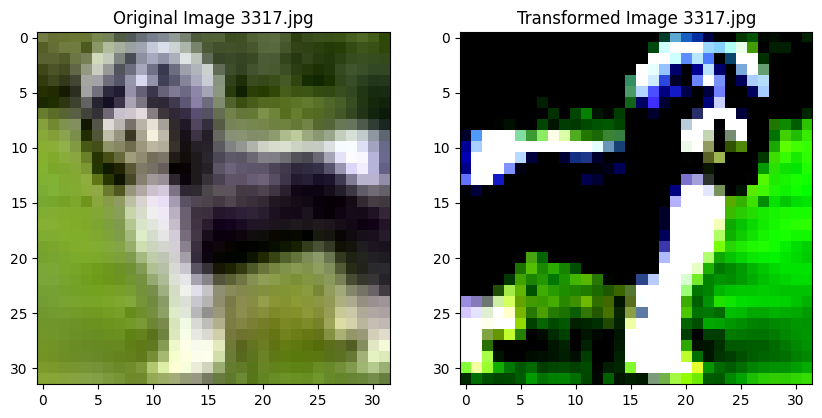

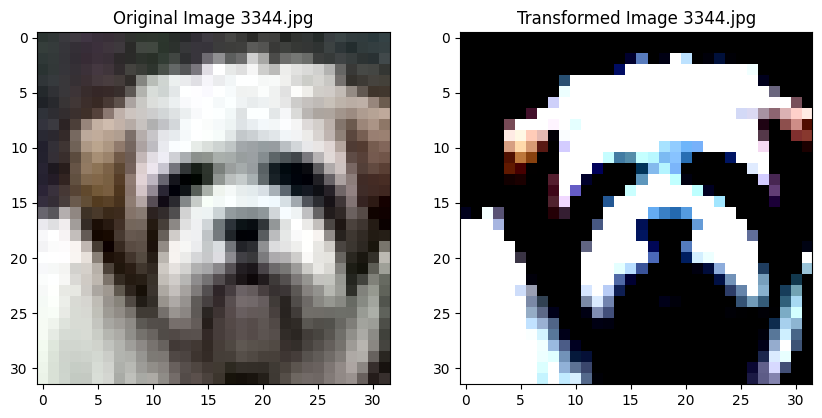

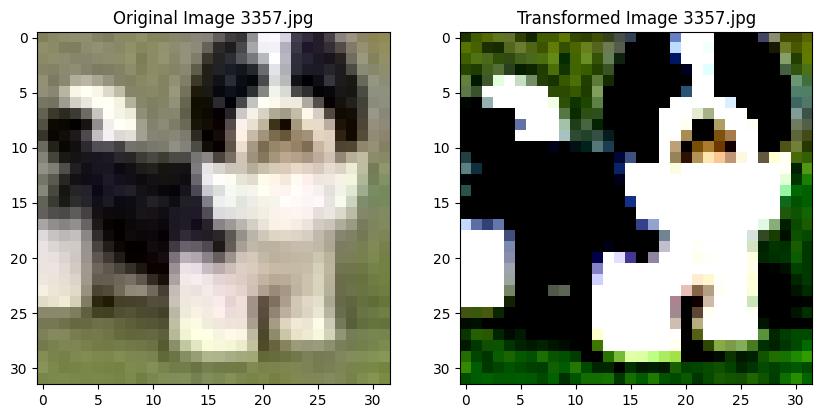

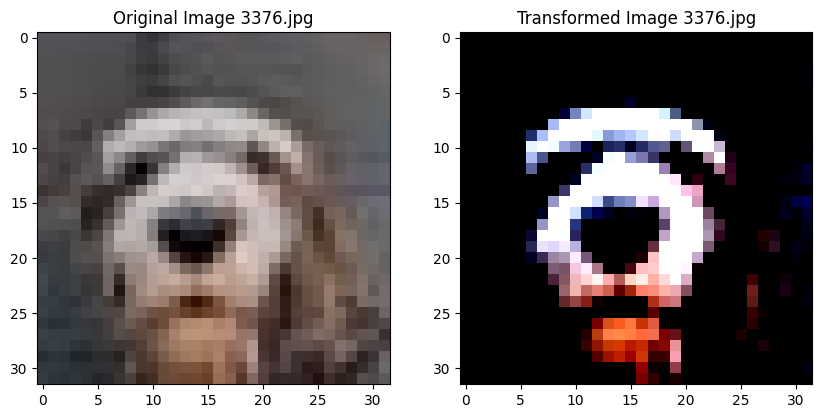

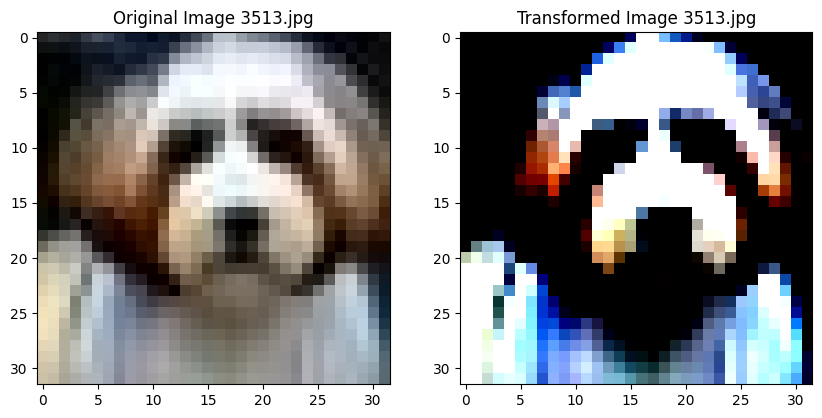

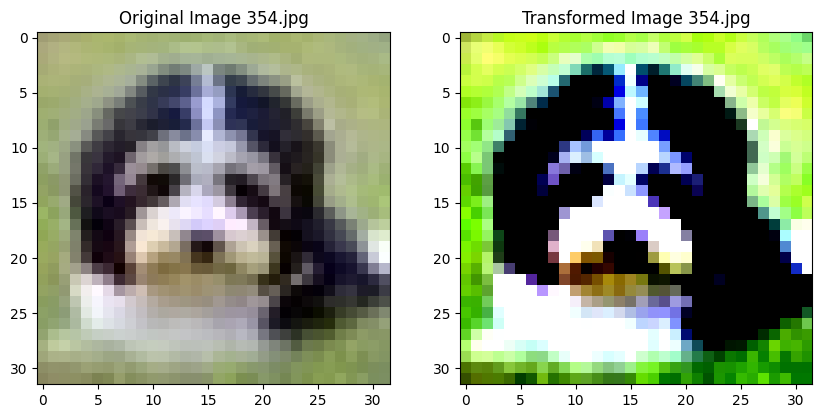

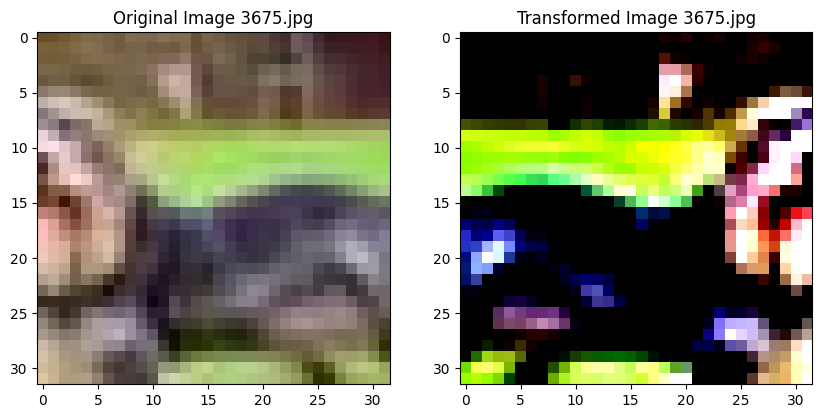

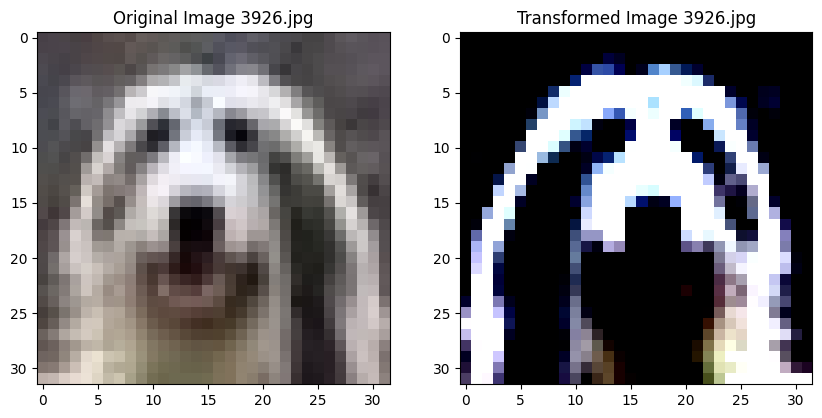

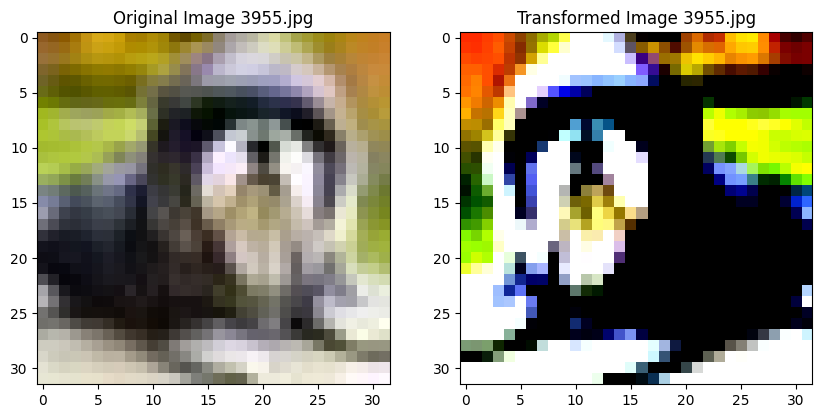

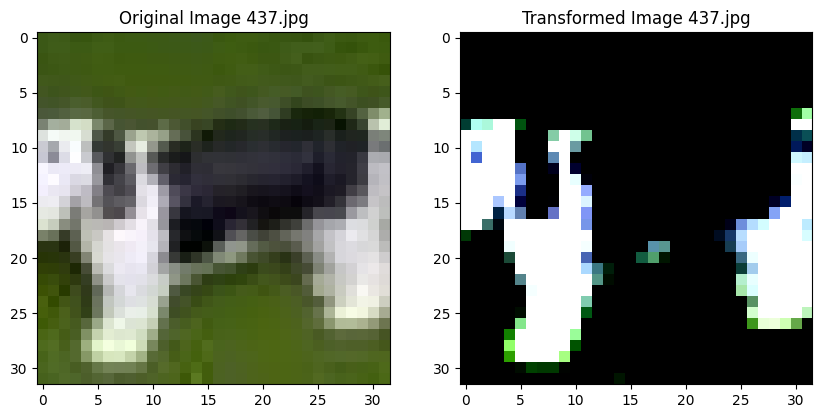

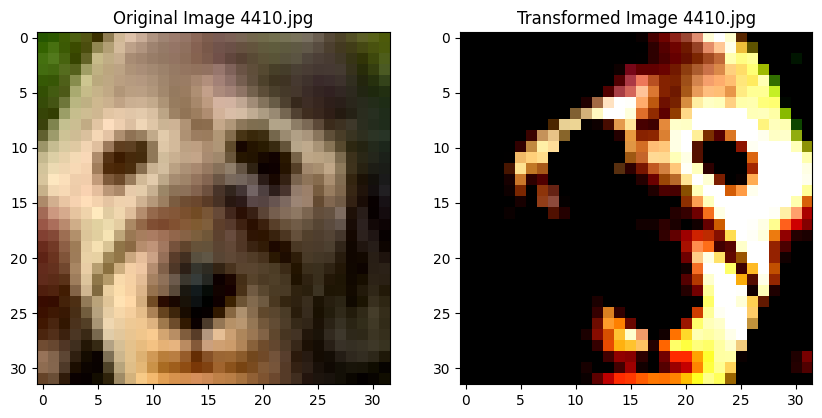

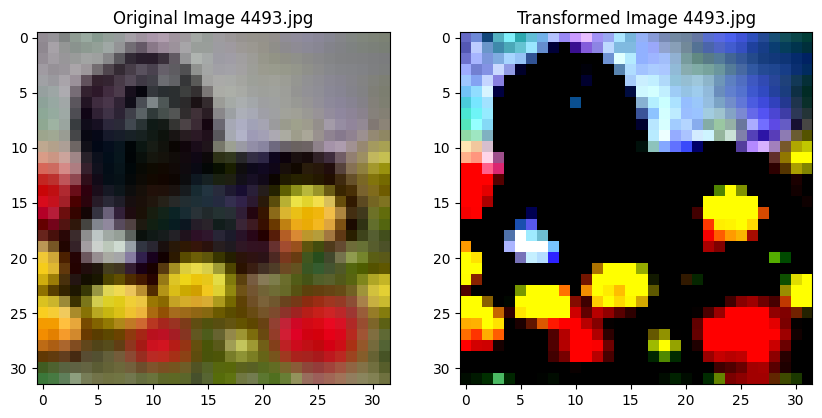

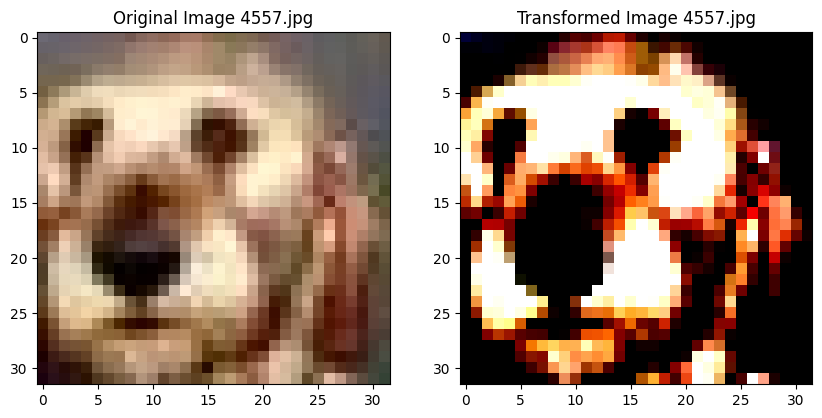

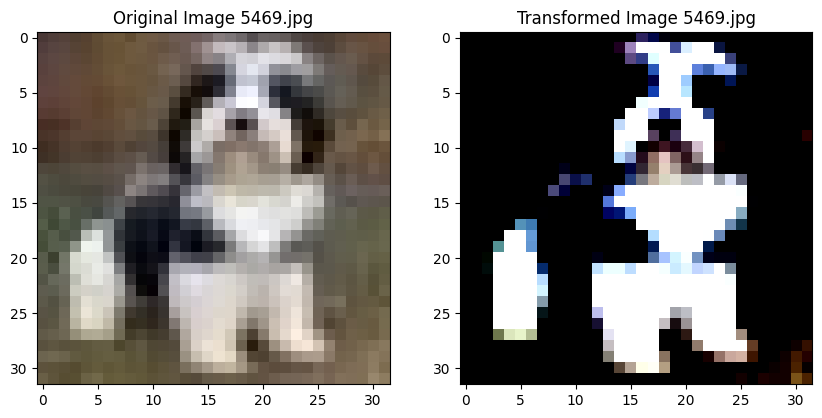

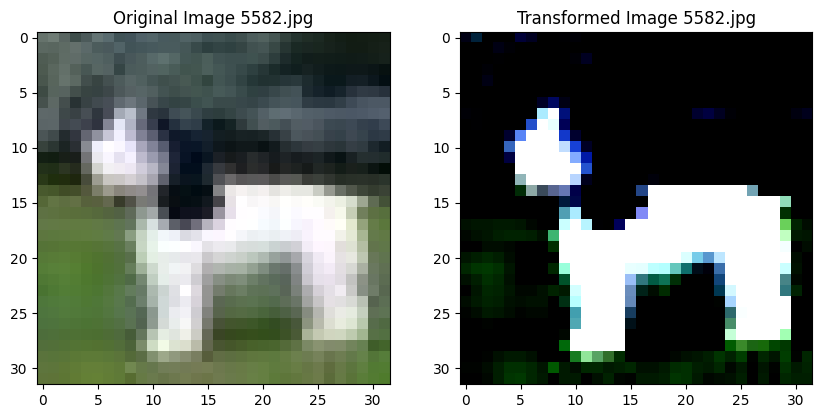

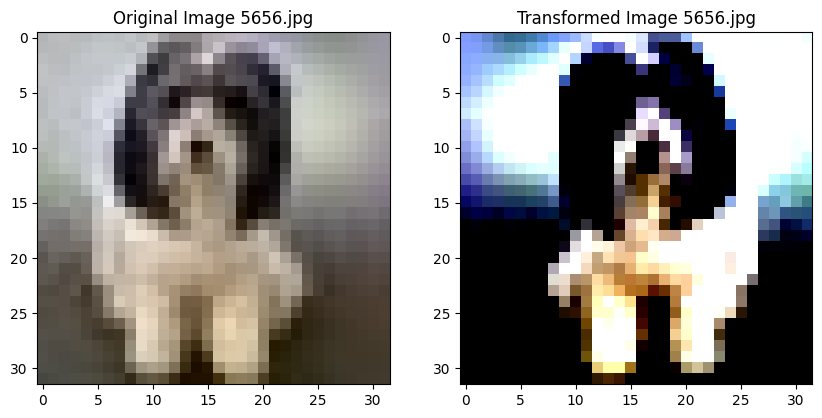

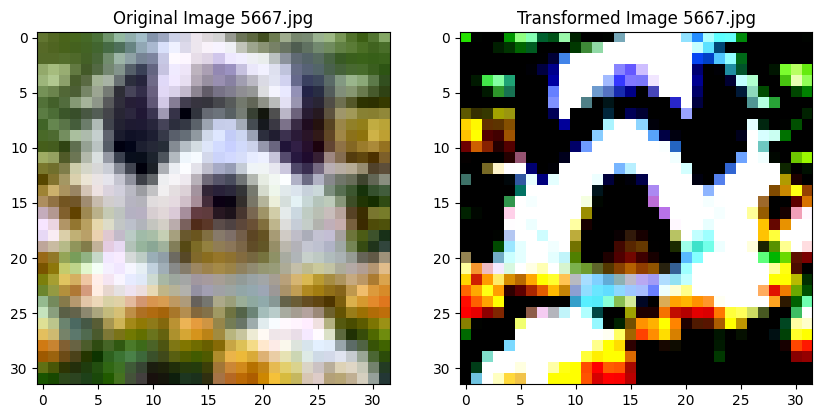

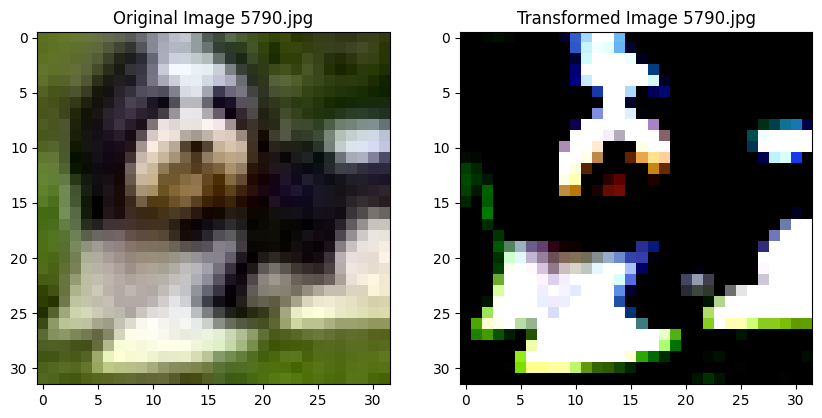

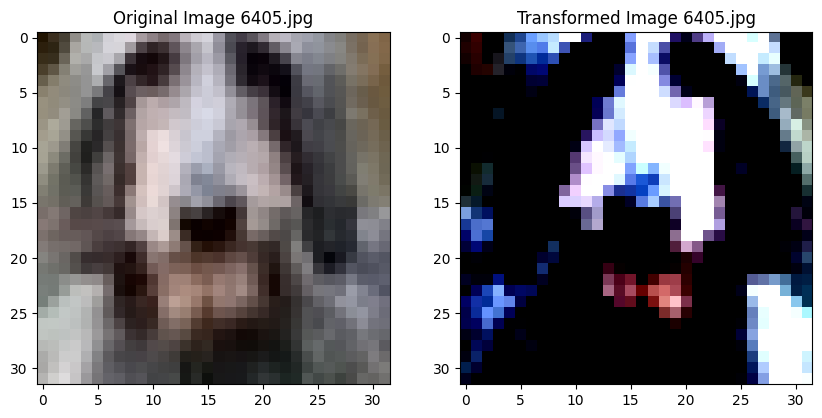

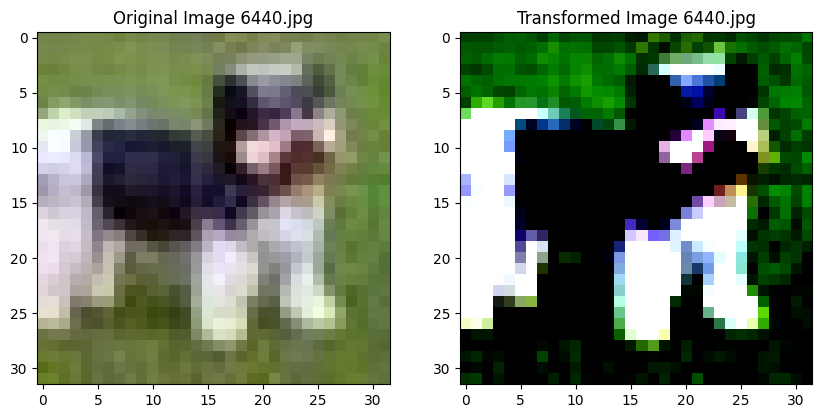

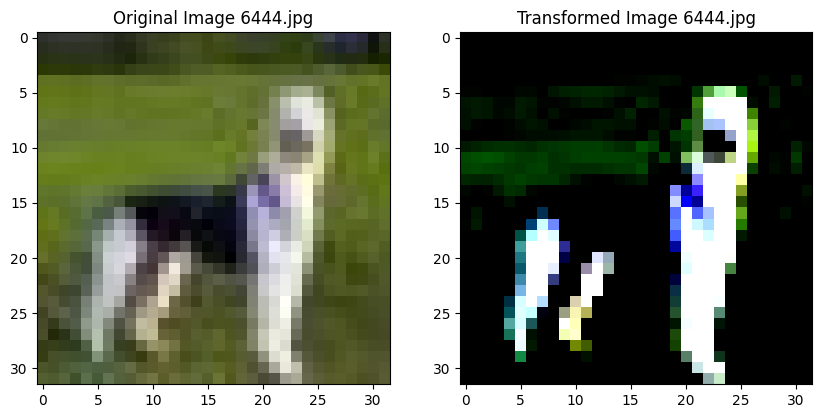

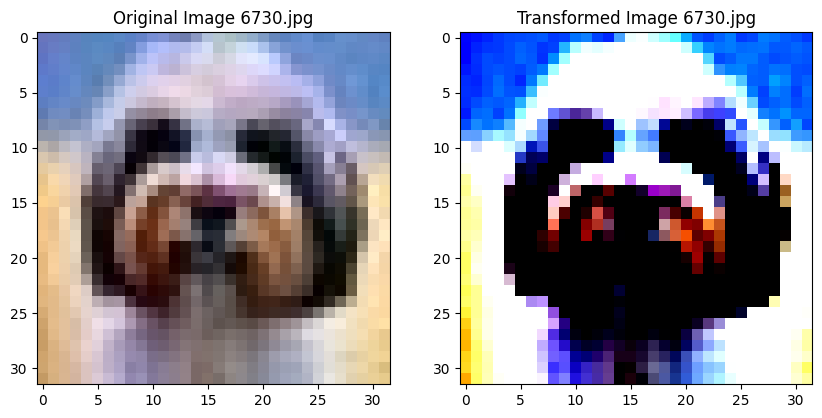

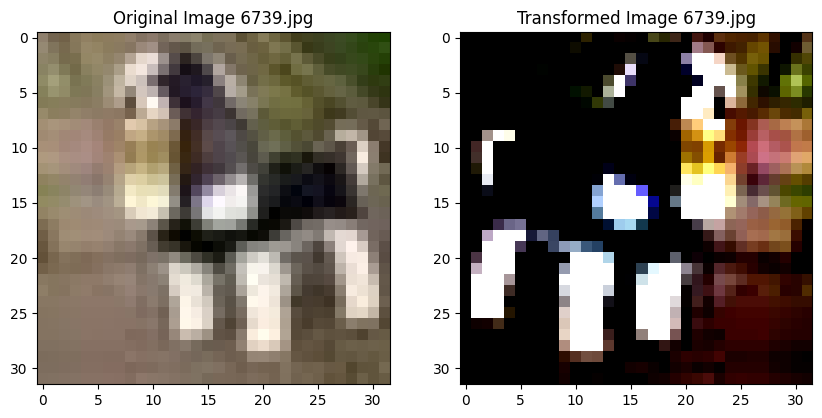

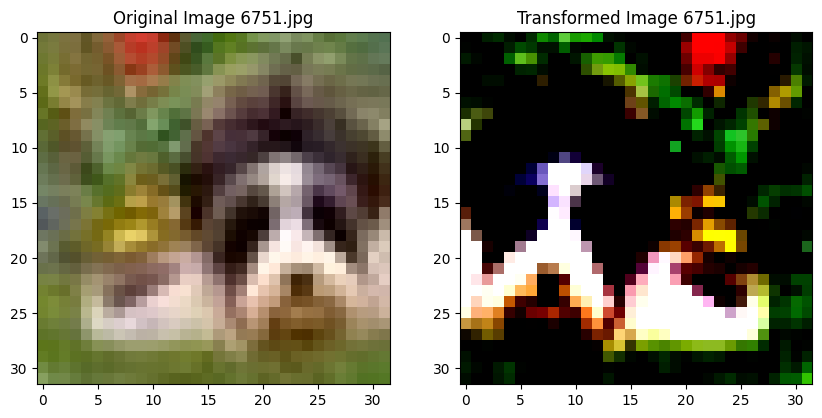

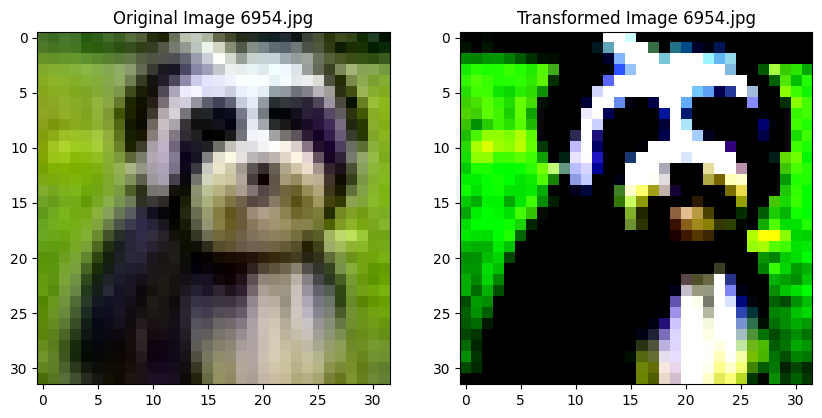

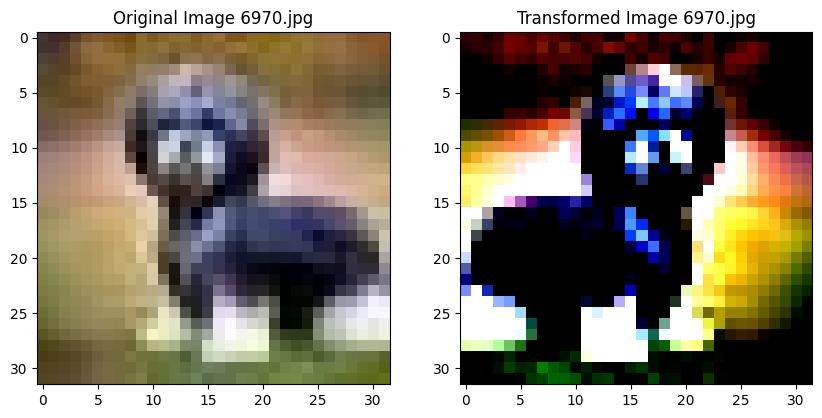

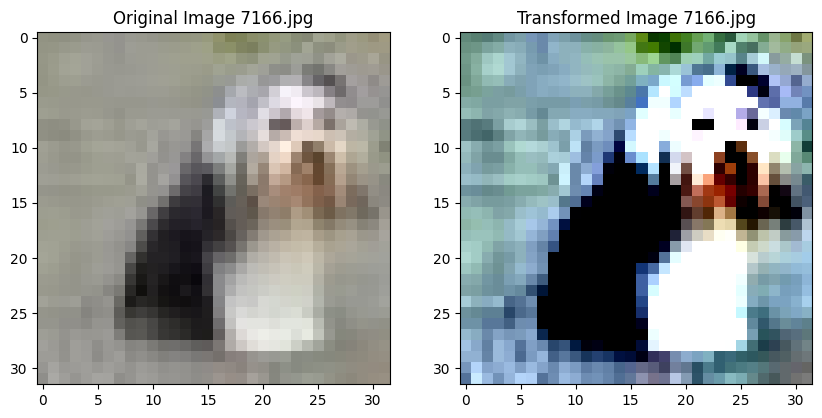

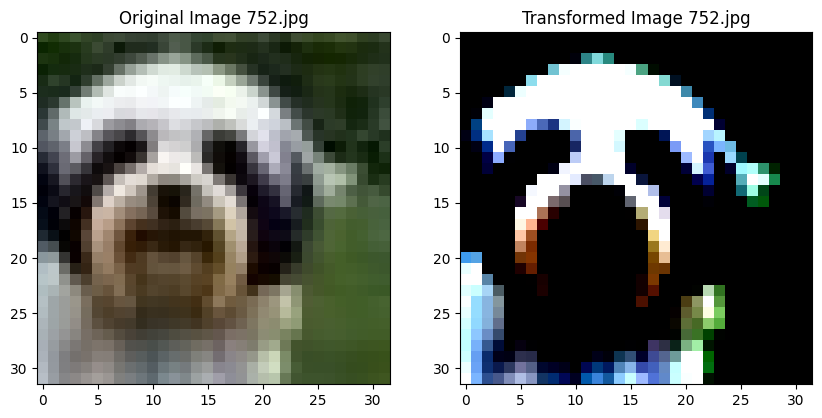

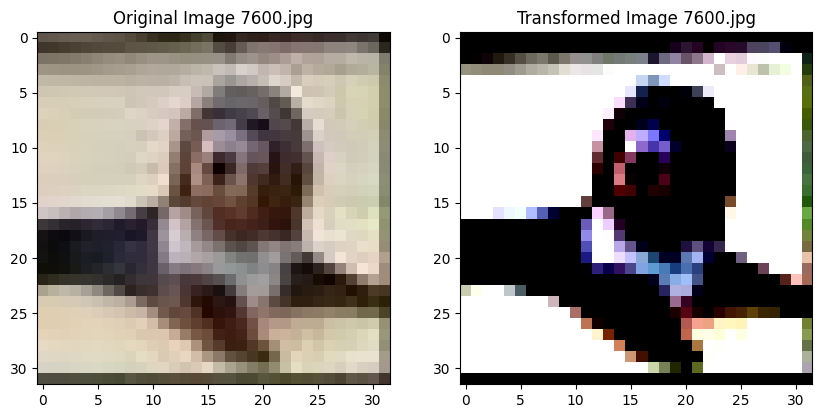

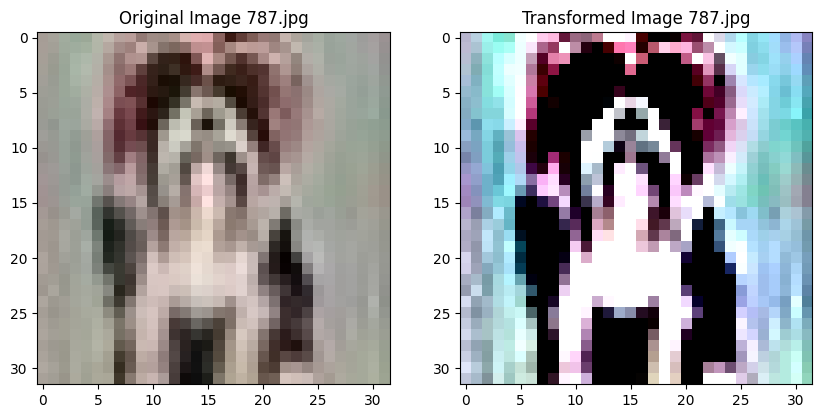

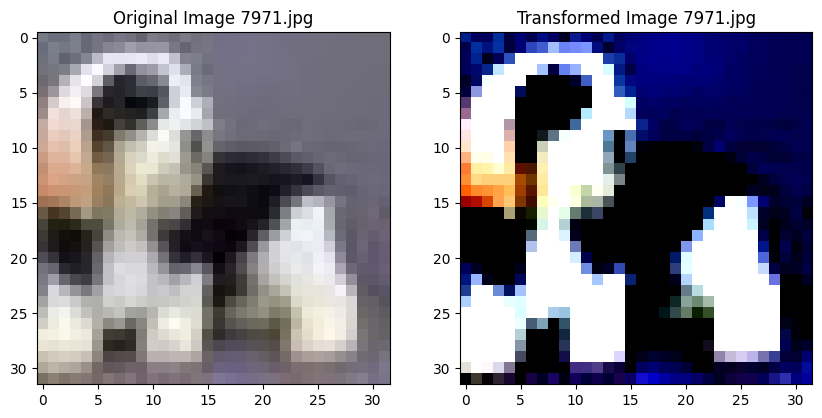

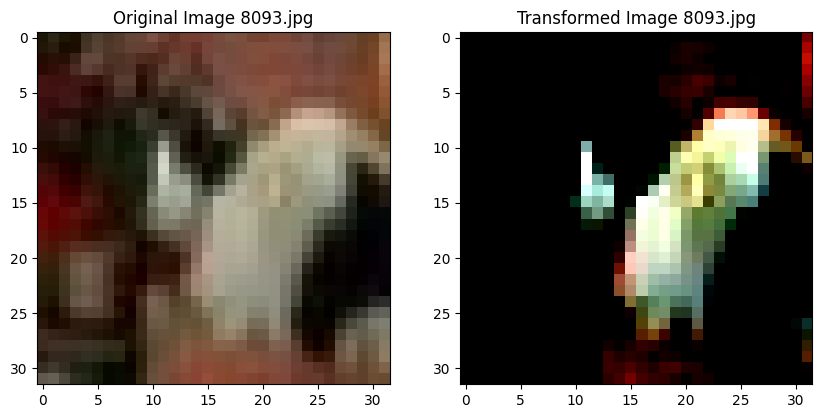

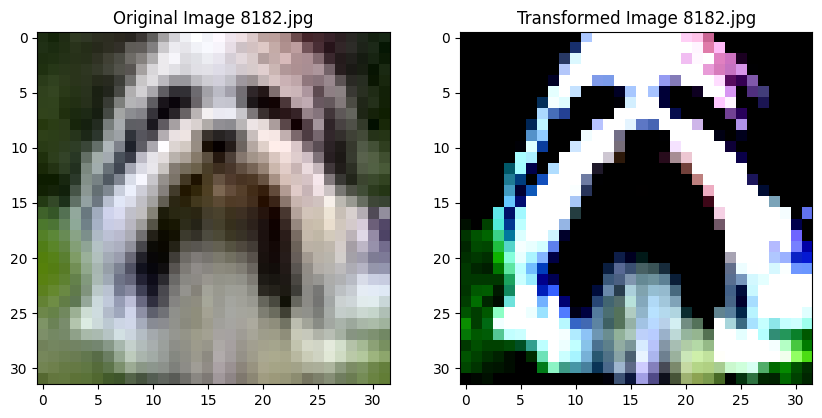

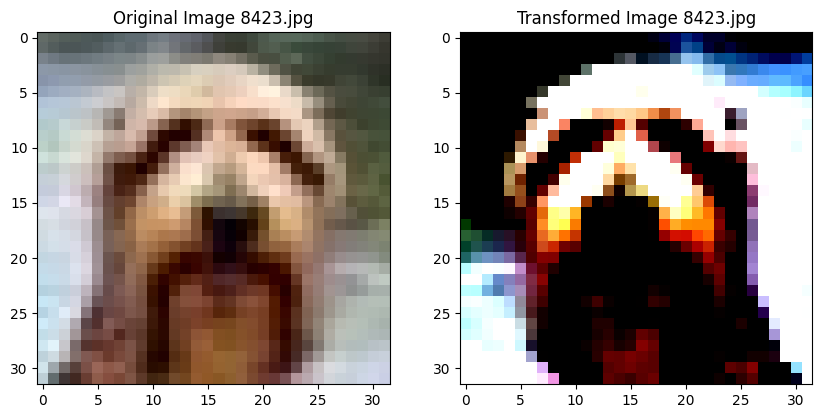

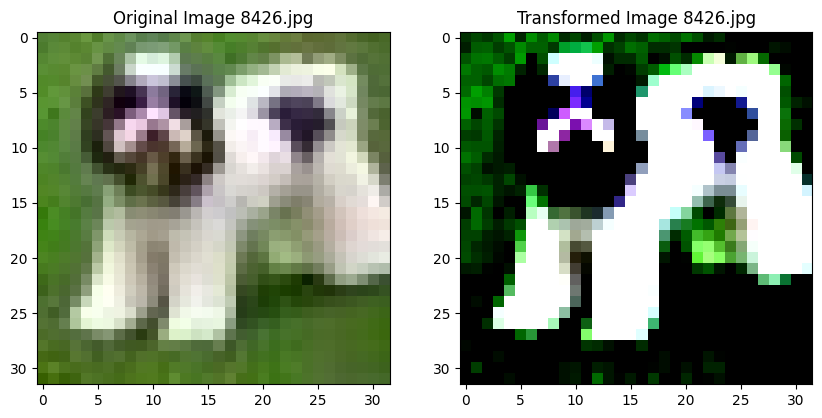

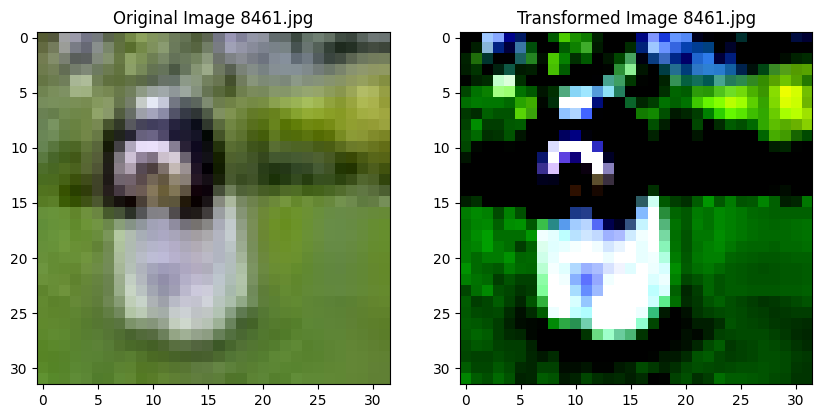

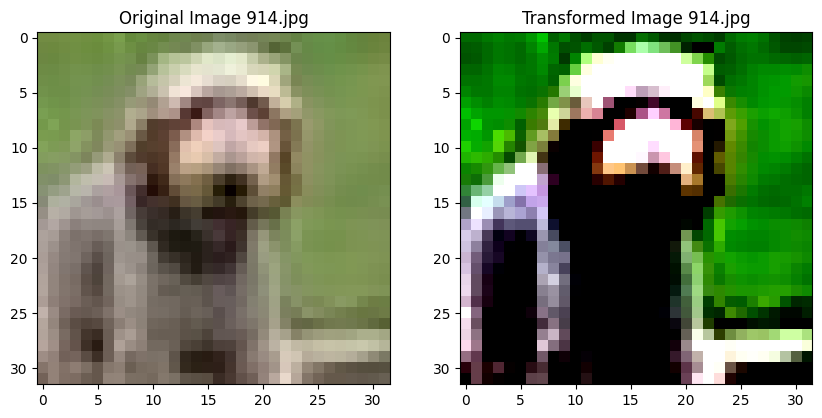

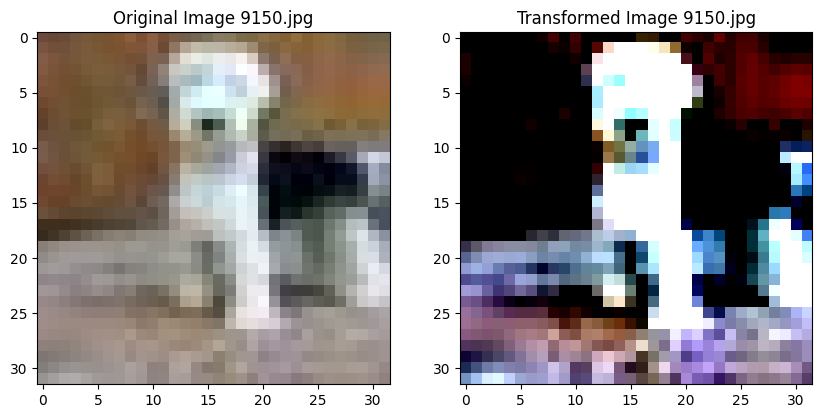

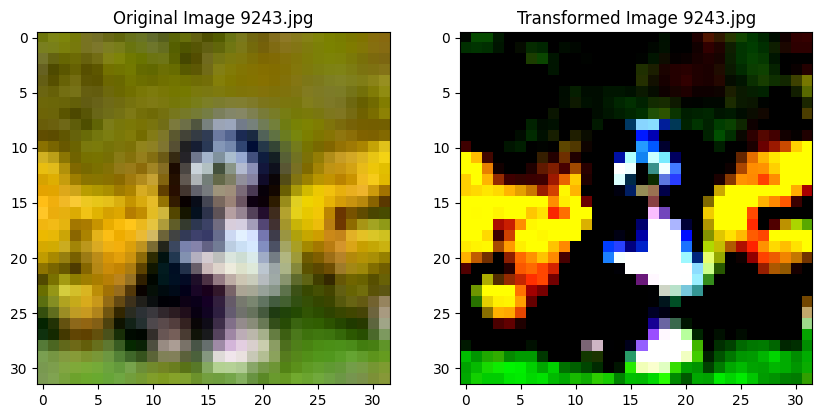

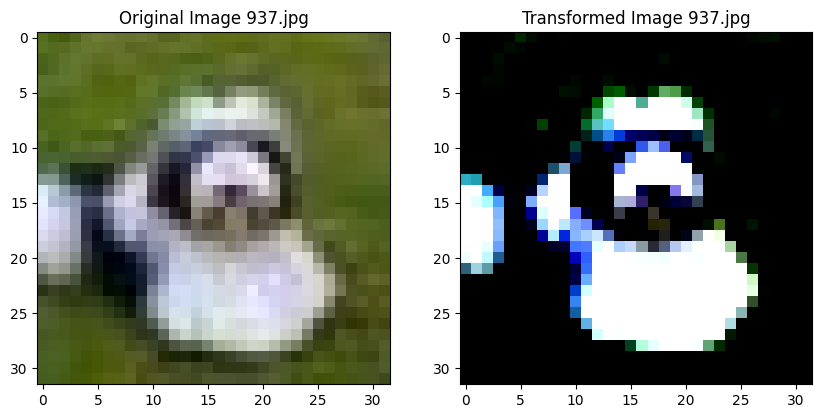

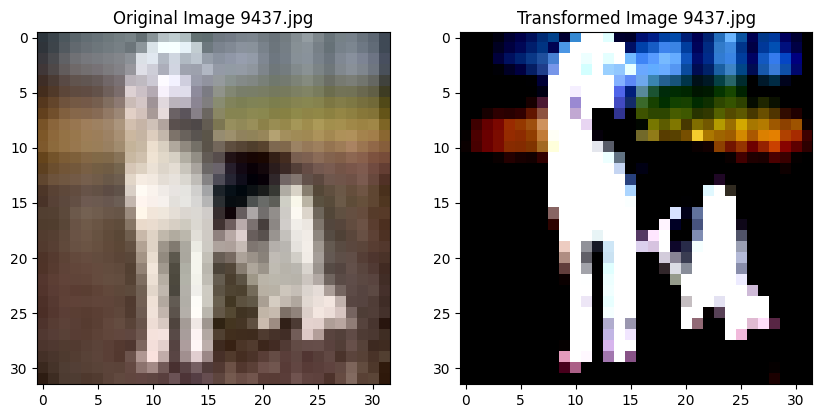

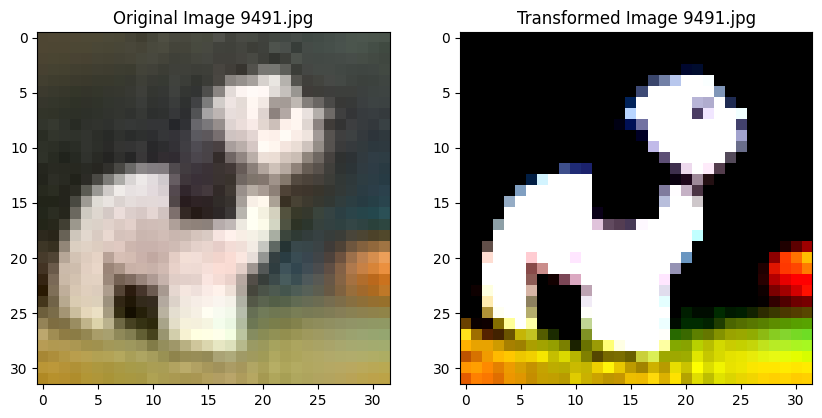

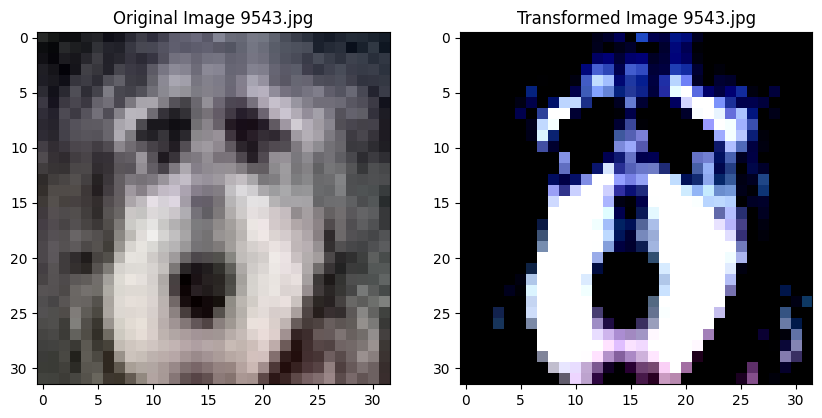

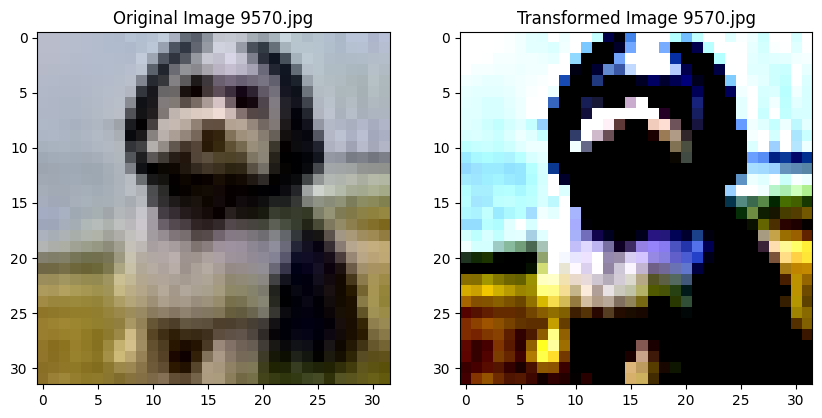

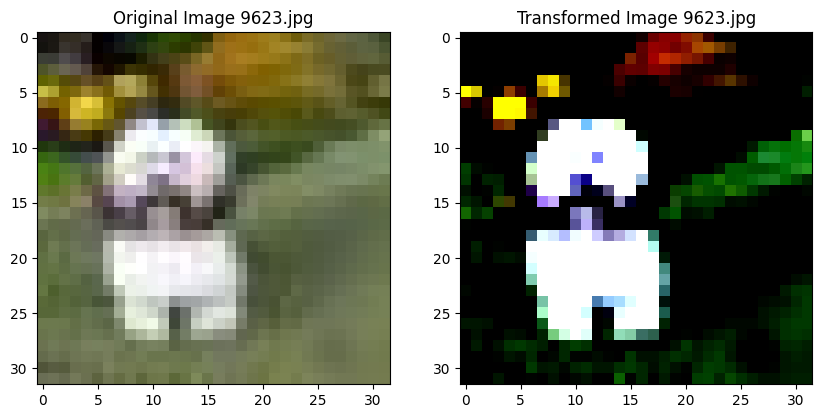

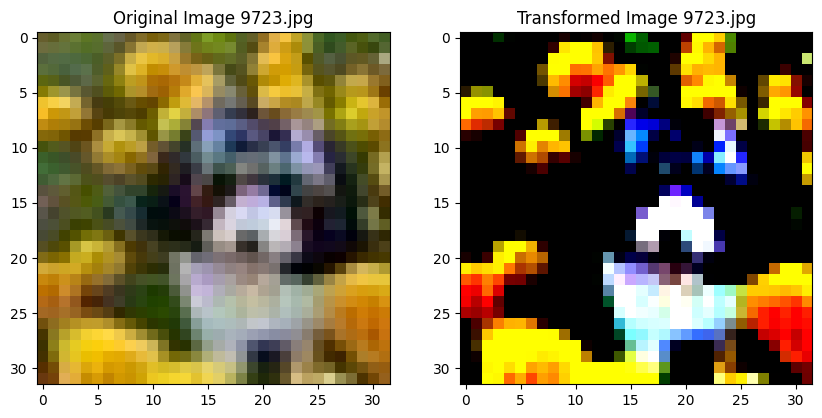

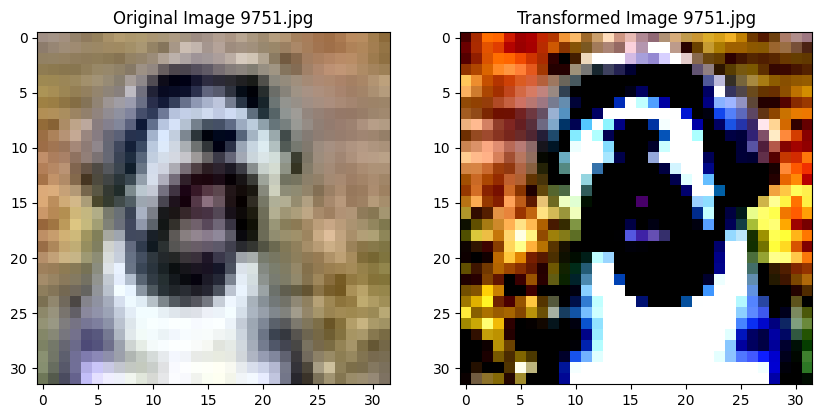

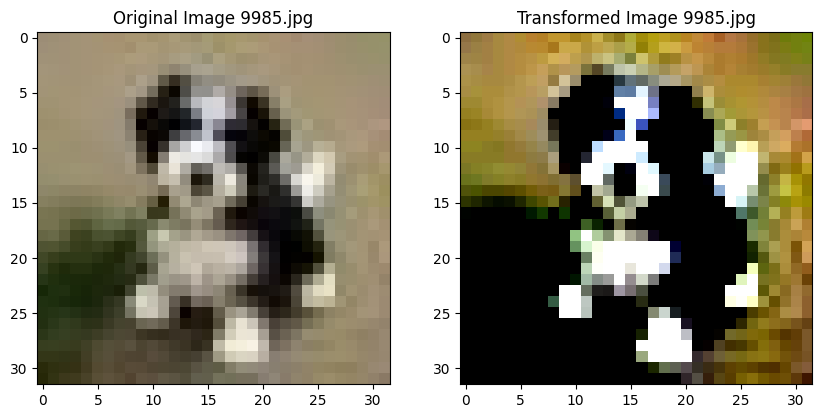

In [ ]:
csv_path_predicted = 'subclass_predictions.csv'
df_predicted_sub = pd.read_csv(csv_path_predicted)
print_images(12, df_predicted_sub, path="dataset/test/0/0/", label="ID", target="Target")

# Data Generator Code (used for expanding training dataset)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import zipfile
import os
import shutil

In [ ]:
# Create a directory to save the images
os.makedirs("enlarged_train_shuffle", exist_ok=True)

# Path to the zip file and the target directory
zip_file_path = 'train_shuffle.zip'
target_directory = 'enlarged_train_shuffle'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract to a temporary directory
    temp_directory = 'temp_dir'
    zip_ref.extractall(temp_directory)

    # Path to the subdirectory inside the temporary directory
    subdirectory_path = os.path.join(temp_directory, 'train_shuffle')

    # Copy .jpg files from the subdirectory to the target directory
    for filename in os.listdir(subdirectory_path):
        if filename.endswith('.jpg'):
            shutil.copy(os.path.join(subdirectory_path, filename), target_directory)

# Optional: Remove the temporary directory if no longer needed
shutil.rmtree(temp_directory)

In [ ]:
os.makedirs("enlarged_train_shuffle", exist_ok=True)

# Transform to convert images to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR-10 dataset
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./CIFAR_data', train=True, download=True, transform=transform)

# Load CIFAR-100 dataset
trainset_cifar100 = torchvision.datasets.CIFAR100(root='./CIFAR100_data', train=True, download=True, transform=transform)

# Classes for CIFAR-10
selected_classes_cifar10 = [0, 1, 8, 9, 3, 7, 4]  # 'airplane', 'automobile', 'ship', 'truck', 'cat', 'horse', 'deer'

# Classes for CIFAR-100 (man and woman)
selected_classes_cifar100 = [46, 98]  # 'man', 'woman'


# Define how many images you want from each class
class_counts = {
    0: 300,  # airplane
    1: 300,  # automobile
    8: 300,  # ship
    9: 300,  # truck
    3: 300,  # cat
    7: 300,  # horse
    4: 300,   # deer
    46: 300, # man
    98: 300  # woman
}

# Initialize subsets for each class
class_subsets = {class_id: [] for class_id in class_counts}

# Populate subsets for CIFAR-10
for i in range(len(trainset_cifar10)):
    image, label = trainset_cifar10[i]
    if label in selected_classes_cifar10:
        class_subsets[label].append((image, label))

# Populate subsets for CIFAR-100
for i in range(len(trainset_cifar100)):
    image, label = trainset_cifar100[i]
    if label in selected_classes_cifar100:
        class_subsets[label].append((image, label))

start_index = 6322

# Save images from each subset
for class_id, images in class_subsets.items():
    for i, (image, label) in enumerate(images):
        if i < class_counts[class_id]:  # Check if the limit for the class is not exceeded
            img = transforms.ToPILImage()(image)
            img.save(f"enlarged_train_shuffle/{start_index}.jpg")
            start_index += 1

both_novel_index = start_index
print(both_novel_index)

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import torchvision.transforms.v2 as v2

IMAGENET_API_WNID_TO_URLS = lambda wnid: f'http://www.image-net.org/api/imagenet.synset.geturls?wnid={wnid}'
target_directory = 'enlarged_train_shuffle'

# Update your categories with tuples (wnid, number of images)
categories = {
    "flamingo": ("n02007558", 250),
    "peacock": ("n01806143", 200),
    "egret": ("n02008796", 200),
    "huskey": ("n02110185", 200),
    "german_shepherd": ("n02106662", 200),
    "italian_greyhound": ("n02091032", 200),
}

def download_images_from_urls(id, start_index, max_images=100):
    url_urls = IMAGENET_API_WNID_TO_URLS(id)
    resp = requests.get(url_urls)
    urls = [url.decode('utf-8') for url in resp.content.splitlines()]

    if id == categories["huskey"][0]:
        urls = urls[3:]

    if id == categories["italian_greyhound"][0]:
        del urls[255:260]

    # Create a transform to resize the image to 32x32 pixels
    transform = v2.Resize((32, 32))
    current_index = start_index

    no_downloaded = 0
    for i, url in enumerate(urls):
        print(i)
        if no_downloaded == max_images:
            break
        try:
            response = requests.get(url, timeout=10)

            if response.status_code == 200:
                image_bytes = BytesIO(response.content)
                image = Image.open(image_bytes)
                resized_image = transform(image)

                # Save the resized image
                resized_image.save(f"{target_directory}/{current_index}.jpg")
                print(f'Image {current_index} saved.')
                current_index += 1
                no_downloaded += 1


        except Exception as e:
            print(f"Failed to download image from {url}")

    return current_index


for category_name, (wnid, num_images) in categories.items():
    print(f"Downloading images for category: {category_name}")
    start_index = download_images_from_urls(wnid, start_index, max_images=num_images)

In [ ]:
import pandas as pd

train_data = pd.read_csv('train_data.csv')

dataframes = [train_data]


# Creating the DataFrame for both novel classes and subclasses
df = pd.DataFrame({
    'image': [f"{i}.jpg" for i in range(6322, both_novel_index)],  # newly added images start from index 6322 onwards
    'superclass_index': [3] * (both_novel_index-6322),  # index 3 corresponds to the superclass 'novel'
    'subclass_index': [87] * (both_novel_index-6322)   # index 87 corresponds to the subclass 'novel'
})

dataframes.append(df)

current_index = both_novel_index
# Creating the DataFrame for the known classes and novel subclasses
for category, (id, count) in categories.items():
    if category in ["flamingo", "egret", "peacock"]:
        superclass_index = 0
    else:  # Dogs
        superclass_index = 1

    subclass_index = 87

    df = pd.DataFrame({
        'image': [f"{i}.jpg" for i in range(current_index, current_index + count)],
        'superclass_index': [superclass_index] * count,
        'subclass_index': [subclass_index] * count
    })

    dataframes.append(df)
    current_index += count

# They should be same
assert(start_index == current_index)

# Concatenate all dataframes
concatenated = pd.concat(dataframes, ignore_index=True)


print(concatenated.tail())

# save the new DataFrame
concatenated.to_csv('enlarged_train_data.csv', index=False)

In [ ]:
# Path to the folder containing images
folder_path = 'enlarged_train_shuffle'  # Replace with the actual path of your folder

# Name of the output zip file
zip_file_name = 'enlarged_train_shuffle.zip'

# Create a zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    # Iterate over all the files in the directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Add each file to the zip file
            zipf.write(os.path.join(root, file), arcname=file)

print(f"Zip file {zip_file_name} created successfully.")

#shutil.rmtree(folder_path)

# Displaying some of the ImageNet images

In [ ]:
import requests

IMAGENET_API_WNID_TO_URLS = lambda wnid: f'http://www.image-net.org/api/imagenet.synset.geturls?wnid={wnid}'


flamingo = "n02007558"
egret = "n02008796"
huskey = "n02110185"
german_shepherd = "n02106662"
italian_greyhound = "n02091032"
peacock = "n01806143"



In [ ]:
import requests
from io import BytesIO
from PIL import Image

def download_images_from_urls(id, max_images=10):

    url_urls = IMAGENET_API_WNID_TO_URLS(id)

    resp = requests.get(url_urls)

    urls = [url.decode('utf-8') for url in resp.content.splitlines()]

    if id == huskey:
      urls = urls[3:]

    downloaded_images = []

    for i, url in enumerate(urls):
        print(i)
        try:
          response = requests.get(url)

          if response.status_code == 200:
              # Convert the response content to bytes
              image_bytes = BytesIO(response.content)

              # Open the image using PIL
              image = Image.open(image_bytes)
              print('entered')
              downloaded_images.append(image)

              # Check if we reached the maximum number of images
              if len(downloaded_images) >= max_images:
                  break
        except Exception as e:
          print(f"Failed to download image from {url}")

    return downloaded_images

# Example usage
# Assuming `urls` is your list of URLs
downloaded_images = download_images_from_urls(huskey, max_images=5)



0
Failed to download image from http://www.jo-karsiberians.com/images/litters/skye_dkredmale_dkredfemale_6wks.jpg
1
Failed to download image from http://www.sibrescue.com/adoptions/Slick-new2.jpg
2
entered
3
entered
4
entered
5
6
entered
7
entered


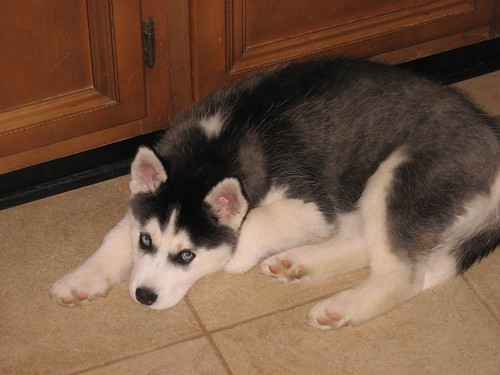

In [ ]:
display(downloaded_images[4])